<a href="https://colab.research.google.com/github/AndreiAf02/Data-Balancing-in-ML-DNN/blob/main/Bank_Marketing_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bank Marketing Dataset - ML Classification with Random Under/Oversampling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C5K306):

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)



{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [4]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [5]:
y

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


In [6]:
for i in range(len(X.columns)):
  print(X.columns[i])
  print(X.iloc[:, i].unique())
  print('------------------')

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
------------------
job
['management' 'technician' 'entrepreneur' 'blue-collar' nan 'retired'
 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
------------------
marital
['married' 'single' 'divorced']
------------------
education
['tertiary' 'secondary' nan 'primary']
------------------
default
['no' 'yes']
------------------
balance
[ 2143    29     2 ...  8205 14204 16353]
------------------
housing
['yes' 'no']
------------------
loan
['no' 'yes']
------------------
contact
[nan 'cellular' 'telephone']
------------------
day_of_week
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
------------------
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

In [7]:
X_numeric = pd.DataFrame()

## Age:
X_numeric['age'] = X['age']

## Working class:
X_numeric['job'] = X['job']
X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student'],
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True)


## Marital:
X_numeric['marital'] = X['marital']
X_numeric['marital'].replace(['single', 'married', 'divorced'],
                                    [0, 1, 2], inplace=True)

## Education:
X_numeric['education'] = X['education']
X_numeric['education'].replace(['primary', 'secondary', 'tertiary'],
                                    [0, 1, 2], inplace=True)


## Credit Default:
X_numeric['default'] = X['default']
X_numeric['default'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Balance:
X_numeric['balance'] = X['balance']


## Housing:
X_numeric['housing'] = X['housing']
X_numeric['housing'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)


## Loan:
X_numeric['loan'] = X['loan']
X_numeric['loan'].replace(['no', 'yes'],
                                    [0, 1], inplace=True)



## Contact:
X_numeric['contact'] = X['contact']
X_numeric['contact'].replace([np.nan, 'cellular', 'telephone'],
                                    [0, 1, 2], inplace=True)


## Day of week:
X_numeric['day_of_week'] = X['day_of_week']


## Month:
X_numeric['month'] = X['month']
X_numeric['month'].replace(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)


## Duration:
X_numeric['duration'] = X['duration']

## Campaign:
X_numeric['campaign'] = X['campaign']


## Pdays:
X_numeric['pdays'] = X['pdays']
# X_numeric['pdays'].replace([-1], [np.nan], inplace=True)

## Previous:
X_numeric['previous'] = X['previous']

## Poutcome:
X_numeric['poutcome'] = X['poutcome']
X_numeric['poutcome'].replace([np.nan, 'failure', 'success', 'other'],
                                    [0, 1, 2, 3], inplace=True)





## ---------------------- Response variable y: --------------------

## Income:
y_numeric = pd.DataFrame()
y_numeric['Y'] = y['y']
y_numeric['Y'].replace(['no', 'yes'],
                          [0, 1], inplace=True)

X_numeric


/tmp/ipython-input-3642445949.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_numeric['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar', 'retired',
/tmp/ipython-input-3642445949.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_numeric['job'].replace(['management', 

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,0.0,1,2.0,0,2143,1,0,0,5,4,261,1,-1,0,0
1,44,1.0,0,1.0,0,29,1,0,0,5,4,151,1,-1,0,0
2,33,2.0,1,1.0,0,2,1,1,0,5,4,76,1,-1,0,0
3,47,3.0,1,NaN,0,1506,1,0,0,5,4,92,1,-1,0,0
4,33,NaN,0,NaN,0,1,0,0,0,5,4,198,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,1.0,1,2.0,0,825,0,0,1,17,10,977,3,-1,0,0
45207,71,4.0,2,0.0,0,1729,0,0,1,17,10,456,2,-1,0,0
45208,72,4.0,1,1.0,0,5715,0,0,1,17,10,1127,5,184,3,2
45209,57,3.0,1,1.0,0,668,0,0,2,17,10,508,4,-1,0,0


In [8]:
# data2 = pd.concat([X_scaled, y], axis=1)
data2 = pd.concat([X_numeric, y_numeric], axis=1)
data2 = data2.dropna().reset_index(drop=True)
data2

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,Y
0,58,0.0,1,2.0,0,2143,1,0,0,5,4,261,1,-1,0,0,0
1,44,1.0,0,1.0,0,29,1,0,0,5,4,151,1,-1,0,0,0
2,33,2.0,1,1.0,0,2,1,1,0,5,4,76,1,-1,0,0,0
3,35,0.0,1,2.0,0,231,1,0,0,5,4,139,1,-1,0,0,0
4,28,0.0,0,2.0,0,447,1,1,0,5,4,217,1,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43188,51,1.0,1,2.0,0,825,0,0,1,17,10,977,3,-1,0,0,1
43189,71,4.0,2,0.0,0,1729,0,0,1,17,10,456,2,-1,0,0,1
43190,72,4.0,1,1.0,0,5715,0,0,1,17,10,1127,5,184,3,2,1
43191,57,3.0,1,1.0,0,668,0,0,2,17,10,508,4,-1,0,0,0


In [9]:
data2['Y'].value_counts()

,count
Y,
0,38172
1,5021


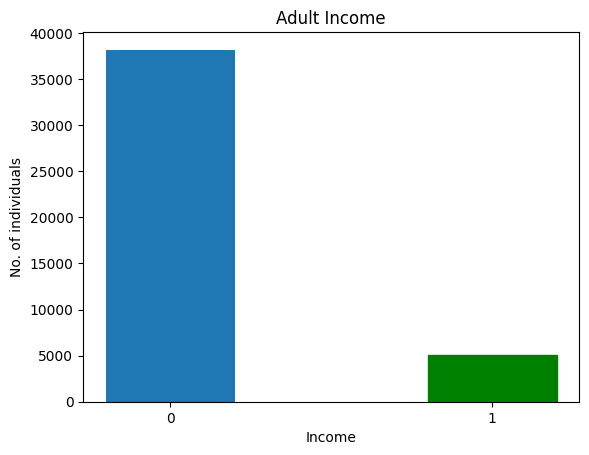

In [10]:
barlist = plt.bar([str(0),str(1)], data2['Y'].value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Income")
plt.ylabel("No. of individuals")
plt.title("Adult Income")
plt.show()

# Full Dataset:

## DNN Classification Algorithm:

In [11]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate_ml(model, X_train, X_test, y_train, y_test, domain):

    # time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)

    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)

    # conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # ## To deactivate after!!! ----------------------------------------
    # ##### Plot ROC curve and Confusion Matrix side by side
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # # ROC Curve
    # ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    # ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    # ax1.set_xlabel('False Positive Rate')
    # ax1.set_ylabel('True Positive Rate')
    # ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    # ax1.legend(loc='lower right')
    # ax1.grid()

    # # Confusion Matrix
    # conf_disp.plot(ax=ax2, cmap='Blues')
    # ax2.set_title('Confusion Matrix')
    # plt.tight_layout()
    # plt.show()
    ## To deactivate after!!! ----------------------------------------

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    return fpr, tnr, fnr, tpr


In [12]:
X_cleaned = data2.iloc[:, :-1]
y_cleaned = data2.iloc[:, -1]

scaler = MinMaxScaler()
scaler.fit(X_cleaned)
X_scaled = scaler.transform(X_cleaned)
X_scaled = pd.DataFrame(X_scaled)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cleaned, test_size=0.20, random_state=0)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [14]:
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (34554, 16)
y_train: (34554,)
X_test: (8639, 16)
y_test: (8639,)


In [15]:
## Establishing the Under/Oversampling values and imbalance ratio:

undersample_size = min(data_train.iloc[:,-1].value_counts())
oversample_size = max(data_train.iloc[:,-1].value_counts())


data_majority = data_train[data_train.iloc[:,-1]==0]
data_minority = data_train[data_train.iloc[:,-1]==1]

print(undersample_size)
print(oversample_size)

4033
30521


## Imbalanced (Original) data:

In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    model_source = create_dnn_model(X_train.shape[1])
    result_imbalanced = train_and_evaluate_ml(model_source, X_train, X_test, y_train, y_test, "Source")
    # result_TL_imbalanced = Transductive_TL(model_source, X_T_full, y_T_full, "Target")

    FPR.append(result_imbalanced[0])
    TNR.append(result_imbalanced[1])
    FNR.append(result_imbalanced[2])
    TPR.append(result_imbalanced[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']
# print(ParamFit)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.6828 - loss: 0.3494 - val_AUC: 0.8724 - val_loss: 0.2667
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8759 - loss: 0.2559 - val_AUC: 0.8823 - val_loss: 0.2500
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8897 - loss: 0.2399 - val_AUC: 0.8831 - val_loss: 0.2506
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8844 - loss: 0.2415 - val_AUC: 0.8888 - val_loss: 0.2439
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8897 - loss: 0.2408 - val_AUC: 0.8899 - val_loss: 0.2433
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8951 - loss: 0.2298 - val_AUC: 0.8932 - val_loss: 0.2438
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8979 - loss: 0.2318 - val_AUC: 0.8943 - val_loss: 0.2398
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8934 - loss: 0.2341 - val_AUC: 0.8950 - val_loss: 0.2587
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9031 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6783 - loss: 0.3622 - val_AUC: 0.8657 - val_loss: 0.2649
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8715 - loss: 0.2534 - val_AUC: 0.8793 - val_loss: 0.2548
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8871 - loss: 0.2486 - val_AUC: 0.8817 - val_loss: 0.2500
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8827 - loss: 0.2428 - val_AUC: 0.8867 - val_loss: 0.2490
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8891 - loss: 0.2407 - val_AUC: 0.8854 - val_loss: 0.2480
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8916 - loss: 0.2394 - val_AUC: 0.8876 - val_loss: 0.2463
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8948 - loss: 0.2356 - val_AUC: 0.8911 - val_loss: 0.2405
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8957 - loss: 0.2351 - val_AUC: 0.8885 - val_loss: 0.2468
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8989 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6650 - loss: 0.3583 - val_AUC: 0.8758 - val_loss: 0.2593
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8727 - loss: 0.2545 - val_AUC: 0.8823 - val_loss: 0.2554
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8843 - loss: 0.2412 - val_AUC: 0.8846 - val_loss: 0.2490
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8833 - loss: 0.2451 - val_AUC: 0.8861 - val_loss: 0.2462
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8847 - loss: 0.2415 - val_AUC: 0.8883 - val_loss: 0.2437
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8910 - loss: 0.2343 - val_AUC: 0.8901 - val_loss: 0.2415
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8955 - loss: 0.2351 - val_AUC: 0.8884 - val_loss: 0.2423
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8989 - loss: 0.2322 - val_AUC: 0.8896 - val_loss: 0.2413
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8998 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.6947 - loss: 0.3469 - val_AUC: 0.8706 - val_loss: 0.2635
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8743 - loss: 0.2540 - val_AUC: 0.8807 - val_loss: 0.2521
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8876 - loss: 0.2401 - val_AUC: 0.8858 - val_loss: 0.2458
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8889 - loss: 0.2417 - val_AUC: 0.8898 - val_loss: 0.2429
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8978 - loss: 0.2323 - val_AUC: 0.8899 - val_loss: 0.2432
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.2296 - val_AUC: 0.8921 - val_loss: 0.2407
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8964 - loss: 0.2366 - val_AUC: 0.8943 - val_loss: 0.2383
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8982 - loss: 0.2311 - val_AUC: 0.8945 - val_loss: 0.2402
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9022 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6415 - loss: 0.3950 - val_AUC: 0.8602 - val_loss: 0.2712
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8701 - loss: 0.2585 - val_AUC: 0.8811 - val_loss: 0.2529
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8814 - loss: 0.2456 - val_AUC: 0.8861 - val_loss: 0.2479
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8874 - loss: 0.2419 - val_AUC: 0.8860 - val_loss: 0.2493
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8929 - loss: 0.2354 - val_AUC: 0.8894 - val_loss: 0.2424
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8935 - loss: 0.2367 - val_AUC: 0.8907 - val_loss: 0.2421
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9001 - loss: 0.2252 - val_AUC: 0.8930 - val_loss: 0.2390
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8963 - loss: 0.2355 - val_AUC: 0.8946 - val_loss: 0.2409
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8990 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6738 - loss: 0.3601 - val_AUC: 0.8733 - val_loss: 0.2668
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8755 - loss: 0.2483 - val_AUC: 0.8853 - val_loss: 0.2486
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8871 - loss: 0.2391 - val_AUC: 0.8850 - val_loss: 0.2465
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8902 - loss: 0.2382 - val_AUC: 0.8870 - val_loss: 0.2451
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8873 - loss: 0.2409 - val_AUC: 0.8906 - val_loss: 0.2441
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8962 - loss: 0.2323 - val_AUC: 0.8908 - val_loss: 0.2415
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8993 - loss: 0.2308 - val_AUC: 0.8941 - val_loss: 0.2435
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8998 - loss: 0.2319 - val_AUC: 0.8927 - val_loss: 0.2530
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8996 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6562 - loss: 0.3690 - val_AUC: 0.8667 - val_loss: 0.2657
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8784 - loss: 0.2542 - val_AUC: 0.8822 - val_loss: 0.2508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8826 - loss: 0.2496 - val_AUC: 0.8850 - val_loss: 0.2480
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8831 - loss: 0.2410 - val_AUC: 0.8880 - val_loss: 0.2447
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8943 - loss: 0.2351 - val_AUC: 0.8901 - val_loss: 0.2461
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8947 - loss: 0.2325 - val_AUC: 0.8937 - val_loss: 0.2397
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8987 - loss: 0.2299 - val_AUC: 0.8953 - val_loss: 0.2400
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8997 - loss: 0.2307 - val_AUC: 0.8956 - val_loss: 0.2374
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9007 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6689 - loss: 0.3535 - val_AUC: 0.8737 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8770 - loss: 0.2524 - val_AUC: 0.8860 - val_loss: 0.2480
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 - loss: 0.2403 - val_AUC: 0.8835 - val_loss: 0.2482
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8895 - loss: 0.2356 - val_AUC: 0.8883 - val_loss: 0.2439
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8953 - loss: 0.2343 - val_AUC: 0.8891 - val_loss: 0.2446
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8934 - loss: 0.2350 - val_AUC: 0.8894 - val_loss: 0.2431
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8939 - loss: 0.2332 - val_AUC: 0.8920 - val_loss: 0.2433
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8938 - loss: 0.2294 - val_AUC: 0.8934 - val_loss: 0.2388
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9004 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6666 - loss: 0.3589 - val_AUC: 0.8734 - val_loss: 0.2692
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8792 - loss: 0.2531 - val_AUC: 0.8842 - val_loss: 0.2491
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8851 - loss: 0.2468 - val_AUC: 0.8849 - val_loss: 0.2507
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8886 - loss: 0.2408 - val_AUC: 0.8877 - val_loss: 0.2435
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8884 - loss: 0.2373 - val_AUC: 0.8880 - val_loss: 0.2431
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8981 - loss: 0.2303 - val_AUC: 0.8902 - val_loss: 0.2417
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8972 - loss: 0.2298 - val_AUC: 0.8919 - val_loss: 0.2450
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9007 - loss: 0.2263 - val_AUC: 0.8960 - val_loss: 0.2404
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9047 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6745 - loss: 0.3636 - val_AUC: 0.8706 - val_loss: 0.2612
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8790 - loss: 0.2530 - val_AUC: 0.8819 - val_loss: 0.2524
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8875 - loss: 0.2436 - val_AUC: 0.8860 - val_loss: 0.2516
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8824 - loss: 0.2438 - val_AUC: 0.8880 - val_loss: 0.2446
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8910 - loss: 0.2416 - val_AUC: 0.8867 - val_loss: 0.2463
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8928 - loss: 0.2365 - val_AUC: 0.8885 - val_loss: 0.2452
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8910 - loss: 0.2375 - val_AUC: 0.8923 - val_loss: 0.2478
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8912 - loss: 0.2381 - val_AUC: 0.8913 - val_loss: 0.2419
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8932 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6811 - loss: 0.3513 - val_AUC: 0.8727 - val_loss: 0.2598
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8808 - loss: 0.2454 - val_AUC: 0.8834 - val_loss: 0.2484
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8836 - loss: 0.2432 - val_AUC: 0.8840 - val_loss: 0.2469
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8904 - loss: 0.2370 - val_AUC: 0.8863 - val_loss: 0.2469
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8957 - loss: 0.2323 - val_AUC: 0.8898 - val_loss: 0.2427
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8939 - loss: 0.2371 - val_AUC: 0.8917 - val_loss: 0.2418
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8972 - loss: 0.2366 - val_AUC: 0.8948 - val_loss: 0.2380
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8965 - loss: 0.2313 - val_AUC: 0.8959 - val_loss: 0.2396
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9025 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6600 - loss: 0.3609 - val_AUC: 0.8785 - val_loss: 0.2654
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8766 - loss: 0.2530 - val_AUC: 0.8812 - val_loss: 0.2500
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8901 - loss: 0.2406 - val_AUC: 0.8857 - val_loss: 0.2461
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8879 - loss: 0.2419 - val_AUC: 0.8886 - val_loss: 0.2460
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8956 - loss: 0.2365 - val_AUC: 0.8893 - val_loss: 0.2462
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8973 - loss: 0.2317 - val_AUC: 0.8901 - val_loss: 0.2450
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8950 - loss: 0.2343 - val_AUC: 0.8949 - val_loss: 0.2377
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9054 - loss: 0.2257 - val_AUC: 0.8940 - val_loss: 0.2387
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9071 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6562 - loss: 0.3540 - val_AUC: 0.8724 - val_loss: 0.2600
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8777 - loss: 0.2531 - val_AUC: 0.8832 - val_loss: 0.2504
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8845 - loss: 0.2481 - val_AUC: 0.8834 - val_loss: 0.2525
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 - loss: 0.2408 - val_AUC: 0.8834 - val_loss: 0.2470
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8864 - loss: 0.2416 - val_AUC: 0.8884 - val_loss: 0.2436
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8914 - loss: 0.2372 - val_AUC: 0.8875 - val_loss: 0.2508
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8930 - loss: 0.2368 - val_AUC: 0.8912 - val_loss: 0.2410
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8943 - loss: 0.2360 - val_AUC: 0.8893 - val_loss: 0.2446
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8941 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7006 - loss: 0.3355 - val_AUC: 0.8759 - val_loss: 0.2587
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 - loss: 0.2490 - val_AUC: 0.8821 - val_loss: 0.2525
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8789 - loss: 0.2471 - val_AUC: 0.8839 - val_loss: 0.2479
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8795 - loss: 0.2496 - val_AUC: 0.8857 - val_loss: 0.2473
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8913 - loss: 0.2381 - val_AUC: 0.8875 - val_loss: 0.2450
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8935 - loss: 0.2382 - val_AUC: 0.8901 - val_loss: 0.2423
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8899 - loss: 0.2375 - val_AUC: 0.8885 - val_loss: 0.2436
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8992 - loss: 0.2314 - val_AUC: 0.8912 - val_loss: 0.2470
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9009 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6719 - loss: 0.3598 - val_AUC: 0.8704 - val_loss: 0.2670
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8764 - loss: 0.2484 - val_AUC: 0.8815 - val_loss: 0.2562
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8779 - loss: 0.2478 - val_AUC: 0.8862 - val_loss: 0.2461
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8851 - loss: 0.2408 - val_AUC: 0.8879 - val_loss: 0.2462
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8940 - loss: 0.2363 - val_AUC: 0.8906 - val_loss: 0.2423
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8933 - loss: 0.2408 - val_AUC: 0.8905 - val_loss: 0.2419
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8983 - loss: 0.2352 - val_AUC: 0.8920 - val_loss: 0.2407
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8982 - loss: 0.2308 - val_AUC: 0.8951 - val_loss: 0.2392
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9007 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6717 - loss: 0.3687 - val_AUC: 0.8682 - val_loss: 0.2652
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8794 - loss: 0.2516 - val_AUC: 0.8824 - val_loss: 0.2578
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8874 - loss: 0.2382 - val_AUC: 0.8837 - val_loss: 0.2495
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8920 - loss: 0.2408 - val_AUC: 0.8892 - val_loss: 0.2449
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8878 - loss: 0.2421 - val_AUC: 0.8875 - val_loss: 0.2443
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8891 - loss: 0.2369 - val_AUC: 0.8916 - val_loss: 0.2410
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8978 - loss: 0.2318 - val_AUC: 0.8946 - val_loss: 0.2396
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9026 - loss: 0.2268 - val_AUC: 0.8950 - val_loss: 0.2378
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9016 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6640 - loss: 0.3670 - val_AUC: 0.8676 - val_loss: 0.2671
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8811 - loss: 0.2520 - val_AUC: 0.8828 - val_loss: 0.2508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8858 - loss: 0.2400 - val_AUC: 0.8857 - val_loss: 0.2462
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8870 - loss: 0.2401 - val_AUC: 0.8883 - val_loss: 0.2466
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8910 - loss: 0.2361 - val_AUC: 0.8890 - val_loss: 0.2457
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8936 - loss: 0.2332 - val_AUC: 0.8897 - val_loss: 0.2421
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8970 - loss: 0.2331 - val_AUC: 0.8918 - val_loss: 0.2445
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8979 - loss: 0.2366 - val_AUC: 0.8929 - val_loss: 0.2444
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8984 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6690 - loss: 0.3548 - val_AUC: 0.8728 - val_loss: 0.2655
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 - loss: 0.2514 - val_AUC: 0.8794 - val_loss: 0.2529
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8815 - loss: 0.2431 - val_AUC: 0.8824 - val_loss: 0.2580
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8913 - loss: 0.2395 - val_AUC: 0.8864 - val_loss: 0.2456
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8884 - loss: 0.2396 - val_AUC: 0.8849 - val_loss: 0.2463
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8896 - loss: 0.2430 - val_AUC: 0.8868 - val_loss: 0.2452
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8937 - loss: 0.2360 - val_AUC: 0.8885 - val_loss: 0.2428
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8895 - loss: 0.2326 - val_AUC: 0.8895 - val_loss: 0.2421
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8992 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6686 - loss: 0.3482 - val_AUC: 0.8735 - val_loss: 0.2630
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8787 - loss: 0.2557 - val_AUC: 0.8803 - val_loss: 0.2564
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8868 - loss: 0.2453 - val_AUC: 0.8858 - val_loss: 0.2472
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8911 - loss: 0.2404 - val_AUC: 0.8867 - val_loss: 0.2471
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8930 - loss: 0.2356 - val_AUC: 0.8878 - val_loss: 0.2450
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8944 - loss: 0.2333 - val_AUC: 0.8895 - val_loss: 0.2431
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8948 - loss: 0.2357 - val_AUC: 0.8896 - val_loss: 0.2429
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9032 - loss: 0.2266 - val_AUC: 0.8925 - val_loss: 0.2471
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8998 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.6694 - loss: 0.3517 - val_AUC: 0.8731 - val_loss: 0.2667
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8774 - loss: 0.2529 - val_AUC: 0.8806 - val_loss: 0.2513
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8872 - loss: 0.2433 - val_AUC: 0.8847 - val_loss: 0.2512
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8841 - loss: 0.2435 - val_AUC: 0.8881 - val_loss: 0.2448
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8912 - loss: 0.2433 - val_AUC: 0.8865 - val_loss: 0.2452
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8901 - loss: 0.2390 - val_AUC: 0.8910 - val_loss: 0.2429
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8935 - loss: 0.2381 - val_AUC: 0.8905 - val_loss: 0.2415
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8947 - loss: 0.2354 - val_AUC: 0.8917 - val_loss: 0.2409
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9017 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6832 - loss: 0.3516 - val_AUC: 0.8737 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8747 - loss: 0.2570 - val_AUC: 0.8852 - val_loss: 0.2514
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8874 - loss: 0.2437 - val_AUC: 0.8858 - val_loss: 0.2477
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8935 - loss: 0.2396 - val_AUC: 0.8852 - val_loss: 0.2568
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8907 - loss: 0.2377 - val_AUC: 0.8887 - val_loss: 0.2431
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8987 - loss: 0.2311 - val_AUC: 0.8891 - val_loss: 0.2419
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8986 - loss: 0.2291 - val_AUC: 0.8940 - val_loss: 0.2443
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8985 - loss: 0.2328 - val_AUC: 0.8962 - val_loss: 0.2424
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9029 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6781 - loss: 0.3578 - val_AUC: 0.8728 - val_loss: 0.2672
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8769 - loss: 0.2554 - val_AUC: 0.8811 - val_loss: 0.2546
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8798 - loss: 0.2496 - val_AUC: 0.8829 - val_loss: 0.2494
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8850 - loss: 0.2422 - val_AUC: 0.8861 - val_loss: 0.2462
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8901 - loss: 0.2395 - val_AUC: 0.8891 - val_loss: 0.2425
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8980 - loss: 0.2297 - val_AUC: 0.8863 - val_loss: 0.2445
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8898 - loss: 0.2380 - val_AUC: 0.8912 - val_loss: 0.2413
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8954 - loss: 0.2318 - val_AUC: 0.8915 - val_loss: 0.2414
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8958 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6557 - loss: 0.3692 - val_AUC: 0.8695 - val_loss: 0.2624
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8791 - loss: 0.2493 - val_AUC: 0.8821 - val_loss: 0.2527
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8827 - loss: 0.2448 - val_AUC: 0.8824 - val_loss: 0.2488
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8903 - loss: 0.2437 - val_AUC: 0.8861 - val_loss: 0.2475
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8959 - loss: 0.2321 - val_AUC: 0.8862 - val_loss: 0.2448
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8916 - loss: 0.2328 - val_AUC: 0.8886 - val_loss: 0.2541
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8879 - loss: 0.2356 - val_AUC: 0.8890 - val_loss: 0.2427
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8948 - loss: 0.2285 - val_AUC: 0.8909 - val_loss: 0.2431
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8954 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6449 - loss: 0.3851 - val_AUC: 0.8731 - val_loss: 0.2607
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8731 - loss: 0.2526 - val_AUC: 0.8828 - val_loss: 0.2531
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8877 - loss: 0.2390 - val_AUC: 0.8851 - val_loss: 0.2465
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8914 - loss: 0.2375 - val_AUC: 0.8844 - val_loss: 0.2517
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8901 - loss: 0.2415 - val_AUC: 0.8889 - val_loss: 0.2440
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8937 - loss: 0.2352 - val_AUC: 0.8873 - val_loss: 0.2436
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8946 - loss: 0.2347 - val_AUC: 0.8892 - val_loss: 0.2472
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9003 - loss: 0.2278 - val_AUC: 0.8919 - val_loss: 0.2497
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9008 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6660 - loss: 0.3651 - val_AUC: 0.8722 - val_loss: 0.2687
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8768 - loss: 0.2487 - val_AUC: 0.8798 - val_loss: 0.2528
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8871 - loss: 0.2448 - val_AUC: 0.8842 - val_loss: 0.2502
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8861 - loss: 0.2404 - val_AUC: 0.8884 - val_loss: 0.2434
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8950 - loss: 0.2358 - val_AUC: 0.8922 - val_loss: 0.2417
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.2306 - val_AUC: 0.8938 - val_loss: 0.2388
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9007 - loss: 0.2265 - val_AUC: 0.8960 - val_loss: 0.2378
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9033 - loss: 0.2241 - val_AUC: 0.8939 - val_loss: 0.2435
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9027 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6545 - loss: 0.3676 - val_AUC: 0.8695 - val_loss: 0.2671
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8745 - loss: 0.2546 - val_AUC: 0.8826 - val_loss: 0.2515
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8864 - loss: 0.2422 - val_AUC: 0.8842 - val_loss: 0.2479
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8897 - loss: 0.2351 - val_AUC: 0.8862 - val_loss: 0.2479
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8911 - loss: 0.2389 - val_AUC: 0.8858 - val_loss: 0.2460
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8916 - loss: 0.2379 - val_AUC: 0.8858 - val_loss: 0.2524
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8919 - loss: 0.2379 - val_AUC: 0.8907 - val_loss: 0.2457
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8981 - loss: 0.2312 - val_AUC: 0.8890 - val_loss: 0.2484
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8932 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6739 - loss: 0.3622 - val_AUC: 0.8802 - val_loss: 0.2578
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8760 - loss: 0.2513 - val_AUC: 0.8841 - val_loss: 0.2517
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8845 - loss: 0.2421 - val_AUC: 0.8847 - val_loss: 0.2655
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8892 - loss: 0.2389 - val_AUC: 0.8886 - val_loss: 0.2469
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8936 - loss: 0.2385 - val_AUC: 0.8881 - val_loss: 0.2431
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8940 - loss: 0.2327 - val_AUC: 0.8911 - val_loss: 0.2422
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8968 - loss: 0.2326 - val_AUC: 0.8936 - val_loss: 0.2393
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8963 - loss: 0.2356 - val_AUC: 0.8930 - val_loss: 0.2397
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8964 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6706 - loss: 0.3759 - val_AUC: 0.8734 - val_loss: 0.2645
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8744 - loss: 0.2561 - val_AUC: 0.8801 - val_loss: 0.2515
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8885 - loss: 0.2421 - val_AUC: 0.8858 - val_loss: 0.2473
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8914 - loss: 0.2394 - val_AUC: 0.8869 - val_loss: 0.2460
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8897 - loss: 0.2397 - val_AUC: 0.8879 - val_loss: 0.2441
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8933 - loss: 0.2331 - val_AUC: 0.8888 - val_loss: 0.2453
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8972 - loss: 0.2363 - val_AUC: 0.8934 - val_loss: 0.2395
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8966 - loss: 0.2320 - val_AUC: 0.8931 - val_loss: 0.2400
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9023 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6546 - loss: 0.3695 - val_AUC: 0.8726 - val_loss: 0.2658
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8724 - loss: 0.2575 - val_AUC: 0.8782 - val_loss: 0.2609
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8800 - loss: 0.2509 - val_AUC: 0.8820 - val_loss: 0.2500
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8867 - loss: 0.2418 - val_AUC: 0.8848 - val_loss: 0.2534
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8900 - loss: 0.2388 - val_AUC: 0.8890 - val_loss: 0.2466
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8905 - loss: 0.2378 - val_AUC: 0.8865 - val_loss: 0.2464
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8927 - loss: 0.2350 - val_AUC: 0.8880 - val_loss: 0.2439
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8985 - loss: 0.2312 - val_AUC: 0.8919 - val_loss: 0.2446
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9028 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6887 - loss: 0.3531 - val_AUC: 0.8687 - val_loss: 0.2663
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8802 - loss: 0.2537 - val_AUC: 0.8794 - val_loss: 0.2526
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8848 - loss: 0.2408 - val_AUC: 0.8870 - val_loss: 0.2460
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8899 - loss: 0.2408 - val_AUC: 0.8873 - val_loss: 0.2444
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8899 - loss: 0.2414 - val_AUC: 0.8869 - val_loss: 0.2491
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8947 - loss: 0.2317 - val_AUC: 0.8891 - val_loss: 0.2418
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - loss: 0.2346 - val_AUC: 0.8914 - val_loss: 0.2407
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8964 - loss: 0.2352 - val_AUC: 0.8907 - val_loss: 0.2543
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9003 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6575 - loss: 0.3607 - val_AUC: 0.8722 - val_loss: 0.2627
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8712 - loss: 0.2592 - val_AUC: 0.8792 - val_loss: 0.2523
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8857 - loss: 0.2463 - val_AUC: 0.8817 - val_loss: 0.2503
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8894 - loss: 0.2384 - val_AUC: 0.8855 - val_loss: 0.2461
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8877 - loss: 0.2416 - val_AUC: 0.8865 - val_loss: 0.2461
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8970 - loss: 0.2285 - val_AUC: 0.8881 - val_loss: 0.2455
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8932 - loss: 0.2313 - val_AUC: 0.8895 - val_loss: 0.2425
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8938 - loss: 0.2375 - val_AUC: 0.8903 - val_loss: 0.2465
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8984 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6724 - loss: 0.3679 - val_AUC: 0.8719 - val_loss: 0.2608
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8773 - loss: 0.2546 - val_AUC: 0.8844 - val_loss: 0.2500
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8870 - loss: 0.2433 - val_AUC: 0.8825 - val_loss: 0.2491
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8922 - loss: 0.2379 - val_AUC: 0.8864 - val_loss: 0.2459
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8896 - loss: 0.2388 - val_AUC: 0.8864 - val_loss: 0.2602
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8910 - loss: 0.2385 - val_AUC: 0.8910 - val_loss: 0.2422
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8963 - loss: 0.2321 - val_AUC: 0.8916 - val_loss: 0.2461
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8992 - loss: 0.2263 - val_AUC: 0.8903 - val_loss: 0.2418
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8983 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6762 - loss: 0.3603 - val_AUC: 0.8749 - val_loss: 0.2616
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8741 - loss: 0.2535 - val_AUC: 0.8811 - val_loss: 0.2527
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8855 - loss: 0.2425 - val_AUC: 0.8836 - val_loss: 0.2487
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8862 - loss: 0.2432 - val_AUC: 0.8858 - val_loss: 0.2465
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8887 - loss: 0.2403 - val_AUC: 0.8859 - val_loss: 0.2465
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8962 - loss: 0.2309 - val_AUC: 0.8863 - val_loss: 0.2454
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8952 - loss: 0.2342 - val_AUC: 0.8880 - val_loss: 0.2458
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8958 - loss: 0.2329 - val_AUC: 0.8907 - val_loss: 0.2415
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8993 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6646 - loss: 0.3573 - val_AUC: 0.8624 - val_loss: 0.2656
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8739 - loss: 0.2500 - val_AUC: 0.8800 - val_loss: 0.2522
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8781 - loss: 0.2435 - val_AUC: 0.8824 - val_loss: 0.2515
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8830 - loss: 0.2413 - val_AUC: 0.8842 - val_loss: 0.2525
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8892 - loss: 0.2431 - val_AUC: 0.8869 - val_loss: 0.2446
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8877 - loss: 0.2416 - val_AUC: 0.8895 - val_loss: 0.2432
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8922 - loss: 0.2390 - val_AUC: 0.8901 - val_loss: 0.2477
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8930 - loss: 0.2347 - val_AUC: 0.8887 - val_loss: 0.2531
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8991 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6952 - loss: 0.3326 - val_AUC: 0.8740 - val_loss: 0.2599
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8766 - loss: 0.2565 - val_AUC: 0.8791 - val_loss: 0.2540
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8836 - loss: 0.2466 - val_AUC: 0.8825 - val_loss: 0.2489
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8945 - loss: 0.2344 - val_AUC: 0.8872 - val_loss: 0.2505
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8890 - loss: 0.2444 - val_AUC: 0.8874 - val_loss: 0.2444
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8991 - loss: 0.2296 - val_AUC: 0.8894 - val_loss: 0.2439
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8947 - loss: 0.2340 - val_AUC: 0.8899 - val_loss: 0.2429
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - loss: 0.2333 - val_AUC: 0.8896 - val_loss: 0.2427
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9007 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6489 - loss: 0.3604 - val_AUC: 0.8670 - val_loss: 0.2764
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8771 - loss: 0.2529 - val_AUC: 0.8833 - val_loss: 0.2496
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8899 - loss: 0.2414 - val_AUC: 0.8852 - val_loss: 0.2529
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8898 - loss: 0.2393 - val_AUC: 0.8841 - val_loss: 0.2563
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8930 - loss: 0.2337 - val_AUC: 0.8895 - val_loss: 0.2428
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8925 - loss: 0.2388 - val_AUC: 0.8883 - val_loss: 0.2437
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8976 - loss: 0.2323 - val_AUC: 0.8885 - val_loss: 0.2430
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8982 - loss: 0.2351 - val_AUC: 0.8885 - val_loss: 0.2467
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9002 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6564 - loss: 0.3528 - val_AUC: 0.8701 - val_loss: 0.2629
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8820 - loss: 0.2465 - val_AUC: 0.8818 - val_loss: 0.2512
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8873 - loss: 0.2400 - val_AUC: 0.8840 - val_loss: 0.2591
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8831 - loss: 0.2418 - val_AUC: 0.8856 - val_loss: 0.2488
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8935 - loss: 0.2369 - val_AUC: 0.8859 - val_loss: 0.2498
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8907 - loss: 0.2388 - val_AUC: 0.8876 - val_loss: 0.2447
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8953 - loss: 0.2380 - val_AUC: 0.8893 - val_loss: 0.2428
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8986 - loss: 0.2317 - val_AUC: 0.8920 - val_loss: 0.2404
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8972 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.6314 - loss: 0.3767 - val_AUC: 0.8604 - val_loss: 0.2747
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8728 - loss: 0.2663 - val_AUC: 0.8809 - val_loss: 0.2605
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8887 - loss: 0.2419 - val_AUC: 0.8847 - val_loss: 0.2503
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8897 - loss: 0.2401 - val_AUC: 0.8861 - val_loss: 0.2530
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8913 - loss: 0.2407 - val_AUC: 0.8888 - val_loss: 0.2453
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8948 - loss: 0.2346 - val_AUC: 0.8897 - val_loss: 0.2425
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8913 - loss: 0.2382 - val_AUC: 0.8905 - val_loss: 0.2424
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8979 - loss: 0.2340 - val_AUC: 0.8909 - val_loss: 0.2427
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8939 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6650 - loss: 0.3536 - val_AUC: 0.8754 - val_loss: 0.2626
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8735 - loss: 0.2603 - val_AUC: 0.8838 - val_loss: 0.2508
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8886 - loss: 0.2383 - val_AUC: 0.8834 - val_loss: 0.2492
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8887 - loss: 0.2422 - val_AUC: 0.8881 - val_loss: 0.2479
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8854 - loss: 0.2417 - val_AUC: 0.8873 - val_loss: 0.2511
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8913 - loss: 0.2376 - val_AUC: 0.8861 - val_loss: 0.2454
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8953 - loss: 0.2345 - val_AUC: 0.8919 - val_loss: 0.2403
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8997 - loss: 0.2313 - val_AUC: 0.8935 - val_loss: 0.2387
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9024 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.6859 - loss: 0.3638 - val_AUC: 0.8744 - val_loss: 0.2588
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8809 - loss: 0.2522 - val_AUC: 0.8820 - val_loss: 0.2505
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8852 - loss: 0.2409 - val_AUC: 0.8850 - val_loss: 0.2485
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8926 - loss: 0.2363 - val_AUC: 0.8877 - val_loss: 0.2466
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8902 - loss: 0.2430 - val_AUC: 0.8882 - val_loss: 0.2451
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8978 - loss: 0.2316 - val_AUC: 0.8894 - val_loss: 0.2499
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9004 - loss: 0.2293 - val_AUC: 0.8900 - val_loss: 0.2427
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8975 - loss: 0.2312 - val_AUC: 0.8911 - val_loss: 0.2410
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9016 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6682 - loss: 0.3575 - val_AUC: 0.8742 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8743 - loss: 0.2544 - val_AUC: 0.8792 - val_loss: 0.2514
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8863 - loss: 0.2349 - val_AUC: 0.8833 - val_loss: 0.2523
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8899 - loss: 0.2391 - val_AUC: 0.8857 - val_loss: 0.2457
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8910 - loss: 0.2365 - val_AUC: 0.8868 - val_loss: 0.2457
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8936 - loss: 0.2373 - val_AUC: 0.8895 - val_loss: 0.2531
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8966 - loss: 0.2325 - val_AUC: 0.8917 - val_loss: 0.2412
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8994 - loss: 0.2350 - val_AUC: 0.8951 - val_loss: 0.2382
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8993 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6801 - loss: 0.3452 - val_AUC: 0.8712 - val_loss: 0.2626
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8780 - loss: 0.2523 - val_AUC: 0.8799 - val_loss: 0.2603
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8846 - loss: 0.2494 - val_AUC: 0.8852 - val_loss: 0.2469
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8851 - loss: 0.2423 - val_AUC: 0.8826 - val_loss: 0.2539
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8929 - loss: 0.2392 - val_AUC: 0.8877 - val_loss: 0.2477
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8971 - loss: 0.2375 - val_AUC: 0.8889 - val_loss: 0.2456
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8957 - loss: 0.2312 - val_AUC: 0.8909 - val_loss: 0.2417
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9000 - loss: 0.2283 - val_AUC: 0.8905 - val_loss: 0.2421
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8967 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6803 - loss: 0.3536 - val_AUC: 0.8689 - val_loss: 0.2622
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8705 - loss: 0.2568 - val_AUC: 0.8821 - val_loss: 0.2541
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8836 - loss: 0.2455 - val_AUC: 0.8847 - val_loss: 0.2502
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8892 - loss: 0.2401 - val_AUC: 0.8866 - val_loss: 0.2548
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8916 - loss: 0.2327 - val_AUC: 0.8904 - val_loss: 0.2427
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8952 - loss: 0.2343 - val_AUC: 0.8920 - val_loss: 0.2436
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8978 - loss: 0.2347 - val_AUC: 0.8942 - val_loss: 0.2384
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8950 - loss: 0.2325 - val_AUC: 0.8970 - val_loss: 0.2365
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9029 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6731 - loss: 0.3611 - val_AUC: 0.8731 - val_loss: 0.2628
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8714 - loss: 0.2587 - val_AUC: 0.8828 - val_loss: 0.2510
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8881 - loss: 0.2426 - val_AUC: 0.8848 - val_loss: 0.2520
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8885 - loss: 0.2373 - val_AUC: 0.8873 - val_loss: 0.2449
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8895 - loss: 0.2401 - val_AUC: 0.8891 - val_loss: 0.2462
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8938 - loss: 0.2368 - val_AUC: 0.8901 - val_loss: 0.2415
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8986 - loss: 0.2292 - val_AUC: 0.8919 - val_loss: 0.2401
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8979 - loss: 0.2321 - val_AUC: 0.8939 - val_loss: 0.2394
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8995 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6393 - loss: 0.3896 - val_AUC: 0.8685 - val_loss: 0.2639
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8709 - loss: 0.2530 - val_AUC: 0.8786 - val_loss: 0.2541
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8843 - loss: 0.2398 - val_AUC: 0.8827 - val_loss: 0.2498
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8844 - loss: 0.2410 - val_AUC: 0.8823 - val_loss: 0.2516
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8891 - loss: 0.2471 - val_AUC: 0.8864 - val_loss: 0.2485
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8888 - loss: 0.2373 - val_AUC: 0.8879 - val_loss: 0.2441
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8965 - loss: 0.2314 - val_AUC: 0.8893 - val_loss: 0.2428
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8981 - loss: 0.2290 - val_AUC: 0.8890 - val_loss: 0.2422
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8996 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.6481 - loss: 0.3676 - val_AUC: 0.8660 - val_loss: 0.2649
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8788 - loss: 0.2515 - val_AUC: 0.8803 - val_loss: 0.2525
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8845 - loss: 0.2417 - val_AUC: 0.8867 - val_loss: 0.2454
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8900 - loss: 0.2442 - val_AUC: 0.8863 - val_loss: 0.2452
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8928 - loss: 0.2363 - val_AUC: 0.8888 - val_loss: 0.2453
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8928 - loss: 0.2391 - val_AUC: 0.8917 - val_loss: 0.2423
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8974 - loss: 0.2357 - val_AUC: 0.8922 - val_loss: 0.2405
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8990 - loss: 0.2296 - val_AUC: 0.8942 - val_loss: 0.2399
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9012 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6807 - loss: 0.3580 - val_AUC: 0.8723 - val_loss: 0.2611
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8676 - loss: 0.2569 - val_AUC: 0.8801 - val_loss: 0.2556
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8825 - loss: 0.2491 - val_AUC: 0.8834 - val_loss: 0.2478
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8861 - loss: 0.2398 - val_AUC: 0.8867 - val_loss: 0.2450
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8915 - loss: 0.2342 - val_AUC: 0.8876 - val_loss: 0.2443
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8900 - loss: 0.2359 - val_AUC: 0.8884 - val_loss: 0.2426
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8948 - loss: 0.2367 - val_AUC: 0.8890 - val_loss: 0.2431
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9000 - loss: 0.2289 - val_AUC: 0.8904 - val_loss: 0.2402
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9044 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.6680 - loss: 0.3622 - val_AUC: 0.8731 - val_loss: 0.2624
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8701 - loss: 0.2540 - val_AUC: 0.8805 - val_loss: 0.2522
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8821 - loss: 0.2484 - val_AUC: 0.8852 - val_loss: 0.2569
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8911 - loss: 0.2355 - val_AUC: 0.8846 - val_loss: 0.2468
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8901 - loss: 0.2331 - val_AUC: 0.8884 - val_loss: 0.2450
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8953 - loss: 0.2353 - val_AUC: 0.8876 - val_loss: 0.2449
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8959 - loss: 0.2331 - val_AUC: 0.8882 - val_loss: 0.2460
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8951 - loss: 0.2317 - val_AUC: 0.8832 - val_loss: 0.2472
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8968 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6723 - loss: 0.3550 - val_AUC: 0.8654 - val_loss: 0.2743
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8706 - loss: 0.2560 - val_AUC: 0.8808 - val_loss: 0.2510
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8833 - loss: 0.2467 - val_AUC: 0.8823 - val_loss: 0.2494
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8896 - loss: 0.2371 - val_AUC: 0.8865 - val_loss: 0.2453
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8946 - loss: 0.2352 - val_AUC: 0.8850 - val_loss: 0.2529
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8960 - loss: 0.2327 - val_AUC: 0.8891 - val_loss: 0.2427
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8908 - loss: 0.2353 - val_AUC: 0.8902 - val_loss: 0.2413
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8936 - loss: 0.2299 - val_AUC: 0.8930 - val_loss: 0.2397
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.8994 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.6793 - loss: 0.3553 - val_AUC: 0.8735 - val_loss: 0.2612
Epoch 2/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8749 - loss: 0.2528 - val_AUC: 0.8799 - val_loss: 0.2581
Epoch 3/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8814 - loss: 0.2506 - val_AUC: 0.8834 - val_loss: 0.2532
Epoch 4/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8877 - loss: 0.2446 - val_AUC: 0.8878 - val_loss: 0.2445
Epoch 5/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8874 - loss: 0.2401 - val_AUC: 0.8889 - val_loss: 0.2440
Epoch 6/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8948 - loss: 0.2323 - val_AUC: 0.8910 - val_loss: 0.2416
Epoch 7/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8967 - loss: 0.2293 - val_AUC: 0.8913 - val_loss: 0.2412
Epoch 8/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8973 - loss: 0.2322 - val_AUC: 0.8957 - val_loss: 0.2374
Epoch 9/10
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9018 -

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Imbalanced.csv')

         FPR       TPR       FNR       TNR
0   0.033982  0.368421  0.631579  0.966018
1   0.034505  0.383603  0.616397  0.965495
2   0.036204  0.393725  0.606275  0.963796
3   0.033590  0.385628  0.614372  0.966410
4   0.042347  0.430162  0.569838  0.957653
5   0.041825  0.427126  0.572874  0.958175
6   0.033982  0.388664  0.611336  0.966018
7   0.017253  0.273279  0.726721  0.982747
8   0.024703  0.314777  0.685223  0.975297
9   0.038557  0.388664  0.611336  0.961443
10  0.033721  0.380567  0.619433  0.966279
11  0.045223  0.463563  0.536437  0.954777
12  0.028362  0.335020  0.664980  0.971638
13  0.060776  0.529352  0.470648  0.939224
14  0.039472  0.421053  0.578947  0.960528
15  0.031499  0.380567  0.619433  0.968501
16  0.039995  0.399798  0.600202  0.960005
17  0.031630  0.356275  0.643725  0.968370
18  0.038557  0.422065  0.577935  0.961443
19  0.032153  0.370445  0.629555  0.967847
20  0.037642  0.413968  0.586032  0.962358
21  0.018037  0.261134  0.738866  0.981963
22  0.03123

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.627085020242915
StDev FNR: 0.05330814862732735


# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    data_maj_rus = data_majority.sample(n=undersample_size, replace=False)
    data_SRS_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRS_train = data_SRS_RUS.iloc[:, :-1]
    y_SRS_train = data_SRS_RUS.iloc[:, -1]
    model_SRS = create_dnn_model(X_SRS_train.shape[1])
    result_SRS = train_and_evaluate_ml(model_SRS, X_SRS_train, X_test, y_SRS_train, y_test, "Source")

    FPR.append(result_SRS[0])
    TNR.append(result_SRS[1])
    FNR.append(result_SRS[2])
    TPR.append(result_SRS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']
# print(ParamFit)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - AUC: 0.6630 - loss: 0.6232 - val_AUC: 0.0000e+00 - val_loss: 0.9440
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - AUC: 0.8333 - loss: 0.4890 - val_AUC: 0.0000e+00 - val_loss: 0.5653
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.8761 - loss: 0.4332 - val_AUC: 0.0000e+00 - val_loss: 0.5212
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.5072
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.4785
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.6958
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5830
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.6429
Epoch 9/10
202/202 ━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6725 - loss: 0.6236 - val_AUC: 0.0000e+00 - val_loss: 0.7982
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8172 - loss: 0.5108 - val_AUC: 0.0000e+00 - val_loss: 0.5819
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8687 - loss: 0.4516 - val_AUC: 0.0000e+00 - val_loss: 0.6770
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8839 - loss: 0.4223 - val_AUC: 0.0000e+00 - val_loss: 0.5296
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.4829
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.4972
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.5423
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6033 - loss: 0.6428 - val_AUC: 0.0000e+00 - val_loss: 0.8578
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7749 - loss: 0.5534 - val_AUC: 0.0000e+00 - val_loss: 0.6167
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8604 - loss: 0.4586 - val_AUC: 0.0000e+00 - val_loss: 0.6959
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4204 - val_AUC: 0.0000e+00 - val_loss: 0.6240
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4161 - val_AUC: 0.0000e+00 - val_loss: 0.6389
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4068 - val_AUC: 0.0000e+00 - val_loss: 0.4972
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8878 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.5672
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8907 - loss: 0.4059 - val_AUC: 0.0000e+00 - val_loss: 0.5708
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6776 - loss: 0.6221 - val_AUC: 0.0000e+00 - val_loss: 0.9050
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8058 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.6544
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8726 - loss: 0.4428 - val_AUC: 0.0000e+00 - val_loss: 0.5822
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.7469
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.6007
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.5863
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3942 - val_AUC: 0.0000e+00 - val_loss: 0.4342
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.7261
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6380 - loss: 0.6317 - val_AUC: 0.0000e+00 - val_loss: 0.7415
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8178 - loss: 0.5048 - val_AUC: 0.0000e+00 - val_loss: 0.7850
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8761 - loss: 0.4396 - val_AUC: 0.0000e+00 - val_loss: 0.6870
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.6850
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.6183
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.6013
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.5658
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5151
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6394 - loss: 0.6369 - val_AUC: 0.0000e+00 - val_loss: 0.7690
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7952 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.6546
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8628 - loss: 0.4587 - val_AUC: 0.0000e+00 - val_loss: 0.7996
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8819 - loss: 0.4226 - val_AUC: 0.0000e+00 - val_loss: 0.4303
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8758 - loss: 0.4306 - val_AUC: 0.0000e+00 - val_loss: 0.6821
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8868 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.6270
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8796 - loss: 0.4230 - val_AUC: 0.0000e+00 - val_loss: 0.6590
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.5684
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6806 - loss: 0.6148 - val_AUC: 0.0000e+00 - val_loss: 0.8159
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8109 - loss: 0.5239 - val_AUC: 0.0000e+00 - val_loss: 0.9503
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8710 - loss: 0.4423 - val_AUC: 0.0000e+00 - val_loss: 0.5273
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.5591
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.5131
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.5975
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.5379
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6404 - loss: 0.6319 - val_AUC: 0.0000e+00 - val_loss: 0.7672
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7941 - loss: 0.5318 - val_AUC: 0.0000e+00 - val_loss: 0.6219
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8631 - loss: 0.4542 - val_AUC: 0.0000e+00 - val_loss: 0.6365
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4256 - val_AUC: 0.0000e+00 - val_loss: 0.5495
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.5341
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5374
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.5518
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.5524
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6278 - loss: 0.6379 - val_AUC: 0.0000e+00 - val_loss: 0.8614
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8090 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.6324
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8646 - loss: 0.4542 - val_AUC: 0.0000e+00 - val_loss: 0.4621
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8809 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.4934
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8843 - loss: 0.4166 - val_AUC: 0.0000e+00 - val_loss: 0.6140
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8949 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.6405
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3962 - val_AUC: 0.0000e+00 - val_loss: 0.6598
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4131 - val_AUC: 0.0000e+00 - val_loss: 0.7115
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6416 - loss: 0.6344 - val_AUC: 0.0000e+00 - val_loss: 0.7121
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8075 - loss: 0.5163 - val_AUC: 0.0000e+00 - val_loss: 0.5233
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4421 - val_AUC: 0.0000e+00 - val_loss: 0.5295
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4195 - val_AUC: 0.0000e+00 - val_loss: 0.6649
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5071
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9017 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.5128
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3968 - val_AUC: 0.0000e+00 - val_loss: 0.7053
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8991 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.6341
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6333 - loss: 0.6307 - val_AUC: 0.0000e+00 - val_loss: 0.8464
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8085 - loss: 0.5170 - val_AUC: 0.0000e+00 - val_loss: 0.6802
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8680 - loss: 0.4441 - val_AUC: 0.0000e+00 - val_loss: 0.7009
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4352 - val_AUC: 0.0000e+00 - val_loss: 0.5945
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4264 - val_AUC: 0.0000e+00 - val_loss: 0.5716
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.7128
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.5581
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.5286
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.6325 - loss: 0.6325 - val_AUC: 0.0000e+00 - val_loss: 0.7720
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8058 - loss: 0.5233 - val_AUC: 0.0000e+00 - val_loss: 0.6527
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8761 - loss: 0.4420 - val_AUC: 0.0000e+00 - val_loss: 0.6751
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4225 - val_AUC: 0.0000e+00 - val_loss: 0.6033
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.5639
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.9486
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.6690
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6878 - loss: 0.6147 - val_AUC: 0.0000e+00 - val_loss: 0.6627
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7986 - loss: 0.5354 - val_AUC: 0.0000e+00 - val_loss: 0.7329
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8646 - loss: 0.4560 - val_AUC: 0.0000e+00 - val_loss: 0.7841
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4213 - val_AUC: 0.0000e+00 - val_loss: 0.4306
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8811 - loss: 0.4242 - val_AUC: 0.0000e+00 - val_loss: 0.5442
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8895 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8820 - loss: 0.4137 - val_AUC: 0.0000e+00 - val_loss: 0.5630
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.6429
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6545 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.7859
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7918 - loss: 0.5330 - val_AUC: 0.0000e+00 - val_loss: 0.5784
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8678 - loss: 0.4530 - val_AUC: 0.0000e+00 - val_loss: 0.6418
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8801 - loss: 0.4266 - val_AUC: 0.0000e+00 - val_loss: 0.6032
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.5497
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8844 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.4432
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8886 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.5542
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.6328
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6911 - loss: 0.6115 - val_AUC: 0.0000e+00 - val_loss: 0.7699
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8259 - loss: 0.5088 - val_AUC: 0.0000e+00 - val_loss: 0.7318
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8648 - loss: 0.4523 - val_AUC: 0.0000e+00 - val_loss: 0.4900
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.6223
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4163 - val_AUC: 0.0000e+00 - val_loss: 0.6088
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.6822
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.7503
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.3998 - val_AUC: 0.0000e+00 - val_loss: 0.5341
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6182 - loss: 0.6506 - val_AUC: 0.0000e+00 - val_loss: 0.8364
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7912 - loss: 0.5287 - val_AUC: 0.0000e+00 - val_loss: 0.6104
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8733 - loss: 0.4518 - val_AUC: 0.0000e+00 - val_loss: 0.6310
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8832 - loss: 0.4312 - val_AUC: 0.0000e+00 - val_loss: 0.5499
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8843 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.7883
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8898 - loss: 0.4146 - val_AUC: 0.0000e+00 - val_loss: 0.5483
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5617
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5951
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6241 - loss: 0.6444 - val_AUC: 0.0000e+00 - val_loss: 0.7564
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7892 - loss: 0.5394 - val_AUC: 0.0000e+00 - val_loss: 0.5362
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8593 - loss: 0.4637 - val_AUC: 0.0000e+00 - val_loss: 0.5470
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 - loss: 0.4358 - val_AUC: 0.0000e+00 - val_loss: 0.5755
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.4443
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4230 - val_AUC: 0.0000e+00 - val_loss: 0.5870
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_loss: 0.7588
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4112 - val_AUC: 0.0000e+00 - val_loss: 0.6043
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6435 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.8659
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7775 - loss: 0.5471 - val_AUC: 0.0000e+00 - val_loss: 0.6319
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8654 - loss: 0.4551 - val_AUC: 0.0000e+00 - val_loss: 0.6515
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.6074
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.6205
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.5157
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.4005 - val_AUC: 0.0000e+00 - val_loss: 0.5125
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.8001
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6698 - loss: 0.6189 - val_AUC: 0.0000e+00 - val_loss: 0.6406
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8311 - loss: 0.5081 - val_AUC: 0.0000e+00 - val_loss: 0.5645
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8778 - loss: 0.4362 - val_AUC: 0.0000e+00 - val_loss: 0.7032
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4138 - val_AUC: 0.0000e+00 - val_loss: 0.5416
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.5813
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.6014
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.6285
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6763 - loss: 0.6264 - val_AUC: 0.0000e+00 - val_loss: 0.8389
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8040 - loss: 0.5287 - val_AUC: 0.0000e+00 - val_loss: 0.6366
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8644 - loss: 0.4586 - val_AUC: 0.0000e+00 - val_loss: 0.5074
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4247 - val_AUC: 0.0000e+00 - val_loss: 0.5965
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.5406
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.4000 - val_AUC: 0.0000e+00 - val_loss: 0.6538
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8943 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.5141
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8952 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.4766
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6317 - loss: 0.6343 - val_AUC: 0.0000e+00 - val_loss: 0.8735
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8060 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.6906
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8714 - loss: 0.4437 - val_AUC: 0.0000e+00 - val_loss: 0.4875
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.7360
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.4853
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4137 - val_AUC: 0.0000e+00 - val_loss: 0.5421
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.4374
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.5138
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6743 - loss: 0.6197 - val_AUC: 0.0000e+00 - val_loss: 0.7204
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7935 - loss: 0.5297 - val_AUC: 0.0000e+00 - val_loss: 0.5614
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8716 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.6621
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8774 - loss: 0.4312 - val_AUC: 0.0000e+00 - val_loss: 0.5677
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.4887
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.5585
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5660
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.7296
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6624 - loss: 0.6226 - val_AUC: 0.0000e+00 - val_loss: 0.9493
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8094 - loss: 0.5250 - val_AUC: 0.0000e+00 - val_loss: 0.7525
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8782 - loss: 0.4370 - val_AUC: 0.0000e+00 - val_loss: 0.4854
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8873 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.5635
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8844 - loss: 0.4203 - val_AUC: 0.0000e+00 - val_loss: 0.4822
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.5708
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.6586
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8988 - loss: 0.3901 - val_AUC: 0.0000e+00 - val_loss: 0.5294
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6234 - loss: 0.6356 - val_AUC: 0.0000e+00 - val_loss: 0.9318
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7964 - loss: 0.5313 - val_AUC: 0.0000e+00 - val_loss: 0.5822
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8693 - loss: 0.4465 - val_AUC: 0.0000e+00 - val_loss: 0.5773
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.4552
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.6320
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.5975
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.4577
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4100 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6539 - loss: 0.6294 - val_AUC: 0.0000e+00 - val_loss: 0.9247
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7722 - loss: 0.5519 - val_AUC: 0.0000e+00 - val_loss: 0.5235
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8649 - loss: 0.4555 - val_AUC: 0.0000e+00 - val_loss: 0.7373
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.6758
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3964 - val_AUC: 0.0000e+00 - val_loss: 0.5185
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.6500
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.6000
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.6287
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5989 - loss: 0.6372 - val_AUC: 0.0000e+00 - val_loss: 0.8197
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8033 - loss: 0.5286 - val_AUC: 0.0000e+00 - val_loss: 0.6885
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8609 - loss: 0.4582 - val_AUC: 0.0000e+00 - val_loss: 0.6373
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8888 - loss: 0.4166 - val_AUC: 0.0000e+00 - val_loss: 0.6036
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8827 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.6526
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4240 - val_AUC: 0.0000e+00 - val_loss: 0.8386
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4284 - val_AUC: 0.0000e+00 - val_loss: 0.4613
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4206 - val_AUC: 0.0000e+00 - val_loss: 0.6058
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6465 - loss: 0.6344 - val_AUC: 0.0000e+00 - val_loss: 0.8512
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7800 - loss: 0.5436 - val_AUC: 0.0000e+00 - val_loss: 0.5577
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8553 - loss: 0.4658 - val_AUC: 0.0000e+00 - val_loss: 0.7227
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8808 - loss: 0.4283 - val_AUC: 0.0000e+00 - val_loss: 0.4827
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4311 - val_AUC: 0.0000e+00 - val_loss: 0.6863
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8869 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.6893
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8921 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.6410
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8922 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.6235
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6268 - loss: 0.6312 - val_AUC: 0.0000e+00 - val_loss: 0.8518
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8176 - loss: 0.5148 - val_AUC: 0.0000e+00 - val_loss: 0.5991
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8724 - loss: 0.4433 - val_AUC: 0.0000e+00 - val_loss: 0.5316
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4247 - val_AUC: 0.0000e+00 - val_loss: 0.6782
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8841 - loss: 0.4229 - val_AUC: 0.0000e+00 - val_loss: 0.5249
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4215 - val_AUC: 0.0000e+00 - val_loss: 0.4846
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8749 - loss: 0.4358 - val_AUC: 0.0000e+00 - val_loss: 0.6050
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8805 - loss: 0.4236 - val_AUC: 0.0000e+00 - val_loss: 0.6145
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6701 - loss: 0.6177 - val_AUC: 0.0000e+00 - val_loss: 0.7760
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8112 - loss: 0.5169 - val_AUC: 0.0000e+00 - val_loss: 0.5228
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8729 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.6473
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4263 - val_AUC: 0.0000e+00 - val_loss: 0.7310
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8843 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.4387
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.6479
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.7098
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.6374
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6495 - loss: 0.6496 - val_AUC: 0.0000e+00 - val_loss: 0.8109
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8082 - loss: 0.5170 - val_AUC: 0.0000e+00 - val_loss: 0.6763
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8653 - loss: 0.4517 - val_AUC: 0.0000e+00 - val_loss: 0.6006
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4167 - val_AUC: 0.0000e+00 - val_loss: 0.4792
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8813 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.4529
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8897 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.7407
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8910 - loss: 0.4068 - val_AUC: 0.0000e+00 - val_loss: 0.5248
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3996 - val_AUC: 0.0000e+00 - val_loss: 0.5958
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6437 - loss: 0.6295 - val_AUC: 0.0000e+00 - val_loss: 0.8724
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7992 - loss: 0.5323 - val_AUC: 0.0000e+00 - val_loss: 0.7037
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4532 - val_AUC: 0.0000e+00 - val_loss: 0.6050
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8776 - loss: 0.4252 - val_AUC: 0.0000e+00 - val_loss: 0.6271
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.5040
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.5575
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8992 - loss: 0.3902 - val_AUC: 0.0000e+00 - val_loss: 0.6111
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.5476
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6553 - loss: 0.6323 - val_AUC: 0.0000e+00 - val_loss: 0.8453
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7990 - loss: 0.5276 - val_AUC: 0.0000e+00 - val_loss: 0.6857
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4472 - val_AUC: 0.0000e+00 - val_loss: 0.7332
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.5084
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.4527
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9024 - loss: 0.3846 - val_AUC: 0.0000e+00 - val_loss: 0.4640
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9007 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.4725
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.6388
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6626 - loss: 0.6225 - val_AUC: 0.0000e+00 - val_loss: 0.7931
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8151 - loss: 0.5177 - val_AUC: 0.0000e+00 - val_loss: 0.6231
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8751 - loss: 0.4418 - val_AUC: 0.0000e+00 - val_loss: 0.6524
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4225 - val_AUC: 0.0000e+00 - val_loss: 0.5525
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.5867
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.4738
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8875 - loss: 0.4095 - val_AUC: 0.0000e+00 - val_loss: 0.4537
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8994 - loss: 0.3901 - val_AUC: 0.0000e+00 - val_loss: 0.5340
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6504 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.8063
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8121 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.6542
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8681 - loss: 0.4545 - val_AUC: 0.0000e+00 - val_loss: 0.6902
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8798 - loss: 0.4295 - val_AUC: 0.0000e+00 - val_loss: 0.5359
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.6096
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8930 - loss: 0.4005 - val_AUC: 0.0000e+00 - val_loss: 0.5639
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8877 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.5575
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8921 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.4770
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6477 - loss: 0.6212 - val_AUC: 0.0000e+00 - val_loss: 0.7939
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8057 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.6965
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8636 - loss: 0.4577 - val_AUC: 0.0000e+00 - val_loss: 0.6358
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.6986
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4192 - val_AUC: 0.0000e+00 - val_loss: 0.5684
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.6518
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.5176
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6194 - loss: 0.6301 - val_AUC: 0.0000e+00 - val_loss: 0.7570
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8028 - loss: 0.5280 - val_AUC: 0.0000e+00 - val_loss: 0.7237
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8632 - loss: 0.4566 - val_AUC: 0.0000e+00 - val_loss: 0.7106
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4334 - val_AUC: 0.0000e+00 - val_loss: 0.8269
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8766 - loss: 0.4318 - val_AUC: 0.0000e+00 - val_loss: 0.6335
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.5499
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.5613
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3997 - val_AUC: 0.0000e+00 - val_loss: 0.5017
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6377 - loss: 0.6306 - val_AUC: 0.0000e+00 - val_loss: 0.8103
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8038 - loss: 0.5254 - val_AUC: 0.0000e+00 - val_loss: 0.7488
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8712 - loss: 0.4514 - val_AUC: 0.0000e+00 - val_loss: 0.4108
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8797 - loss: 0.4275 - val_AUC: 0.0000e+00 - val_loss: 0.4661
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8862 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.4978
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8905 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.5864
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.8123
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.6844
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6205 - loss: 0.6486 - val_AUC: 0.0000e+00 - val_loss: 0.9127
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7964 - loss: 0.5325 - val_AUC: 0.0000e+00 - val_loss: 0.6774
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8706 - loss: 0.4485 - val_AUC: 0.0000e+00 - val_loss: 0.6518
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4272 - val_AUC: 0.0000e+00 - val_loss: 0.5574
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8861 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.4801
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4218 - val_AUC: 0.0000e+00 - val_loss: 0.7388
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.5120
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.5794
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6654 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.7379
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8081 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.6141
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8741 - loss: 0.4457 - val_AUC: 0.0000e+00 - val_loss: 0.6496
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4199 - val_AUC: 0.0000e+00 - val_loss: 0.6658
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.5711
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4089 - val_AUC: 0.0000e+00 - val_loss: 0.6312
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.4795
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6731 - loss: 0.6284 - val_AUC: 0.0000e+00 - val_loss: 0.6399
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8263 - loss: 0.5009 - val_AUC: 0.0000e+00 - val_loss: 0.7674
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8745 - loss: 0.4407 - val_AUC: 0.0000e+00 - val_loss: 0.6583
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.4822
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.4893
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.5850
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.4705
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.5386
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6110 - loss: 0.6452 - val_AUC: 0.0000e+00 - val_loss: 0.8909
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7783 - loss: 0.5518 - val_AUC: 0.0000e+00 - val_loss: 0.6024
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8616 - loss: 0.4580 - val_AUC: 0.0000e+00 - val_loss: 0.5913
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4211 - val_AUC: 0.0000e+00 - val_loss: 0.6277
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8884 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.6723
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8938 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.6451
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8857 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5021
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.6709
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6361 - loss: 0.6333 - val_AUC: 0.0000e+00 - val_loss: 0.7876
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8134 - loss: 0.5254 - val_AUC: 0.0000e+00 - val_loss: 0.5986
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8739 - loss: 0.4467 - val_AUC: 0.0000e+00 - val_loss: 0.4643
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.5667
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.4011 - val_AUC: 0.0000e+00 - val_loss: 0.5214
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.6379
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4085 - val_AUC: 0.0000e+00 - val_loss: 0.4331
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9009 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.4978
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6515 - loss: 0.6316 - val_AUC: 0.0000e+00 - val_loss: 0.8123
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7997 - loss: 0.5262 - val_AUC: 0.0000e+00 - val_loss: 0.6646
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8643 - loss: 0.4542 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.4877
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.6551
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.6605
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.7124
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.4645
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6236 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 0.7797
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7941 - loss: 0.5319 - val_AUC: 0.0000e+00 - val_loss: 0.7069
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8575 - loss: 0.4655 - val_AUC: 0.0000e+00 - val_loss: 0.4675
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8761 - loss: 0.4386 - val_AUC: 0.0000e+00 - val_loss: 0.5013
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8863 - loss: 0.4137 - val_AUC: 0.0000e+00 - val_loss: 0.6905
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8840 - loss: 0.4204 - val_AUC: 0.0000e+00 - val_loss: 0.5963
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4086 - val_AUC: 0.0000e+00 - val_loss: 0.5421
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.5551
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6431 - loss: 0.6320 - val_AUC: 0.0000e+00 - val_loss: 0.8689
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7892 - loss: 0.5381 - val_AUC: 0.0000e+00 - val_loss: 0.6772
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8593 - loss: 0.4682 - val_AUC: 0.0000e+00 - val_loss: 0.5430
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8794 - loss: 0.4297 - val_AUC: 0.0000e+00 - val_loss: 0.5546
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8812 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.6441
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.4026
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.4719
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.5241
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - AUC: 0.6294 - loss: 0.6360 - val_AUC: 0.0000e+00 - val_loss: 0.7220
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7916 - loss: 0.5332 - val_AUC: 0.0000e+00 - val_loss: 0.8224
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8727 - loss: 0.4430 - val_AUC: 0.0000e+00 - val_loss: 0.5068
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.5184
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.6139
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8968 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.4246
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.6321
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.5491
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6326 - loss: 0.6282 - val_AUC: 0.0000e+00 - val_loss: 0.8590
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8123 - loss: 0.5133 - val_AUC: 0.0000e+00 - val_loss: 0.6629
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4304 - val_AUC: 0.0000e+00 - val_loss: 0.6657
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8796 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.5662
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.6328
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.6743
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.6701
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.3861
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5934 - loss: 0.6472 - val_AUC: 0.0000e+00 - val_loss: 0.7480
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7912 - loss: 0.5397 - val_AUC: 0.0000e+00 - val_loss: 0.6321
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8622 - loss: 0.4602 - val_AUC: 0.0000e+00 - val_loss: 0.7248
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8795 - loss: 0.4312 - val_AUC: 0.0000e+00 - val_loss: 0.5889
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8837 - loss: 0.4268 - val_AUC: 0.0000e+00 - val_loss: 0.7534
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.5485
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.5740
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.4975
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6347 - loss: 0.6265 - val_AUC: 0.0000e+00 - val_loss: 0.8362
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7990 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.5430
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8686 - loss: 0.4500 - val_AUC: 0.0000e+00 - val_loss: 0.5434
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4290 - val_AUC: 0.0000e+00 - val_loss: 0.5286
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.5694
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4117 - val_AUC: 0.0000e+00 - val_loss: 0.5751
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8969 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.5198
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8921 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.5878
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6354 - loss: 0.6348 - val_AUC: 0.0000e+00 - val_loss: 0.7741
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8090 - loss: 0.5178 - val_AUC: 0.0000e+00 - val_loss: 0.6941
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8661 - loss: 0.4490 - val_AUC: 0.0000e+00 - val_loss: 0.7281
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.5117
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.5979
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3909 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3949 - val_AUC: 0.0000e+00 - val_loss: 0.5332
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.5800
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_SRS_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.196184  0.839069  0.160931  0.803816
1   0.177362  0.809717  0.190283  0.822638
2   0.186642  0.829960  0.170040  0.813358
3   0.152398  0.780364  0.219636  0.847602
4   0.133447  0.725709  0.274291  0.866553
5   0.140766  0.756073  0.243927  0.859234
6   0.133708  0.734818  0.265182  0.866292
7   0.130440  0.736842  0.263158  0.869560
8   0.142726  0.756073  0.243927  0.857274
9   0.132009  0.724696  0.275304  0.867991
10  0.148608  0.769231  0.230769  0.851392
11  0.130310  0.731781  0.268219  0.869690
12  0.112142  0.684211  0.315789  0.887858
13  0.126258  0.715587  0.284413  0.873742
14  0.132793  0.735830  0.264170  0.867207
15  0.187557  0.830972  0.169028  0.812443
16  0.113188  0.673077  0.326923  0.886812
17  0.131094  0.746964  0.253036  0.868906
18  0.113057  0.678138  0.321862  0.886943
19  0.101817  0.664980  0.335020  0.898183
20  0.151483  0.769231  0.230769  0.848517
21  0.220886  0.860324  0.139676  0.779114
22  0.11384

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.25034412955465585
StDev FNR: 0.04993296511428396


## Simple Random Sampling with Replacement:

In [ ]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []


for i in range(times):
    data_maj_rus = data_majority.sample(n=undersample_size, replace=True)
    data_SRSwR_RUS = pd.concat([data_maj_rus, data_minority])
    X_SRSwR_train = data_SRSwR_RUS.iloc[:, :-1]
    y_SRSwR_train = data_SRSwR_RUS.iloc[:, -1]
    model_SRSwR = create_dnn_model(X_SRSwR_train.shape[1])
    result_SRSwR = train_and_evaluate_ml(model_SRSwR, X_SRSwR_train, X_test, y_SRSwR_train, y_test, "Source")

    FPR.append(result_SRSwR[0])
    TNR.append(result_SRSwR[1])
    FNR.append(result_SRSwR[2])
    TPR.append(result_SRSwR[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6881 - loss: 0.6209 - val_AUC: 0.0000e+00 - val_loss: 0.6820
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8054 - loss: 0.5254 - val_AUC: 0.0000e+00 - val_loss: 0.7204
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8717 - loss: 0.4442 - val_AUC: 0.0000e+00 - val_loss: 0.5596
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8722 - loss: 0.4383 - val_AUC: 0.0000e+00 - val_loss: 0.6058
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4085 - val_AUC: 0.0000e+00 - val_loss: 0.6839
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.6522
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.5853
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.6975
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6496 - loss: 0.6318 - val_AUC: 0.0000e+00 - val_loss: 0.7811
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8008 - loss: 0.5270 - val_AUC: 0.0000e+00 - val_loss: 0.7268
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8755 - loss: 0.4428 - val_AUC: 0.0000e+00 - val_loss: 0.5490
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8912 - loss: 0.4144 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8914 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.6301
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8864 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.4295
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8892 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.6253
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5078
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6355 - loss: 0.6388 - val_AUC: 0.0000e+00 - val_loss: 0.8065
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7853 - loss: 0.5418 - val_AUC: 0.0000e+00 - val_loss: 0.6567
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8592 - loss: 0.4607 - val_AUC: 0.0000e+00 - val_loss: 0.6285
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8828 - loss: 0.4225 - val_AUC: 0.0000e+00 - val_loss: 0.6922
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.6831
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.5447
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8987 - loss: 0.3914 - val_AUC: 0.0000e+00 - val_loss: 0.6145
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.5857
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6601 - loss: 0.6251 - val_AUC: 0.0000e+00 - val_loss: 0.8580
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8122 - loss: 0.5145 - val_AUC: 0.0000e+00 - val_loss: 0.7593
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4422 - val_AUC: 0.0000e+00 - val_loss: 0.6881
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.5993
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.6589
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5807
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8980 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.6173
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5744
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6608 - loss: 0.6252 - val_AUC: 0.0000e+00 - val_loss: 0.8747
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7919 - loss: 0.5345 - val_AUC: 0.0000e+00 - val_loss: 0.5222
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8609 - loss: 0.4636 - val_AUC: 0.0000e+00 - val_loss: 0.4750
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8841 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.4021
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4177 - val_AUC: 0.0000e+00 - val_loss: 0.6131
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.5345
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.5300
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.5747
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6752 - loss: 0.6209 - val_AUC: 0.0000e+00 - val_loss: 0.7245
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8132 - loss: 0.5174 - val_AUC: 0.0000e+00 - val_loss: 0.6851
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4289 - val_AUC: 0.0000e+00 - val_loss: 0.6642
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.7090
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4129 - val_AUC: 0.0000e+00 - val_loss: 0.5130
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.5914
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.5302
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8862 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.6071
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6651 - loss: 0.6219 - val_AUC: 0.0000e+00 - val_loss: 0.9023
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8159 - loss: 0.5105 - val_AUC: 0.0000e+00 - val_loss: 0.6270
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4426 - val_AUC: 0.0000e+00 - val_loss: 0.5709
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.5178
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4207 - val_AUC: 0.0000e+00 - val_loss: 0.5262
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.5821
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.7006
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.4940
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6863 - loss: 0.6163 - val_AUC: 0.0000e+00 - val_loss: 0.7781
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8243 - loss: 0.5039 - val_AUC: 0.0000e+00 - val_loss: 0.6182
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8828 - loss: 0.4287 - val_AUC: 0.0000e+00 - val_loss: 0.7710
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.6675
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.6512
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.5803
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3905 - val_AUC: 0.0000e+00 - val_loss: 0.6141
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.5481
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6453 - loss: 0.6304 - val_AUC: 0.0000e+00 - val_loss: 0.8426
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7962 - loss: 0.5295 - val_AUC: 0.0000e+00 - val_loss: 0.6649
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8599 - loss: 0.4565 - val_AUC: 0.0000e+00 - val_loss: 0.6510
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4312 - val_AUC: 0.0000e+00 - val_loss: 0.5668
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8819 - loss: 0.4207 - val_AUC: 0.0000e+00 - val_loss: 0.5195
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8852 - loss: 0.4162 - val_AUC: 0.0000e+00 - val_loss: 0.5722
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8907 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.4740
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4035 - val_AUC: 0.0000e+00 - val_loss: 0.5580
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6647 - loss: 0.6235 - val_AUC: 0.0000e+00 - val_loss: 0.7593
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8176 - loss: 0.5081 - val_AUC: 0.0000e+00 - val_loss: 0.6371
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.7183
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4184 - val_AUC: 0.0000e+00 - val_loss: 0.4868
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.5413
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4017 - val_AUC: 0.0000e+00 - val_loss: 0.5992
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.4529
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.3979 - val_AUC: 0.0000e+00 - val_loss: 0.5418
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6224 - loss: 0.6367 - val_AUC: 0.0000e+00 - val_loss: 0.8762
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8259 - loss: 0.5052 - val_AUC: 0.0000e+00 - val_loss: 0.7661
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8755 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.5277
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.6971
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4215 - val_AUC: 0.0000e+00 - val_loss: 0.6737
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.6088
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5002
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8962 - loss: 0.3933 - val_AUC: 0.0000e+00 - val_loss: 0.6047
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6179 - loss: 0.6376 - val_AUC: 0.0000e+00 - val_loss: 0.6962
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7977 - loss: 0.5310 - val_AUC: 0.0000e+00 - val_loss: 0.6514
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8644 - loss: 0.4576 - val_AUC: 0.0000e+00 - val_loss: 0.6327
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.4821
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.5579
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.4585
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.4961
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8991 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.6112
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6452 - loss: 0.6392 - val_AUC: 0.0000e+00 - val_loss: 0.9035
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8104 - loss: 0.5241 - val_AUC: 0.0000e+00 - val_loss: 0.5579
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8654 - loss: 0.4563 - val_AUC: 0.0000e+00 - val_loss: 0.7326
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4144 - val_AUC: 0.0000e+00 - val_loss: 0.6141
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8811 - loss: 0.4265 - val_AUC: 0.0000e+00 - val_loss: 0.7123
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8814 - loss: 0.4246 - val_AUC: 0.0000e+00 - val_loss: 0.6090
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8884 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5379
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8864 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.4865
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6742 - loss: 0.6137 - val_AUC: 0.0000e+00 - val_loss: 0.8013
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8069 - loss: 0.5205 - val_AUC: 0.0000e+00 - val_loss: 0.6762
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8751 - loss: 0.4375 - val_AUC: 0.0000e+00 - val_loss: 0.5302
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4234 - val_AUC: 0.0000e+00 - val_loss: 0.4683
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4208 - val_AUC: 0.0000e+00 - val_loss: 0.6136
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.4967
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.6684
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.5563
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6380 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 0.7916
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8029 - loss: 0.5221 - val_AUC: 0.0000e+00 - val_loss: 0.7908
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8650 - loss: 0.4538 - val_AUC: 0.0000e+00 - val_loss: 0.6247
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4239 - val_AUC: 0.0000e+00 - val_loss: 0.4157
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.6926
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.6082
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.5668
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8834 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.7490
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6375 - loss: 0.6314 - val_AUC: 0.0000e+00 - val_loss: 0.9164
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8106 - loss: 0.5194 - val_AUC: 0.0000e+00 - val_loss: 0.8324
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8691 - loss: 0.4519 - val_AUC: 0.0000e+00 - val_loss: 0.5876
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8838 - loss: 0.4223 - val_AUC: 0.0000e+00 - val_loss: 0.3974
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8895 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5294
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8900 - loss: 0.4109 - val_AUC: 0.0000e+00 - val_loss: 0.6061
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3944 - val_AUC: 0.0000e+00 - val_loss: 0.4858
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.5289
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6443 - loss: 0.6259 - val_AUC: 0.0000e+00 - val_loss: 0.9032
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8089 - loss: 0.5177 - val_AUC: 0.0000e+00 - val_loss: 0.5120
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4371 - val_AUC: 0.0000e+00 - val_loss: 0.6214
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.5954
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.5794
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.4984
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.6056
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.6620
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6537 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.7580
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8042 - loss: 0.5199 - val_AUC: 0.0000e+00 - val_loss: 0.8377
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8694 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.5591
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.6190
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.4607
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.4536
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.5341
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6183 - loss: 0.6394 - val_AUC: 0.0000e+00 - val_loss: 0.7912
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7994 - loss: 0.5218 - val_AUC: 0.0000e+00 - val_loss: 0.5548
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8724 - loss: 0.4455 - val_AUC: 0.0000e+00 - val_loss: 0.4071
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8930 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.6019
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.4985
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.6648
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4028 - val_AUC: 0.0000e+00 - val_loss: 0.4230
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3948 - val_AUC: 0.0000e+00 - val_loss: 0.5156
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6482 - loss: 0.6340 - val_AUC: 0.0000e+00 - val_loss: 0.7669
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8002 - loss: 0.5308 - val_AUC: 0.0000e+00 - val_loss: 0.5963
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8689 - loss: 0.4510 - val_AUC: 0.0000e+00 - val_loss: 0.5212
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.6617
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.6202
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8949 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.6152
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8950 - loss: 0.3977 - val_AUC: 0.0000e+00 - val_loss: 0.6610
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8888 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.6139
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6416 - loss: 0.6278 - val_AUC: 0.0000e+00 - val_loss: 0.7161
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7943 - loss: 0.5338 - val_AUC: 0.0000e+00 - val_loss: 0.5497
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8619 - loss: 0.4629 - val_AUC: 0.0000e+00 - val_loss: 0.5225
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 - loss: 0.4271 - val_AUC: 0.0000e+00 - val_loss: 0.6059
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8793 - loss: 0.4296 - val_AUC: 0.0000e+00 - val_loss: 0.5710
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.6094
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5723
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8819 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.4628
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6453 - loss: 0.6326 - val_AUC: 0.0000e+00 - val_loss: 0.8415
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8043 - loss: 0.5279 - val_AUC: 0.0000e+00 - val_loss: 0.7758
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4522 - val_AUC: 0.0000e+00 - val_loss: 0.4580
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4170 - val_AUC: 0.0000e+00 - val_loss: 0.4697
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.6187
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.8686
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.7010
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.5112
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6733 - loss: 0.6158 - val_AUC: 0.0000e+00 - val_loss: 0.9272
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7994 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.8216
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8670 - loss: 0.4489 - val_AUC: 0.0000e+00 - val_loss: 0.5275
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4249 - val_AUC: 0.0000e+00 - val_loss: 0.7056
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8773 - loss: 0.4238 - val_AUC: 0.0000e+00 - val_loss: 0.5525
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8905 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.6863
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5134
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3952 - val_AUC: 0.0000e+00 - val_loss: 0.5596
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6471 - loss: 0.6353 - val_AUC: 0.0000e+00 - val_loss: 0.7444
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7928 - loss: 0.5342 - val_AUC: 0.0000e+00 - val_loss: 0.7108
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8662 - loss: 0.4540 - val_AUC: 0.0000e+00 - val_loss: 0.7035
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8823 - loss: 0.4223 - val_AUC: 0.0000e+00 - val_loss: 0.6092
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.6130
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.6019
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.5542
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.4788
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6557 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.7780
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8037 - loss: 0.5251 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8726 - loss: 0.4419 - val_AUC: 0.0000e+00 - val_loss: 0.6624
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.6364
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4123 - val_AUC: 0.0000e+00 - val_loss: 0.5171
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.6128
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.4892
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.7623
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6204 - loss: 0.6433 - val_AUC: 0.0000e+00 - val_loss: 0.8581
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8054 - loss: 0.5267 - val_AUC: 0.0000e+00 - val_loss: 0.5028
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8727 - loss: 0.4482 - val_AUC: 0.0000e+00 - val_loss: 0.7365
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8817 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.6885
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8901 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.6793
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.4970
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4123 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6245 - loss: 0.6418 - val_AUC: 0.0000e+00 - val_loss: 0.7424
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8000 - loss: 0.5303 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8658 - loss: 0.4560 - val_AUC: 0.0000e+00 - val_loss: 0.6141
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4258 - val_AUC: 0.0000e+00 - val_loss: 0.5523
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.5666
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.5515
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.6830
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8898 - loss: 0.4086 - val_AUC: 0.0000e+00 - val_loss: 0.6642
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6348 - loss: 0.6346 - val_AUC: 0.0000e+00 - val_loss: 0.8570
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7904 - loss: 0.5362 - val_AUC: 0.0000e+00 - val_loss: 0.6913
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8696 - loss: 0.4494 - val_AUC: 0.0000e+00 - val_loss: 0.6359
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.6662
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.7266
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4132 - val_AUC: 0.0000e+00 - val_loss: 0.4756
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.5838
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8956 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.5600
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.6474 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 0.8573
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7994 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8734 - loss: 0.4428 - val_AUC: 0.0000e+00 - val_loss: 0.8547
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.5720
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4038 - val_AUC: 0.0000e+00 - val_loss: 0.5372
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8996 - loss: 0.3884 - val_AUC: 0.0000e+00 - val_loss: 0.5710
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5432
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9004 - loss: 0.3880 - val_AUC: 0.0000e+00 - val_loss: 0.5948
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6203 - loss: 0.6422 - val_AUC: 0.0000e+00 - val_loss: 0.7454
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7902 - loss: 0.5366 - val_AUC: 0.0000e+00 - val_loss: 0.6958
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8656 - loss: 0.4559 - val_AUC: 0.0000e+00 - val_loss: 0.4974
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4288 - val_AUC: 0.0000e+00 - val_loss: 0.6682
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8987 - loss: 0.3962 - val_AUC: 0.0000e+00 - val_loss: 0.4760
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8966 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.5795
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8903 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.6229
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8977 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.7678
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6383 - loss: 0.6348 - val_AUC: 0.0000e+00 - val_loss: 1.0189
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8019 - loss: 0.5255 - val_AUC: 0.0000e+00 - val_loss: 0.6296
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4488 - val_AUC: 0.0000e+00 - val_loss: 0.6431
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8754 - loss: 0.4315 - val_AUC: 0.0000e+00 - val_loss: 0.6897
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.4337
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4112 - val_AUC: 0.0000e+00 - val_loss: 0.5548
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.6840
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.6913
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6354 - loss: 0.6305 - val_AUC: 0.0000e+00 - val_loss: 0.7926
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7920 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.6257
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8628 - loss: 0.4599 - val_AUC: 0.0000e+00 - val_loss: 0.6248
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8792 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.4343
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5075
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.4389
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.5063
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.3932 - val_AUC: 0.0000e+00 - val_loss: 0.4822
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6349 - loss: 0.6360 - val_AUC: 0.0000e+00 - val_loss: 0.7906
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7951 - loss: 0.5311 - val_AUC: 0.0000e+00 - val_loss: 0.7018
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8638 - loss: 0.4609 - val_AUC: 0.0000e+00 - val_loss: 0.6691
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8825 - loss: 0.4284 - val_AUC: 0.0000e+00 - val_loss: 0.4016
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8779 - loss: 0.4299 - val_AUC: 0.0000e+00 - val_loss: 0.8084
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8800 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8821 - loss: 0.4161 - val_AUC: 0.0000e+00 - val_loss: 0.5177
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.6357
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6175 - loss: 0.6466 - val_AUC: 0.0000e+00 - val_loss: 0.7873
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8002 - loss: 0.5218 - val_AUC: 0.0000e+00 - val_loss: 0.5916
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8698 - loss: 0.4489 - val_AUC: 0.0000e+00 - val_loss: 0.4832
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4165 - val_AUC: 0.0000e+00 - val_loss: 0.6354
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.5491
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.3862
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8939 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.5729
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8945 - loss: 0.3982 - val_AUC: 0.0000e+00 - val_loss: 0.6531
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6693 - loss: 0.6226 - val_AUC: 0.0000e+00 - val_loss: 0.8308
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7838 - loss: 0.5384 - val_AUC: 0.0000e+00 - val_loss: 0.7023
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8685 - loss: 0.4477 - val_AUC: 0.0000e+00 - val_loss: 0.6585
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4305 - val_AUC: 0.0000e+00 - val_loss: 0.3963
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.5809
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.7270
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.7240
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5413
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6367 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.7001
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8015 - loss: 0.5220 - val_AUC: 0.0000e+00 - val_loss: 0.5692
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8731 - loss: 0.4414 - val_AUC: 0.0000e+00 - val_loss: 0.5516
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8836 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.5693
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8852 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.6932
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.6029
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.6324
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.5175
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6557 - loss: 0.6277 - val_AUC: 0.0000e+00 - val_loss: 0.9106
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7902 - loss: 0.5332 - val_AUC: 0.0000e+00 - val_loss: 0.6370
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8707 - loss: 0.4395 - val_AUC: 0.0000e+00 - val_loss: 0.6853
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8869 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.5506
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8857 - loss: 0.4170 - val_AUC: 0.0000e+00 - val_loss: 0.5081
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8894 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.6505
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.6547
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8995 - loss: 0.3905 - val_AUC: 0.0000e+00 - val_loss: 0.7302
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6376 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.7706
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8100 - loss: 0.5185 - val_AUC: 0.0000e+00 - val_loss: 0.6695
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8653 - loss: 0.4553 - val_AUC: 0.0000e+00 - val_loss: 0.7016
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4206 - val_AUC: 0.0000e+00 - val_loss: 0.6212
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.5015
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4090 - val_AUC: 0.0000e+00 - val_loss: 0.5733
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8950 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5124
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9040 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5298
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6230 - loss: 0.6409 - val_AUC: 0.0000e+00 - val_loss: 0.8018
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8059 - loss: 0.5207 - val_AUC: 0.0000e+00 - val_loss: 0.6405
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8719 - loss: 0.4457 - val_AUC: 0.0000e+00 - val_loss: 0.6282
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8801 - loss: 0.4210 - val_AUC: 0.0000e+00 - val_loss: 0.6523
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.4824
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.5942
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.7248
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3926 - val_AUC: 0.0000e+00 - val_loss: 0.4722
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6740 - loss: 0.6156 - val_AUC: 0.0000e+00 - val_loss: 0.8576
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8222 - loss: 0.5102 - val_AUC: 0.0000e+00 - val_loss: 0.5819
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8810 - loss: 0.4347 - val_AUC: 0.0000e+00 - val_loss: 0.7016
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8872 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.5198
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8992 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.5750
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.5069
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.7951
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.4859
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6450 - loss: 0.6312 - val_AUC: 0.0000e+00 - val_loss: 0.8008
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7993 - loss: 0.5309 - val_AUC: 0.0000e+00 - val_loss: 0.6031
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4368 - val_AUC: 0.0000e+00 - val_loss: 0.5511
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.6083
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8896 - loss: 0.4082 - val_AUC: 0.0000e+00 - val_loss: 0.5834
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.5959
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8904 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.6418
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8917 - loss: 0.4011 - val_AUC: 0.0000e+00 - val_loss: 0.5810
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6845 - loss: 0.6185 - val_AUC: 0.0000e+00 - val_loss: 0.8946
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8052 - loss: 0.5249 - val_AUC: 0.0000e+00 - val_loss: 0.6522
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8650 - loss: 0.4545 - val_AUC: 0.0000e+00 - val_loss: 0.5723
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4323 - val_AUC: 0.0000e+00 - val_loss: 0.4178
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4186 - val_AUC: 0.0000e+00 - val_loss: 0.5704
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6959
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4190 - val_AUC: 0.0000e+00 - val_loss: 0.4799
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.5691
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6610 - loss: 0.6291 - val_AUC: 0.0000e+00 - val_loss: 0.8655
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8055 - loss: 0.5269 - val_AUC: 0.0000e+00 - val_loss: 0.7290
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8745 - loss: 0.4415 - val_AUC: 0.0000e+00 - val_loss: 0.4060
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4270 - val_AUC: 0.0000e+00 - val_loss: 0.4698
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.7365
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8968 - loss: 0.3954 - val_AUC: 0.0000e+00 - val_loss: 0.6317
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.5786
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.5965
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6313 - loss: 0.6360 - val_AUC: 0.0000e+00 - val_loss: 0.7509
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8242 - loss: 0.5112 - val_AUC: 0.0000e+00 - val_loss: 0.6834
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8712 - loss: 0.4430 - val_AUC: 0.0000e+00 - val_loss: 0.6539
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8933 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.6507
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4100 - val_AUC: 0.0000e+00 - val_loss: 0.6482
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.5177
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.6274
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.5899
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6244 - loss: 0.6391 - val_AUC: 0.0000e+00 - val_loss: 0.7519
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7982 - loss: 0.5285 - val_AUC: 0.0000e+00 - val_loss: 0.6814
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8636 - loss: 0.4566 - val_AUC: 0.0000e+00 - val_loss: 0.7896
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4320 - val_AUC: 0.0000e+00 - val_loss: 0.7799
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.4916
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8833 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.4408
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8884 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.6413
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8909 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.6383
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6192 - loss: 0.6383 - val_AUC: 0.0000e+00 - val_loss: 0.7708
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7880 - loss: 0.5328 - val_AUC: 0.0000e+00 - val_loss: 0.5807
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8618 - loss: 0.4569 - val_AUC: 0.0000e+00 - val_loss: 0.7250
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4231 - val_AUC: 0.0000e+00 - val_loss: 0.4835
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.6842
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.7041
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.6526
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6558 - loss: 0.6259 - val_AUC: 0.0000e+00 - val_loss: 0.7283
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8049 - loss: 0.5252 - val_AUC: 0.0000e+00 - val_loss: 0.5772
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4458 - val_AUC: 0.0000e+00 - val_loss: 0.8168
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8765 - loss: 0.4327 - val_AUC: 0.0000e+00 - val_loss: 0.6892
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.6612
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.5988
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.4360
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.5933
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6358 - loss: 0.6262 - val_AUC: 0.0000e+00 - val_loss: 0.8264
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8127 - loss: 0.5194 - val_AUC: 0.0000e+00 - val_loss: 0.6175
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8718 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.5300
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8747 - loss: 0.4316 - val_AUC: 0.0000e+00 - val_loss: 0.5001
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8737 - loss: 0.4340 - val_AUC: 0.0000e+00 - val_loss: 0.4897
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4227 - val_AUC: 0.0000e+00 - val_loss: 0.6386
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.4799
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.4005
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6499 - loss: 0.6328 - val_AUC: 0.0000e+00 - val_loss: 0.8385
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8015 - loss: 0.5260 - val_AUC: 0.0000e+00 - val_loss: 0.6789
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8615 - loss: 0.4619 - val_AUC: 0.0000e+00 - val_loss: 0.6548
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8755 - loss: 0.4348 - val_AUC: 0.0000e+00 - val_loss: 0.7370
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8822 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.5465
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.4957
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8860 - loss: 0.4139 - val_AUC: 0.0000e+00 - val_loss: 0.6813
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8904 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.5513
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6358 - loss: 0.6423 - val_AUC: 0.0000e+00 - val_loss: 0.8981
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8150 - loss: 0.5182 - val_AUC: 0.0000e+00 - val_loss: 0.6980
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4440 - val_AUC: 0.0000e+00 - val_loss: 0.6226
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.4322
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.5337
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.5199
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.3953 - val_AUC: 0.0000e+00 - val_loss: 0.4716
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9007 - loss: 0.3910 - val_AUC: 0.0000e+00 - val_loss: 0.4584
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_SRSwR_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.142465  0.757085  0.242915  0.857535
1   0.143903  0.748988  0.251012  0.856097
2   0.116847  0.692308  0.307692  0.883153
3   0.151222  0.761134  0.238866  0.848778
4   0.131617  0.737854  0.262146  0.868383
5   0.140243  0.742915  0.257085  0.859757
6   0.129656  0.731781  0.268219  0.870344
7   0.167429  0.798583  0.201417  0.832571
8   0.173180  0.804656  0.195344  0.826820
9   0.159456  0.786437  0.213563  0.840544
10  0.144033  0.763158  0.236842  0.855967
11  0.154359  0.770243  0.229757  0.845641
12  0.099464  0.649798  0.350202  0.900536
13  0.135799  0.734818  0.265182  0.864201
14  0.123775  0.721660  0.278340  0.876225
15  0.133185  0.732794  0.267206  0.866815
16  0.144687  0.750000  0.250000  0.855313
17  0.130310  0.720648  0.279352  0.869690
18  0.194615  0.826923  0.173077  0.805385
19  0.137890  0.735830  0.264170  0.862110
20  0.116063  0.684211  0.315789  0.883937
21  0.149392  0.762146  0.237854  0.850608
22  0.13972

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2527732793522267
StDev FNR: 0.042575879743323206


## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [ ]:
import random

times = 50


FPR = []
TPR = []
FNR = []
TNR = []


k = oversample_size/undersample_size
print(k)

# np.random.seed(123)

for i in range(times):
    start = random.randint(1, int(k))
    # print(start)

    Row = []

    for j in range(undersample_size):
      row = start+int(k*j)-1
      Row.append(row)

    # print(Row)

    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]

    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])
    X_Sy_train = data_Sy_RUS.iloc[:, :-1]
    y_Sy_train = data_Sy_RUS.iloc[:, -1]
    model_Sy = create_dnn_model(X_Sy_train.shape[1])
    result_Sy = train_and_evaluate_ml(model_Sy, X_Sy_train, X_test, y_Sy_train, y_test, "Source")

    FPR.append(result_Sy[0])
    TNR.append(result_Sy[1])
    FNR.append(result_Sy[2])
    TPR.append(result_Sy[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']



7.567815521943962
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6929 - loss: 0.6134 - val_AUC: 0.0000e+00 - val_loss: 0.7229
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8004 - loss: 0.5238 - val_AUC: 0.0000e+00 - val_loss: 0.7831
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8701 - loss: 0.4473 - val_AUC: 0.0000e+00 - val_loss: 0.6576
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8840 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.7420
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.8820 - loss: 0.4211 - val_AUC: 0.0000e+00 - val_loss: 0.4423
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8866 - loss: 0.4103 - val_AUC: 0.0000e+00 - val_loss: 0.7029
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8884 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.5564
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8964 - loss: 0.3953 - val_AUC: 0.0000e+00 - val_loss: 0.5564
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6537 - loss: 0.6307 - val_AUC: 0.0000e+00 - val_loss: 0.8429
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8076 - loss: 0.5255 - val_AUC: 0.0000e+00 - val_loss: 0.6820
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8705 - loss: 0.4484 - val_AUC: 0.0000e+00 - val_loss: 0.7157
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8871 - loss: 0.4187 - val_AUC: 0.0000e+00 - val_loss: 0.5513
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8900 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.5845
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8941 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5667
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9039 - loss: 0.3835 - val_AUC: 0.0000e+00 - val_loss: 0.6215
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9020 - loss: 0.3871 - val_AUC: 0.0000e+00 - val_loss: 0.7740
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6691 - loss: 0.6247 - val_AUC: 0.0000e+00 - val_loss: 0.7941
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8083 - loss: 0.5242 - val_AUC: 0.0000e+00 - val_loss: 0.5671
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8700 - loss: 0.4488 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8792 - loss: 0.4297 - val_AUC: 0.0000e+00 - val_loss: 0.6018
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.6933
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4111 - val_AUC: 0.0000e+00 - val_loss: 0.4802
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8985 - loss: 0.3953 - val_AUC: 0.0000e+00 - val_loss: 0.6185
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.3969 - val_AUC: 0.0000e+00 - val_loss: 0.5031
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6678 - loss: 0.6278 - val_AUC: 0.0000e+00 - val_loss: 0.9014
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7885 - loss: 0.5374 - val_AUC: 0.0000e+00 - val_loss: 0.5653
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8658 - loss: 0.4567 - val_AUC: 0.0000e+00 - val_loss: 0.7960
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.6546
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.6322
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8934 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.5157
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.6134
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4011 - val_AUC: 0.0000e+00 - val_loss: 0.4694
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - AUC: 0.6304 - loss: 0.6410 - val_AUC: 0.0000e+00 - val_loss: 0.8538
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8012 - loss: 0.5285 - val_AUC: 0.0000e+00 - val_loss: 0.6013
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8753 - loss: 0.4422 - val_AUC: 0.0000e+00 - val_loss: 0.4374
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4298 - val_AUC: 0.0000e+00 - val_loss: 0.7087
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.5473
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8845 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.4839
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4315 - val_AUC: 0.0000e+00 - val_loss: 0.5698
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.6836
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6888 - loss: 0.6229 - val_AUC: 0.0000e+00 - val_loss: 0.6890
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8044 - loss: 0.5304 - val_AUC: 0.0000e+00 - val_loss: 0.6350
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8581 - loss: 0.4685 - val_AUC: 0.0000e+00 - val_loss: 0.4227
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8767 - loss: 0.4377 - val_AUC: 0.0000e+00 - val_loss: 0.6353
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8956 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.6925
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.6057
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8965 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.7375
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8969 - loss: 0.3963 - val_AUC: 0.0000e+00 - val_loss: 0.7589
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6766 - loss: 0.6205 - val_AUC: 0.0000e+00 - val_loss: 0.7392
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7936 - loss: 0.5311 - val_AUC: 0.0000e+00 - val_loss: 0.6336
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8710 - loss: 0.4545 - val_AUC: 0.0000e+00 - val_loss: 0.6287
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8882 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.5101
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4201 - val_AUC: 0.0000e+00 - val_loss: 0.6412
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4150 - val_AUC: 0.0000e+00 - val_loss: 0.7250
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5919
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8880 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.4886
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6831 - loss: 0.6257 - val_AUC: 0.0000e+00 - val_loss: 0.9333
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8070 - loss: 0.5151 - val_AUC: 0.0000e+00 - val_loss: 0.8079
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8742 - loss: 0.4398 - val_AUC: 0.0000e+00 - val_loss: 0.6233
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.5278
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.4645
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8974 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.5764
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.5747
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8974 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.5441
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6164 - loss: 0.6350 - val_AUC: 0.0000e+00 - val_loss: 0.8712
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8044 - loss: 0.5235 - val_AUC: 0.0000e+00 - val_loss: 0.6864
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8727 - loss: 0.4471 - val_AUC: 0.0000e+00 - val_loss: 0.6244
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8923 - loss: 0.4093 - val_AUC: 0.0000e+00 - val_loss: 0.4921
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8780 - loss: 0.4239 - val_AUC: 0.0000e+00 - val_loss: 0.5251
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8863 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.6659
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.5635
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4011 - val_AUC: 0.0000e+00 - val_loss: 0.4169
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6039 - loss: 0.6463 - val_AUC: 0.0000e+00 - val_loss: 0.8055
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7819 - loss: 0.5389 - val_AUC: 0.0000e+00 - val_loss: 0.8210
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8631 - loss: 0.4635 - val_AUC: 0.0000e+00 - val_loss: 0.6658
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.7391
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.7042
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4092 - val_AUC: 0.0000e+00 - val_loss: 0.5412
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3954 - val_AUC: 0.0000e+00 - val_loss: 0.4941
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6411 - loss: 0.6410 - val_AUC: 0.0000e+00 - val_loss: 0.8877
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7896 - loss: 0.5380 - val_AUC: 0.0000e+00 - val_loss: 0.9867
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8622 - loss: 0.4561 - val_AUC: 0.0000e+00 - val_loss: 0.5532
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8807 - loss: 0.4285 - val_AUC: 0.0000e+00 - val_loss: 0.7135
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4198 - val_AUC: 0.0000e+00 - val_loss: 0.6178
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8884 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.5686
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8872 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.5035
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8929 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.6609
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6745 - loss: 0.6233 - val_AUC: 0.0000e+00 - val_loss: 0.8117
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8110 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.6325
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8663 - loss: 0.4491 - val_AUC: 0.0000e+00 - val_loss: 0.4636
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8830 - loss: 0.4235 - val_AUC: 0.0000e+00 - val_loss: 0.5722
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8790 - loss: 0.4252 - val_AUC: 0.0000e+00 - val_loss: 0.5020
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.5902
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.5909
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.6549
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6525 - loss: 0.6355 - val_AUC: 0.0000e+00 - val_loss: 0.9473
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8017 - loss: 0.5230 - val_AUC: 0.0000e+00 - val_loss: 0.6378
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8649 - loss: 0.4517 - val_AUC: 0.0000e+00 - val_loss: 0.5896
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4144 - val_AUC: 0.0000e+00 - val_loss: 0.4160
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8868 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.4735
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8897 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.7242
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8888 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5957
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.6817
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5965 - loss: 0.6403 - val_AUC: 0.0000e+00 - val_loss: 0.7148
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8178 - loss: 0.5148 - val_AUC: 0.0000e+00 - val_loss: 0.7766
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8763 - loss: 0.4448 - val_AUC: 0.0000e+00 - val_loss: 0.6423
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4205 - val_AUC: 0.0000e+00 - val_loss: 0.5207
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.6501
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5704
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.5431
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.6145
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6166 - loss: 0.6529 - val_AUC: 0.0000e+00 - val_loss: 0.8327
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7830 - loss: 0.5416 - val_AUC: 0.0000e+00 - val_loss: 0.7237
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8562 - loss: 0.4670 - val_AUC: 0.0000e+00 - val_loss: 0.5295
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.5931
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4261 - val_AUC: 0.0000e+00 - val_loss: 0.5302
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4197 - val_AUC: 0.0000e+00 - val_loss: 0.6180
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.6604
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9023 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.5129
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6545 - loss: 0.6321 - val_AUC: 0.0000e+00 - val_loss: 0.9188
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7896 - loss: 0.5392 - val_AUC: 0.0000e+00 - val_loss: 0.6484
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8707 - loss: 0.4477 - val_AUC: 0.0000e+00 - val_loss: 0.5837
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8851 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.6062
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.5990
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4077 - val_AUC: 0.0000e+00 - val_loss: 0.4369
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.5450
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3956 - val_AUC: 0.0000e+00 - val_loss: 0.4515
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6782 - loss: 0.6186 - val_AUC: 0.0000e+00 - val_loss: 0.8032
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8212 - loss: 0.5078 - val_AUC: 0.0000e+00 - val_loss: 0.5945
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8647 - loss: 0.4537 - val_AUC: 0.0000e+00 - val_loss: 0.5370
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4196 - val_AUC: 0.0000e+00 - val_loss: 0.5082
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8799 - loss: 0.4189 - val_AUC: 0.0000e+00 - val_loss: 0.5816
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.4990
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.5330
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.5188
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6175 - loss: 0.6421 - val_AUC: 0.0000e+00 - val_loss: 0.7582
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8180 - loss: 0.5104 - val_AUC: 0.0000e+00 - val_loss: 0.6658
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4420 - val_AUC: 0.0000e+00 - val_loss: 0.6170
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8780 - loss: 0.4294 - val_AUC: 0.0000e+00 - val_loss: 0.6806
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4207 - val_AUC: 0.0000e+00 - val_loss: 0.5348
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.7014
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8862 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.6310
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8964 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5812
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6124 - loss: 0.6414 - val_AUC: 0.0000e+00 - val_loss: 0.8759
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7887 - loss: 0.5413 - val_AUC: 0.0000e+00 - val_loss: 0.7857
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8676 - loss: 0.4519 - val_AUC: 0.0000e+00 - val_loss: 0.6065
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4182 - val_AUC: 0.0000e+00 - val_loss: 0.7548
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4081 - val_AUC: 0.0000e+00 - val_loss: 0.5958
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.4560
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.6195
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.6888
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6255 - loss: 0.6348 - val_AUC: 0.0000e+00 - val_loss: 0.9330
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8005 - loss: 0.5242 - val_AUC: 0.0000e+00 - val_loss: 0.7666
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8715 - loss: 0.4449 - val_AUC: 0.0000e+00 - val_loss: 0.7526
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8785 - loss: 0.4289 - val_AUC: 0.0000e+00 - val_loss: 0.6640
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8962 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.6599
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8936 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.6315
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8936 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.5051
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9006 - loss: 0.3869 - val_AUC: 0.0000e+00 - val_loss: 0.5700
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6466 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 0.9436
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7917 - loss: 0.5387 - val_AUC: 0.0000e+00 - val_loss: 0.6432
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8651 - loss: 0.4591 - val_AUC: 0.0000e+00 - val_loss: 0.6803
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8778 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.6113
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4204 - val_AUC: 0.0000e+00 - val_loss: 0.7343
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.5113
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5753
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5734
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6663 - loss: 0.6226 - val_AUC: 0.0000e+00 - val_loss: 0.8244
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8054 - loss: 0.5276 - val_AUC: 0.0000e+00 - val_loss: 0.5277
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8745 - loss: 0.4417 - val_AUC: 0.0000e+00 - val_loss: 0.6662
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4296 - val_AUC: 0.0000e+00 - val_loss: 0.5375
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4144 - val_AUC: 0.0000e+00 - val_loss: 0.5723
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4089 - val_AUC: 0.0000e+00 - val_loss: 0.5658
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4145 - val_AUC: 0.0000e+00 - val_loss: 0.6029
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.6326
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6522 - loss: 0.6250 - val_AUC: 0.0000e+00 - val_loss: 0.8005
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7956 - loss: 0.5283 - val_AUC: 0.0000e+00 - val_loss: 0.7602
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8721 - loss: 0.4463 - val_AUC: 0.0000e+00 - val_loss: 0.6010
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8910 - loss: 0.4086 - val_AUC: 0.0000e+00 - val_loss: 0.5756
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8892 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.5917
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8800 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.5887
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8871 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.4930
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8982 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.5241
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6537 - loss: 0.6310 - val_AUC: 0.0000e+00 - val_loss: 0.8904
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8187 - loss: 0.5125 - val_AUC: 0.0000e+00 - val_loss: 0.6349
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4365 - val_AUC: 0.0000e+00 - val_loss: 0.5713
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4214 - val_AUC: 0.0000e+00 - val_loss: 0.5464
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.4796
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5890
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8873 - loss: 0.4106 - val_AUC: 0.0000e+00 - val_loss: 0.6653
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8935 - loss: 0.3973 - val_AUC: 0.0000e+00 - val_loss: 0.5872
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6545 - loss: 0.6221 - val_AUC: 0.0000e+00 - val_loss: 0.7062
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8115 - loss: 0.5160 - val_AUC: 0.0000e+00 - val_loss: 0.7638
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8698 - loss: 0.4459 - val_AUC: 0.0000e+00 - val_loss: 0.5304
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.5205
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.6163
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9000 - loss: 0.3920 - val_AUC: 0.0000e+00 - val_loss: 0.5666
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.5609
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6581 - loss: 0.6297 - val_AUC: 0.0000e+00 - val_loss: 0.8235
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8075 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.6478
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8718 - loss: 0.4467 - val_AUC: 0.0000e+00 - val_loss: 0.6227
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5763
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5555
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.5651
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.5904
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.6697
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6704 - loss: 0.6270 - val_AUC: 0.0000e+00 - val_loss: 0.8243
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8301 - loss: 0.5025 - val_AUC: 0.0000e+00 - val_loss: 0.6121
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8761 - loss: 0.4412 - val_AUC: 0.0000e+00 - val_loss: 0.5422
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4266 - val_AUC: 0.0000e+00 - val_loss: 0.4977
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8824 - loss: 0.4229 - val_AUC: 0.0000e+00 - val_loss: 0.6266
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8901 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5590
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8922 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.5487
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8937 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.4622
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6643 - loss: 0.6204 - val_AUC: 0.0000e+00 - val_loss: 0.8157
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8044 - loss: 0.5288 - val_AUC: 0.0000e+00 - val_loss: 0.7985
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4445 - val_AUC: 0.0000e+00 - val_loss: 0.5578
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4409 - val_AUC: 0.0000e+00 - val_loss: 0.6437
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4183 - val_AUC: 0.0000e+00 - val_loss: 0.7158
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5810
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.4481
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8910 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.5593
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6170 - loss: 0.6442 - val_AUC: 0.0000e+00 - val_loss: 0.8008
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8120 - loss: 0.5177 - val_AUC: 0.0000e+00 - val_loss: 0.6360
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8752 - loss: 0.4436 - val_AUC: 0.0000e+00 - val_loss: 0.6827
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.6101
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.4314
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4149 - val_AUC: 0.0000e+00 - val_loss: 0.6306
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9059 - loss: 0.3819 - val_AUC: 0.0000e+00 - val_loss: 0.5115
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3998 - val_AUC: 0.0000e+00 - val_loss: 0.5933
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6577 - loss: 0.6299 - val_AUC: 0.0000e+00 - val_loss: 0.8294
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8131 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.6943
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8623 - loss: 0.4541 - val_AUC: 0.0000e+00 - val_loss: 0.6069
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8803 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.7007
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8856 - loss: 0.4136 - val_AUC: 0.0000e+00 - val_loss: 0.6263
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5682
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.5583
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.6174
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6572 - loss: 0.6280 - val_AUC: 0.0000e+00 - val_loss: 0.7984
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8202 - loss: 0.5107 - val_AUC: 0.0000e+00 - val_loss: 0.6839
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8785 - loss: 0.4348 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4159 - val_AUC: 0.0000e+00 - val_loss: 0.5861
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.5439
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9018 - loss: 0.3881 - val_AUC: 0.0000e+00 - val_loss: 0.7340
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8962 - loss: 0.3969 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8978 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.5128
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6305 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.8274
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7844 - loss: 0.5410 - val_AUC: 0.0000e+00 - val_loss: 0.7460
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8621 - loss: 0.4610 - val_AUC: 0.0000e+00 - val_loss: 0.5104
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8790 - loss: 0.4307 - val_AUC: 0.0000e+00 - val_loss: 0.5183
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4108 - val_AUC: 0.0000e+00 - val_loss: 0.5262
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.7490
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8857 - loss: 0.4171 - val_AUC: 0.0000e+00 - val_loss: 0.4274
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.5743
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6630 - loss: 0.6236 - val_AUC: 0.0000e+00 - val_loss: 0.8949
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7773 - loss: 0.5443 - val_AUC: 0.0000e+00 - val_loss: 0.9104
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8647 - loss: 0.4586 - val_AUC: 0.0000e+00 - val_loss: 0.4773
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.5082
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8835 - loss: 0.4216 - val_AUC: 0.0000e+00 - val_loss: 0.6396
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4152 - val_AUC: 0.0000e+00 - val_loss: 0.7334
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8867 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.5388
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.5438
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5972 - loss: 0.6475 - val_AUC: 0.0000e+00 - val_loss: 0.9516
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8045 - loss: 0.5229 - val_AUC: 0.0000e+00 - val_loss: 0.5809
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8710 - loss: 0.4450 - val_AUC: 0.0000e+00 - val_loss: 0.5888
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.6025
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8776 - loss: 0.4296 - val_AUC: 0.0000e+00 - val_loss: 0.6286
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8887 - loss: 0.4089 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8941 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.6904
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8913 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.4711
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6721 - loss: 0.6141 - val_AUC: 0.0000e+00 - val_loss: 0.7021
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8202 - loss: 0.5079 - val_AUC: 0.0000e+00 - val_loss: 0.6167
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8674 - loss: 0.4487 - val_AUC: 0.0000e+00 - val_loss: 0.6138
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.7886
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4194 - val_AUC: 0.0000e+00 - val_loss: 0.6486
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8958 - loss: 0.3963 - val_AUC: 0.0000e+00 - val_loss: 0.4934
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.5096
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4018 - val_AUC: 0.0000e+00 - val_loss: 0.5113
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6367 - loss: 0.6444 - val_AUC: 0.0000e+00 - val_loss: 0.8277
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7907 - loss: 0.5334 - val_AUC: 0.0000e+00 - val_loss: 0.7690
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8676 - loss: 0.4497 - val_AUC: 0.0000e+00 - val_loss: 0.4830
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8918 - loss: 0.4111 - val_AUC: 0.0000e+00 - val_loss: 0.6677
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8777 - loss: 0.4327 - val_AUC: 0.0000e+00 - val_loss: 0.6366
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8847 - loss: 0.4234 - val_AUC: 0.0000e+00 - val_loss: 0.5672
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8967 - loss: 0.3957 - val_AUC: 0.0000e+00 - val_loss: 0.6668
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.5569
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6391 - loss: 0.6372 - val_AUC: 0.0000e+00 - val_loss: 0.7212
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7914 - loss: 0.5321 - val_AUC: 0.0000e+00 - val_loss: 0.6297
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8759 - loss: 0.4351 - val_AUC: 0.0000e+00 - val_loss: 0.6036
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8834 - loss: 0.4172 - val_AUC: 0.0000e+00 - val_loss: 0.5951
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8942 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.5383
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8902 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.7295
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8963 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.5200
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8974 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.5807
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6806 - loss: 0.6138 - val_AUC: 0.0000e+00 - val_loss: 0.8257
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8024 - loss: 0.5283 - val_AUC: 0.0000e+00 - val_loss: 0.6153
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8726 - loss: 0.4498 - val_AUC: 0.0000e+00 - val_loss: 0.7821
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8858 - loss: 0.4174 - val_AUC: 0.0000e+00 - val_loss: 0.4546
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.4458
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.5304
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8998 - loss: 0.3902 - val_AUC: 0.0000e+00 - val_loss: 0.5967
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3915 - val_AUC: 0.0000e+00 - val_loss: 0.6086
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6250 - loss: 0.6316 - val_AUC: 0.0000e+00 - val_loss: 0.8618
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7820 - loss: 0.5407 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8571 - loss: 0.4695 - val_AUC: 0.0000e+00 - val_loss: 0.6333
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8756 - loss: 0.4350 - val_AUC: 0.0000e+00 - val_loss: 0.5332
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4255 - val_AUC: 0.0000e+00 - val_loss: 0.8347
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.4860
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.6934
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5188
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.6397 - loss: 0.6277 - val_AUC: 0.0000e+00 - val_loss: 0.7563
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8111 - loss: 0.5193 - val_AUC: 0.0000e+00 - val_loss: 0.5817
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8725 - loss: 0.4456 - val_AUC: 0.0000e+00 - val_loss: 0.5693
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4245 - val_AUC: 0.0000e+00 - val_loss: 0.5575
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4176 - val_AUC: 0.0000e+00 - val_loss: 0.6965
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8886 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.6110
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4116 - val_AUC: 0.0000e+00 - val_loss: 0.5823
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.5858
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6457 - loss: 0.6305 - val_AUC: 0.0000e+00 - val_loss: 0.8303
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8187 - loss: 0.5032 - val_AUC: 0.0000e+00 - val_loss: 0.8294
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8722 - loss: 0.4408 - val_AUC: 0.0000e+00 - val_loss: 0.7399
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4146 - val_AUC: 0.0000e+00 - val_loss: 0.5767
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6906
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8945 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.6799
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8889 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.6986
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8877 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.4939
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6197 - loss: 0.6462 - val_AUC: 0.0000e+00 - val_loss: 0.8227
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7848 - loss: 0.5428 - val_AUC: 0.0000e+00 - val_loss: 0.7881
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8668 - loss: 0.4546 - val_AUC: 0.0000e+00 - val_loss: 0.7331
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4306 - val_AUC: 0.0000e+00 - val_loss: 0.6395
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4119 - val_AUC: 0.0000e+00 - val_loss: 0.5619
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8943 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.4811
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8889 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.5205
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9021 - loss: 0.3872 - val_AUC: 0.0000e+00 - val_loss: 0.6504
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6834 - loss: 0.6178 - val_AUC: 0.0000e+00 - val_loss: 0.7691
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8184 - loss: 0.5151 - val_AUC: 0.0000e+00 - val_loss: 0.6443
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8816 - loss: 0.4291 - val_AUC: 0.0000e+00 - val_loss: 0.6281
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8826 - loss: 0.4242 - val_AUC: 0.0000e+00 - val_loss: 0.4461
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4138 - val_AUC: 0.0000e+00 - val_loss: 0.6101
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4047 - val_AUC: 0.0000e+00 - val_loss: 0.6298
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8947 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.6000
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9017 - loss: 0.3856 - val_AUC: 0.0000e+00 - val_loss: 0.5497
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6429 - loss: 0.6352 - val_AUC: 0.0000e+00 - val_loss: 0.8844
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7829 - loss: 0.5433 - val_AUC: 0.0000e+00 - val_loss: 0.6341
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8628 - loss: 0.4640 - val_AUC: 0.0000e+00 - val_loss: 0.5599
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8824 - loss: 0.4279 - val_AUC: 0.0000e+00 - val_loss: 0.4830
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8770 - loss: 0.4336 - val_AUC: 0.0000e+00 - val_loss: 0.6363
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.6819
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.6350
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9012 - loss: 0.3935 - val_AUC: 0.0000e+00 - val_loss: 0.6445
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6648 - loss: 0.6270 - val_AUC: 0.0000e+00 - val_loss: 0.8323
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8131 - loss: 0.5104 - val_AUC: 0.0000e+00 - val_loss: 0.7439
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8793 - loss: 0.4410 - val_AUC: 0.0000e+00 - val_loss: 0.6144
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8849 - loss: 0.4230 - val_AUC: 0.0000e+00 - val_loss: 0.5934
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.4219
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.7804
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.7108
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8906 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5954
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6389 - loss: 0.6322 - val_AUC: 0.0000e+00 - val_loss: 0.8448
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7804 - loss: 0.5401 - val_AUC: 0.0000e+00 - val_loss: 0.6659
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8617 - loss: 0.4617 - val_AUC: 0.0000e+00 - val_loss: 0.6699
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4240 - val_AUC: 0.0000e+00 - val_loss: 0.5464
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8780 - loss: 0.4280 - val_AUC: 0.0000e+00 - val_loss: 0.7231
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.5149
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8899 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.5640
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.6187
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6603 - loss: 0.6260 - val_AUC: 0.0000e+00 - val_loss: 0.9537
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8041 - loss: 0.5179 - val_AUC: 0.0000e+00 - val_loss: 0.7423
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8683 - loss: 0.4478 - val_AUC: 0.0000e+00 - val_loss: 0.8066
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.5424
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4133 - val_AUC: 0.0000e+00 - val_loss: 0.5211
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.4705
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.4160
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.5302
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6604 - loss: 0.6271 - val_AUC: 0.0000e+00 - val_loss: 0.7735
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7940 - loss: 0.5341 - val_AUC: 0.0000e+00 - val_loss: 0.5597
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8717 - loss: 0.4480 - val_AUC: 0.0000e+00 - val_loss: 0.7581
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8736 - loss: 0.4378 - val_AUC: 0.0000e+00 - val_loss: 0.7132
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8928 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.5604
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8896 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.5838
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8877 - loss: 0.4087 - val_AUC: 0.0000e+00 - val_loss: 0.4890
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8937 - loss: 0.3987 - val_AUC: 0.0000e+00 - val_loss: 0.7430
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6438 - loss: 0.6420 - val_AUC: 0.0000e+00 - val_loss: 0.8785
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8230 - loss: 0.5002 - val_AUC: 0.0000e+00 - val_loss: 0.5488
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4414 - val_AUC: 0.0000e+00 - val_loss: 0.5898
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4188 - val_AUC: 0.0000e+00 - val_loss: 0.4721
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.4329
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.4799
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4097 - val_AUC: 0.0000e+00 - val_loss: 0.4462
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8997 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.6186
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6130 - loss: 0.6444 - val_AUC: 0.0000e+00 - val_loss: 0.7707
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7811 - loss: 0.5502 - val_AUC: 0.0000e+00 - val_loss: 0.7697
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8469 - loss: 0.4763 - val_AUC: 0.0000e+00 - val_loss: 0.6484
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8744 - loss: 0.4381 - val_AUC: 0.0000e+00 - val_loss: 0.5454
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8840 - loss: 0.4173 - val_AUC: 0.0000e+00 - val_loss: 0.5280
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.6485
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.5912
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.5366
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Sy_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.147693  0.765182  0.234818  0.852307
1   0.119331  0.717611  0.282389  0.880669
2   0.191086  0.828947  0.171053  0.808914
3   0.185335  0.828947  0.171053  0.814665
4   0.131486  0.726721  0.273279  0.868514
5   0.151222  0.767206  0.232794  0.848778
6   0.165076  0.793522  0.206478  0.834924
7   0.116847  0.708502  0.291498  0.883153
8   0.145863  0.748988  0.251012  0.854137
9   0.143119  0.767206  0.232794  0.856881
10  0.085087  0.615385  0.384615  0.914913
11  0.124036  0.708502  0.291498  0.875964
12  0.161155  0.785425  0.214575  0.838845
13  0.156450  0.800607  0.199393  0.843550
14  0.139851  0.754049  0.245951  0.860149
15  0.107045  0.677126  0.322874  0.892955
16  0.123121  0.714575  0.285425  0.876879
17  0.130963  0.726721  0.273279  0.869037
18  0.143903  0.747976  0.252024  0.856097
19  0.130833  0.729757  0.270243  0.869167
20  0.135799  0.748988  0.251012  0.864201
21  0.158149  0.778340  0.221660  0.841851
22  0.13266

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.2496761133603239
StDev FNR: 0.045135225245861145


## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [ ]:
import random

times = 50


FPR = []
TPR = []
FNR = []
TNR = []


m = 10

k = oversample_size/undersample_size * m
print(k)

# np.random.seed(123)

for i in range(times):
    start = np.random.choice(int(k), m)
    # print(start)

    Row = []

    for j in range(len(start)):
      for l in range(int(undersample_size/m)):
        row = start[j]+int(k*l)-1
        Row.append(row)

    # print(Row)

    data_maj_rus = pd.DataFrame()
    data_maj_rus = data_majority.iloc[Row]

    data_Sy_RUS = pd.concat([data_maj_rus, data_minority])
    X_Sy_train = data_Sy_RUS.iloc[:, :-1]
    y_Sy_train = data_Sy_RUS.iloc[:, -1]
    model_Sy = create_dnn_model(X_Sy_train.shape[1])
    result_Sy = train_and_evaluate_ml(model_Sy, X_Sy_train, X_test, y_Sy_train, y_test, "Source")

    FPR.append(result_Sy[0])
    TNR.append(result_Sy[1])
    FNR.append(result_Sy[2])
    TPR.append(result_Sy[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']



75.67815521943962
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6638 - loss: 0.6265 - val_AUC: 0.0000e+00 - val_loss: 0.8348
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8087 - loss: 0.5204 - val_AUC: 0.0000e+00 - val_loss: 0.6830
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8701 - loss: 0.4501 - val_AUC: 0.0000e+00 - val_loss: 0.5540
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4280 - val_AUC: 0.0000e+00 - val_loss: 0.6242
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8837 - loss: 0.4208 - val_AUC: 0.0000e+00 - val_loss: 0.4067
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4101 - val_AUC: 0.0000e+00 - val_loss: 0.6970
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8925 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5175
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5463
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.6275 - loss: 0.6351 - val_AUC: 0.0000e+00 - val_loss: 0.7484
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7786 - loss: 0.5437 - val_AUC: 0.0000e+00 - val_loss: 0.6090
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8638 - loss: 0.4583 - val_AUC: 0.0000e+00 - val_loss: 0.7028
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8725 - loss: 0.4392 - val_AUC: 0.0000e+00 - val_loss: 0.5766
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8824 - loss: 0.4244 - val_AUC: 0.0000e+00 - val_loss: 0.5673
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8912 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.4648
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.6013
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4130 - val_AUC: 0.0000e+00 - val_loss: 0.8179
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6507 - loss: 0.6296 - val_AUC: 0.0000e+00 - val_loss: 0.8674
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8067 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.6698
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4400 - val_AUC: 0.0000e+00 - val_loss: 0.5629
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4179 - val_AUC: 0.0000e+00 - val_loss: 0.5677
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8828 - loss: 0.4177 - val_AUC: 0.0000e+00 - val_loss: 0.7542
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8913 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.5203
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.6422
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.4513
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6330 - loss: 0.6384 - val_AUC: 0.0000e+00 - val_loss: 0.8228
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8085 - loss: 0.5203 - val_AUC: 0.0000e+00 - val_loss: 0.6063
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.8688 - loss: 0.4518 - val_AUC: 0.0000e+00 - val_loss: 0.5535
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8859 - loss: 0.4214 - val_AUC: 0.0000e+00 - val_loss: 0.6772
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4180 - val_AUC: 0.0000e+00 - val_loss: 0.5261
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.4873
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.6068
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4168 - val_AUC: 0.0000e+00 - val_loss: 0.5929
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6247 - loss: 0.6364 - val_AUC: 0.0000e+00 - val_loss: 0.9435
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7990 - loss: 0.5269 - val_AUC: 0.0000e+00 - val_loss: 0.7830
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8691 - loss: 0.4488 - val_AUC: 0.0000e+00 - val_loss: 0.7012
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4174 - val_AUC: 0.0000e+00 - val_loss: 0.6222
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.5435
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8860 - loss: 0.4123 - val_AUC: 0.0000e+00 - val_loss: 0.4570
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8895 - loss: 0.4057 - val_AUC: 0.0000e+00 - val_loss: 0.5086
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8855 - loss: 0.4117 - val_AUC: 0.0000e+00 - val_loss: 0.4486
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6442 - loss: 0.6382 - val_AUC: 0.0000e+00 - val_loss: 0.8817
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7984 - loss: 0.5320 - val_AUC: 0.0000e+00 - val_loss: 0.5729
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.6439
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8866 - loss: 0.4171 - val_AUC: 0.0000e+00 - val_loss: 0.6082
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5408
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.6341
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5982
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.6474
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6646 - loss: 0.6222 - val_AUC: 0.0000e+00 - val_loss: 0.8945
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8008 - loss: 0.5235 - val_AUC: 0.0000e+00 - val_loss: 0.6844
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8699 - loss: 0.4460 - val_AUC: 0.0000e+00 - val_loss: 0.7198
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4259 - val_AUC: 0.0000e+00 - val_loss: 0.5098
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.4055
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.6120
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8924 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.5598
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.5700
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6488 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.9036
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8062 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.5915
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8754 - loss: 0.4411 - val_AUC: 0.0000e+00 - val_loss: 0.5447
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4251 - val_AUC: 0.0000e+00 - val_loss: 0.4590
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8870 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.6123
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8932 - loss: 0.4023 - val_AUC: 0.0000e+00 - val_loss: 0.6976
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8878 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.6545
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.4956
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6303 - loss: 0.6400 - val_AUC: 0.0000e+00 - val_loss: 0.9067
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7974 - loss: 0.5284 - val_AUC: 0.0000e+00 - val_loss: 0.8126
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8625 - loss: 0.4642 - val_AUC: 0.0000e+00 - val_loss: 0.7281
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4146 - val_AUC: 0.0000e+00 - val_loss: 0.6152
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4104 - val_AUC: 0.0000e+00 - val_loss: 0.5183
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4125 - val_AUC: 0.0000e+00 - val_loss: 0.5287
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8939 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.6202
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5357
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5753 - loss: 0.6559 - val_AUC: 0.0000e+00 - val_loss: 0.9210
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7940 - loss: 0.5289 - val_AUC: 0.0000e+00 - val_loss: 0.7843
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8652 - loss: 0.4539 - val_AUC: 0.0000e+00 - val_loss: 0.6802
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4273 - val_AUC: 0.0000e+00 - val_loss: 0.5720
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.7189
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.7271
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8842 - loss: 0.4160 - val_AUC: 0.0000e+00 - val_loss: 0.5998
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8962 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.4792
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6563 - loss: 0.6329 - val_AUC: 0.0000e+00 - val_loss: 0.8150
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8040 - loss: 0.5185 - val_AUC: 0.0000e+00 - val_loss: 0.6462
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8710 - loss: 0.4556 - val_AUC: 0.0000e+00 - val_loss: 0.6579
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8768 - loss: 0.4319 - val_AUC: 0.0000e+00 - val_loss: 0.5017
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8879 - loss: 0.4153 - val_AUC: 0.0000e+00 - val_loss: 0.4484
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8861 - loss: 0.4166 - val_AUC: 0.0000e+00 - val_loss: 0.5263
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.5675
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8970 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.6214
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6157 - loss: 0.6487 - val_AUC: 0.0000e+00 - val_loss: 0.9138
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7836 - loss: 0.5419 - val_AUC: 0.0000e+00 - val_loss: 0.4999
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8660 - loss: 0.4557 - val_AUC: 0.0000e+00 - val_loss: 0.4753
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.5610
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4141 - val_AUC: 0.0000e+00 - val_loss: 0.5132
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8944 - loss: 0.4025 - val_AUC: 0.0000e+00 - val_loss: 0.5814
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8965 - loss: 0.3962 - val_AUC: 0.0000e+00 - val_loss: 0.5096
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4042 - val_AUC: 0.0000e+00 - val_loss: 0.6407
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6316 - loss: 0.6292 - val_AUC: 0.0000e+00 - val_loss: 0.8219
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7981 - loss: 0.5275 - val_AUC: 0.0000e+00 - val_loss: 0.5464
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8703 - loss: 0.4481 - val_AUC: 0.0000e+00 - val_loss: 0.4484
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8795 - loss: 0.4271 - val_AUC: 0.0000e+00 - val_loss: 0.5662
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8919 - loss: 0.4085 - val_AUC: 0.0000e+00 - val_loss: 0.5331
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8936 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.5917
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8869 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.5774
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5541
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6441 - loss: 0.6284 - val_AUC: 0.0000e+00 - val_loss: 0.8838
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7852 - loss: 0.5338 - val_AUC: 0.0000e+00 - val_loss: 0.5585
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8731 - loss: 0.4458 - val_AUC: 0.0000e+00 - val_loss: 0.4901
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8899 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.5315
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3992 - val_AUC: 0.0000e+00 - val_loss: 0.6250
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8904 - loss: 0.4084 - val_AUC: 0.0000e+00 - val_loss: 0.5408
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.6145
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8997 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.3605
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6588 - loss: 0.6274 - val_AUC: 0.0000e+00 - val_loss: 0.9667
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7940 - loss: 0.5333 - val_AUC: 0.0000e+00 - val_loss: 0.6536
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8682 - loss: 0.4556 - val_AUC: 0.0000e+00 - val_loss: 0.5180
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8792 - loss: 0.4297 - val_AUC: 0.0000e+00 - val_loss: 0.6668
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8829 - loss: 0.4177 - val_AUC: 0.0000e+00 - val_loss: 0.6426
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8817 - loss: 0.4224 - val_AUC: 0.0000e+00 - val_loss: 0.6707
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8914 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.5167
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8884 - loss: 0.4043 - val_AUC: 0.0000e+00 - val_loss: 0.5449
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6352 - loss: 0.6342 - val_AUC: 0.0000e+00 - val_loss: 0.7733
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8103 - loss: 0.5224 - val_AUC: 0.0000e+00 - val_loss: 0.5141
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8752 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.6301
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8773 - loss: 0.4294 - val_AUC: 0.0000e+00 - val_loss: 0.4547
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.4705
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8855 - loss: 0.4164 - val_AUC: 0.0000e+00 - val_loss: 0.6294
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.5971
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.6626
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6549 - loss: 0.6243 - val_AUC: 0.0000e+00 - val_loss: 0.7796
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7952 - loss: 0.5295 - val_AUC: 0.0000e+00 - val_loss: 0.6342
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8624 - loss: 0.4548 - val_AUC: 0.0000e+00 - val_loss: 0.8160
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8810 - loss: 0.4275 - val_AUC: 0.0000e+00 - val_loss: 0.6226
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4181 - val_AUC: 0.0000e+00 - val_loss: 0.5879
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8894 - loss: 0.4055 - val_AUC: 0.0000e+00 - val_loss: 0.6459
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.6184
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8897 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5492
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6703 - loss: 0.6226 - val_AUC: 0.0000e+00 - val_loss: 0.8706
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7950 - loss: 0.5312 - val_AUC: 0.0000e+00 - val_loss: 0.7126
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8628 - loss: 0.4548 - val_AUC: 0.0000e+00 - val_loss: 0.5758
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.6942
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8844 - loss: 0.4169 - val_AUC: 0.0000e+00 - val_loss: 0.5614
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8861 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.4390
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8866 - loss: 0.4117 - val_AUC: 0.0000e+00 - val_loss: 0.7036
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8911 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.5436
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6085 - loss: 0.6397 - val_AUC: 0.0000e+00 - val_loss: 0.8367
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7937 - loss: 0.5295 - val_AUC: 0.0000e+00 - val_loss: 0.6791
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8678 - loss: 0.4555 - val_AUC: 0.0000e+00 - val_loss: 0.5586
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8871 - loss: 0.4193 - val_AUC: 0.0000e+00 - val_loss: 0.4524
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8815 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.5514
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8853 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.4634
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8955 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.5263
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8923 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.6091
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.6296 - loss: 0.6368 - val_AUC: 0.0000e+00 - val_loss: 0.7013
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7990 - loss: 0.5323 - val_AUC: 0.0000e+00 - val_loss: 0.6278
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8709 - loss: 0.4418 - val_AUC: 0.0000e+00 - val_loss: 0.5325
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4096 - val_AUC: 0.0000e+00 - val_loss: 0.7007
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8901 - loss: 0.4089 - val_AUC: 0.0000e+00 - val_loss: 0.5282
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5367
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8973 - loss: 0.3931 - val_AUC: 0.0000e+00 - val_loss: 0.6809
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.3934 - val_AUC: 0.0000e+00 - val_loss: 0.7135
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6263 - loss: 0.6459 - val_AUC: 0.0000e+00 - val_loss: 1.0300
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8033 - loss: 0.5282 - val_AUC: 0.0000e+00 - val_loss: 0.5682
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8775 - loss: 0.4450 - val_AUC: 0.0000e+00 - val_loss: 0.4478
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8888 - loss: 0.4202 - val_AUC: 0.0000e+00 - val_loss: 0.5686
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8856 - loss: 0.4191 - val_AUC: 0.0000e+00 - val_loss: 0.5100
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8865 - loss: 0.4192 - val_AUC: 0.0000e+00 - val_loss: 0.5879
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8897 - loss: 0.4076 - val_AUC: 0.0000e+00 - val_loss: 0.5949
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.5640
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6844 - loss: 0.6160 - val_AUC: 0.0000e+00 - val_loss: 0.7362
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8314 - loss: 0.4973 - val_AUC: 0.0000e+00 - val_loss: 0.7251
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8872 - loss: 0.4225 - val_AUC: 0.0000e+00 - val_loss: 0.6406
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8908 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.5343
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4059 - val_AUC: 0.0000e+00 - val_loss: 0.4983
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8954 - loss: 0.3980 - val_AUC: 0.0000e+00 - val_loss: 0.5883
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8986 - loss: 0.3889 - val_AUC: 0.0000e+00 - val_loss: 0.6304
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.4332
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6306 - loss: 0.6393 - val_AUC: 0.0000e+00 - val_loss: 0.8405
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7971 - loss: 0.5283 - val_AUC: 0.0000e+00 - val_loss: 0.6976
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8696 - loss: 0.4506 - val_AUC: 0.0000e+00 - val_loss: 0.5778
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8818 - loss: 0.4304 - val_AUC: 0.0000e+00 - val_loss: 0.5752
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8868 - loss: 0.4176 - val_AUC: 0.0000e+00 - val_loss: 0.5693
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.6681
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.5568
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8932 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.6849
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6441 - loss: 0.6290 - val_AUC: 0.0000e+00 - val_loss: 0.7594
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7895 - loss: 0.5393 - val_AUC: 0.0000e+00 - val_loss: 0.7181
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8661 - loss: 0.4602 - val_AUC: 0.0000e+00 - val_loss: 0.6357
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8792 - loss: 0.4259 - val_AUC: 0.0000e+00 - val_loss: 0.5724
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8863 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.8051
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8939 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.5395
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.5533
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8971 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.4640
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6585 - loss: 0.6250 - val_AUC: 0.0000e+00 - val_loss: 0.8262
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7913 - loss: 0.5315 - val_AUC: 0.0000e+00 - val_loss: 0.9846
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8664 - loss: 0.4518 - val_AUC: 0.0000e+00 - val_loss: 0.6505
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4269 - val_AUC: 0.0000e+00 - val_loss: 0.4938
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.5895
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.6145
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4044 - val_AUC: 0.0000e+00 - val_loss: 0.5661
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.3981 - val_AUC: 0.0000e+00 - val_loss: 0.6877
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6784 - loss: 0.6219 - val_AUC: 0.0000e+00 - val_loss: 0.8697
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8167 - loss: 0.5173 - val_AUC: 0.0000e+00 - val_loss: 0.5871
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4363 - val_AUC: 0.0000e+00 - val_loss: 0.7506
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8905 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.5633
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.4056 - val_AUC: 0.0000e+00 - val_loss: 0.5240
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8946 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.5744
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8941 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.5807
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8935 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.4797
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6468 - loss: 0.6416 - val_AUC: 0.0000e+00 - val_loss: 0.7661
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7820 - loss: 0.5483 - val_AUC: 0.0000e+00 - val_loss: 0.6680
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8706 - loss: 0.4546 - val_AUC: 0.0000e+00 - val_loss: 0.6298
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.5150
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8838 - loss: 0.4248 - val_AUC: 0.0000e+00 - val_loss: 0.4493
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8891 - loss: 0.4091 - val_AUC: 0.0000e+00 - val_loss: 0.6040
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8960 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.4872
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8953 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.7128
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6670 - loss: 0.6273 - val_AUC: 0.0000e+00 - val_loss: 0.7842
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8160 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.6638
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8769 - loss: 0.4375 - val_AUC: 0.0000e+00 - val_loss: 0.6809
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4107 - val_AUC: 0.0000e+00 - val_loss: 0.5611
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8933 - loss: 0.3988 - val_AUC: 0.0000e+00 - val_loss: 0.6344
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8989 - loss: 0.3884 - val_AUC: 0.0000e+00 - val_loss: 0.6437
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8950 - loss: 0.3954 - val_AUC: 0.0000e+00 - val_loss: 0.6736
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8941 - loss: 0.3976 - val_AUC: 0.0000e+00 - val_loss: 0.5427
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6528 - loss: 0.6308 - val_AUC: 0.0000e+00 - val_loss: 0.7393
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8119 - loss: 0.5215 - val_AUC: 0.0000e+00 - val_loss: 0.7393
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8670 - loss: 0.4474 - val_AUC: 0.0000e+00 - val_loss: 0.5896
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4100 - val_AUC: 0.0000e+00 - val_loss: 0.5034
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.5519
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8951 - loss: 0.3985 - val_AUC: 0.0000e+00 - val_loss: 0.7267
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.4005 - val_AUC: 0.0000e+00 - val_loss: 0.6878
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.3997 - val_AUC: 0.0000e+00 - val_loss: 0.5818
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6505 - loss: 0.6274 - val_AUC: 0.0000e+00 - val_loss: 0.7761
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7941 - loss: 0.5272 - val_AUC: 0.0000e+00 - val_loss: 0.6383
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8675 - loss: 0.4513 - val_AUC: 0.0000e+00 - val_loss: 0.6337
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8804 - loss: 0.4361 - val_AUC: 0.0000e+00 - val_loss: 0.7395
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8864 - loss: 0.4156 - val_AUC: 0.0000e+00 - val_loss: 0.4925
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8883 - loss: 0.4134 - val_AUC: 0.0000e+00 - val_loss: 0.7131
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8996 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.5605
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.4600
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6451 - loss: 0.6287 - val_AUC: 0.0000e+00 - val_loss: 0.8375
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7966 - loss: 0.5287 - val_AUC: 0.0000e+00 - val_loss: 0.5768
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8747 - loss: 0.4453 - val_AUC: 0.0000e+00 - val_loss: 0.6908
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8913 - loss: 0.4125 - val_AUC: 0.0000e+00 - val_loss: 0.5209
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8927 - loss: 0.4060 - val_AUC: 0.0000e+00 - val_loss: 0.4835
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8950 - loss: 0.4001 - val_AUC: 0.0000e+00 - val_loss: 0.5684
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.5962
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8949 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.5016
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6710 - loss: 0.6165 - val_AUC: 0.0000e+00 - val_loss: 0.8476
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8047 - loss: 0.5280 - val_AUC: 0.0000e+00 - val_loss: 0.8045
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8615 - loss: 0.4605 - val_AUC: 0.0000e+00 - val_loss: 0.5073
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4250 - val_AUC: 0.0000e+00 - val_loss: 0.5166
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8877 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.5306
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8753 - loss: 0.4307 - val_AUC: 0.0000e+00 - val_loss: 0.5438
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8854 - loss: 0.4114 - val_AUC: 0.0000e+00 - val_loss: 0.4998
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.7174
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6509 - loss: 0.6246 - val_AUC: 0.0000e+00 - val_loss: 0.8522
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8033 - loss: 0.5294 - val_AUC: 0.0000e+00 - val_loss: 0.8962
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8735 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.7381
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8876 - loss: 0.4206 - val_AUC: 0.0000e+00 - val_loss: 0.5622
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8972 - loss: 0.4013 - val_AUC: 0.0000e+00 - val_loss: 0.6842
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8931 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.7110
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8966 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.4405
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9006 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.5712
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.6665 - loss: 0.6292 - val_AUC: 0.0000e+00 - val_loss: 0.8170
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7937 - loss: 0.5350 - val_AUC: 0.0000e+00 - val_loss: 0.5844
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8685 - loss: 0.4479 - val_AUC: 0.0000e+00 - val_loss: 0.6940
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8784 - loss: 0.4290 - val_AUC: 0.0000e+00 - val_loss: 0.4493
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8859 - loss: 0.4136 - val_AUC: 0.0000e+00 - val_loss: 0.6020
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8863 - loss: 0.4137 - val_AUC: 0.0000e+00 - val_loss: 0.6857
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8879 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.5294
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8890 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5500
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6856 - loss: 0.6212 - val_AUC: 0.0000e+00 - val_loss: 0.8280
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8208 - loss: 0.5038 - val_AUC: 0.0000e+00 - val_loss: 0.4902
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8759 - loss: 0.4364 - val_AUC: 0.0000e+00 - val_loss: 0.6385
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8920 - loss: 0.4101 - val_AUC: 0.0000e+00 - val_loss: 0.5888
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8890 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8917 - loss: 0.4040 - val_AUC: 0.0000e+00 - val_loss: 0.5971
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8926 - loss: 0.4017 - val_AUC: 0.0000e+00 - val_loss: 0.6737
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8972 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.4739
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6551 - loss: 0.6411 - val_AUC: 0.0000e+00 - val_loss: 0.7404
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8045 - loss: 0.5253 - val_AUC: 0.0000e+00 - val_loss: 0.6135
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8728 - loss: 0.4444 - val_AUC: 0.0000e+00 - val_loss: 0.6765
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8789 - loss: 0.4307 - val_AUC: 0.0000e+00 - val_loss: 0.7876
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8848 - loss: 0.4217 - val_AUC: 0.0000e+00 - val_loss: 0.5894
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8797 - loss: 0.4276 - val_AUC: 0.0000e+00 - val_loss: 0.5623
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8825 - loss: 0.4213 - val_AUC: 0.0000e+00 - val_loss: 0.6376
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8885 - loss: 0.4128 - val_AUC: 0.0000e+00 - val_loss: 0.6022
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6535 - loss: 0.6326 - val_AUC: 0.0000e+00 - val_loss: 0.7630
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8141 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.5797
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8750 - loss: 0.4445 - val_AUC: 0.0000e+00 - val_loss: 0.4918
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4204 - val_AUC: 0.0000e+00 - val_loss: 0.4706
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8887 - loss: 0.4175 - val_AUC: 0.0000e+00 - val_loss: 0.5934
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8906 - loss: 0.4148 - val_AUC: 0.0000e+00 - val_loss: 0.5413
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8820 - loss: 0.4221 - val_AUC: 0.0000e+00 - val_loss: 0.5608
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8892 - loss: 0.4118 - val_AUC: 0.0000e+00 - val_loss: 0.5965
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6606 - loss: 0.6238 - val_AUC: 0.0000e+00 - val_loss: 0.8297
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.7991 - loss: 0.5308 - val_AUC: 0.0000e+00 - val_loss: 0.6746
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8703 - loss: 0.4443 - val_AUC: 0.0000e+00 - val_loss: 0.7527
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8768 - loss: 0.4308 - val_AUC: 0.0000e+00 - val_loss: 0.6987
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8846 - loss: 0.4155 - val_AUC: 0.0000e+00 - val_loss: 0.5009
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8902 - loss: 0.4061 - val_AUC: 0.0000e+00 - val_loss: 0.4801
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8900 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.6321
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8952 - loss: 0.3961 - val_AUC: 0.0000e+00 - val_loss: 0.5089
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6190 - loss: 0.6482 - val_AUC: 0.0000e+00 - val_loss: 0.7749
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8113 - loss: 0.5176 - val_AUC: 0.0000e+00 - val_loss: 0.7022
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4354 - val_AUC: 0.0000e+00 - val_loss: 0.6560
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8885 - loss: 0.4219 - val_AUC: 0.0000e+00 - val_loss: 0.5907
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8841 - loss: 0.4217 - val_AUC: 0.0000e+00 - val_loss: 0.5701
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8983 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.6686
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8903 - loss: 0.4102 - val_AUC: 0.0000e+00 - val_loss: 0.6419
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8981 - loss: 0.3903 - val_AUC: 0.0000e+00 - val_loss: 0.5290
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6461 - loss: 0.6385 - val_AUC: 0.0000e+00 - val_loss: 0.9150
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7961 - loss: 0.5329 - val_AUC: 0.0000e+00 - val_loss: 0.6893
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8716 - loss: 0.4445 - val_AUC: 0.0000e+00 - val_loss: 0.6610
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8885 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.7262
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4045 - val_AUC: 0.0000e+00 - val_loss: 0.4969
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8940 - loss: 0.3984 - val_AUC: 0.0000e+00 - val_loss: 0.5318
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8939 - loss: 0.3982 - val_AUC: 0.0000e+00 - val_loss: 0.5345
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8935 - loss: 0.3960 - val_AUC: 0.0000e+00 - val_loss: 0.6486
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6490 - loss: 0.6281 - val_AUC: 0.0000e+00 - val_loss: 0.7333
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7876 - loss: 0.5370 - val_AUC: 0.0000e+00 - val_loss: 0.6176
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8640 - loss: 0.4556 - val_AUC: 0.0000e+00 - val_loss: 0.7025
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4195 - val_AUC: 0.0000e+00 - val_loss: 0.5670
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8920 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.5716
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8961 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.5926
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4007 - val_AUC: 0.0000e+00 - val_loss: 0.6532
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9000 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.6170
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6324 - loss: 0.6312 - val_AUC: 0.0000e+00 - val_loss: 0.8770
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8046 - loss: 0.5204 - val_AUC: 0.0000e+00 - val_loss: 0.5813
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8724 - loss: 0.4494 - val_AUC: 0.0000e+00 - val_loss: 0.5717
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4115 - val_AUC: 0.0000e+00 - val_loss: 0.5313
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4171 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8895 - loss: 0.4056 - val_AUC: 0.0000e+00 - val_loss: 0.4369
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8975 - loss: 0.3959 - val_AUC: 0.0000e+00 - val_loss: 0.6575
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8938 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.7739
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6672 - loss: 0.6171 - val_AUC: 0.0000e+00 - val_loss: 0.7869
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8070 - loss: 0.5182 - val_AUC: 0.0000e+00 - val_loss: 0.4720
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8699 - loss: 0.4447 - val_AUC: 0.0000e+00 - val_loss: 0.6622
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8825 - loss: 0.4242 - val_AUC: 0.0000e+00 - val_loss: 0.5124
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8858 - loss: 0.4127 - val_AUC: 0.0000e+00 - val_loss: 0.6330
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8979 - loss: 0.3970 - val_AUC: 0.0000e+00 - val_loss: 0.6502
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8898 - loss: 0.4067 - val_AUC: 0.0000e+00 - val_loss: 0.5509
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8921 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.4323
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6521 - loss: 0.6268 - val_AUC: 0.0000e+00 - val_loss: 0.7161
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8037 - loss: 0.5254 - val_AUC: 0.0000e+00 - val_loss: 0.6962
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8743 - loss: 0.4432 - val_AUC: 0.0000e+00 - val_loss: 0.6163
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8881 - loss: 0.4126 - val_AUC: 0.0000e+00 - val_loss: 0.5054
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8907 - loss: 0.4078 - val_AUC: 0.0000e+00 - val_loss: 0.6045
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8984 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.5738
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8930 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5429
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8970 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.4833
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6307 - loss: 0.6377 - val_AUC: 0.0000e+00 - val_loss: 0.8240
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8055 - loss: 0.5216 - val_AUC: 0.0000e+00 - val_loss: 0.5879
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8692 - loss: 0.4495 - val_AUC: 0.0000e+00 - val_loss: 0.6288
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8957 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5542
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8850 - loss: 0.4220 - val_AUC: 0.0000e+00 - val_loss: 0.5176
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8976 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.6719
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8945 - loss: 0.3999 - val_AUC: 0.0000e+00 - val_loss: 0.4963
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8978 - loss: 0.3935 - val_AUC: 0.0000e+00 - val_loss: 0.4991
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.6375 - loss: 0.6406 - val_AUC: 0.0000e+00 - val_loss: 0.8106
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8139 - loss: 0.5171 - val_AUC: 0.0000e+00 - val_loss: 0.5111
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8760 - loss: 0.4413 - val_AUC: 0.0000e+00 - val_loss: 0.5901
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.4143 - val_AUC: 0.0000e+00 - val_loss: 0.7031
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8813 - loss: 0.4254 - val_AUC: 0.0000e+00 - val_loss: 0.6164
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8959 - loss: 0.4006 - val_AUC: 0.0000e+00 - val_loss: 0.5144
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8994 - loss: 0.3929 - val_AUC: 0.0000e+00 - val_loss: 0.5392
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8915 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5229
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6326 - loss: 0.6385 - val_AUC: 0.0000e+00 - val_loss: 0.9217
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8033 - loss: 0.5287 - val_AUC: 0.0000e+00 - val_loss: 0.5762
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8637 - loss: 0.4550 - val_AUC: 0.0000e+00 - val_loss: 0.5706
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8786 - loss: 0.4284 - val_AUC: 0.0000e+00 - val_loss: 0.6087
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8898 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.5979
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8897 - loss: 0.4053 - val_AUC: 0.0000e+00 - val_loss: 0.3729
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8863 - loss: 0.4105 - val_AUC: 0.0000e+00 - val_loss: 0.6774
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8927 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.4447
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6565 - loss: 0.6327 - val_AUC: 0.0000e+00 - val_loss: 0.7346
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8003 - loss: 0.5296 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8595 - loss: 0.4653 - val_AUC: 0.0000e+00 - val_loss: 0.5881
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8832 - loss: 0.4241 - val_AUC: 0.0000e+00 - val_loss: 0.5296
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8884 - loss: 0.4151 - val_AUC: 0.0000e+00 - val_loss: 0.5465
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4125 - val_AUC: 0.0000e+00 - val_loss: 0.5790
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8865 - loss: 0.4157 - val_AUC: 0.0000e+00 - val_loss: 0.6861
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8948 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.5648
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.6413 - loss: 0.6287 - val_AUC: 0.0000e+00 - val_loss: 0.7698
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8097 - loss: 0.5101 - val_AUC: 0.0000e+00 - val_loss: 0.6561
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8702 - loss: 0.4435 - val_AUC: 0.0000e+00 - val_loss: 0.6184
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8783 - loss: 0.4292 - val_AUC: 0.0000e+00 - val_loss: 0.5884
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8870 - loss: 0.4099 - val_AUC: 0.0000e+00 - val_loss: 0.6324
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8878 - loss: 0.4109 - val_AUC: 0.0000e+00 - val_loss: 0.5839
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8888 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.5823
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8916 - loss: 0.4002 - val_AUC: 0.0000e+00 - val_loss: 0.6106
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6605 - loss: 0.6298 - val_AUC: 0.0000e+00 - val_loss: 0.9662
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8119 - loss: 0.5165 - val_AUC: 0.0000e+00 - val_loss: 0.7823
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8707 - loss: 0.4464 - val_AUC: 0.0000e+00 - val_loss: 0.6283
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8893 - loss: 0.4121 - val_AUC: 0.0000e+00 - val_loss: 0.6573
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8874 - loss: 0.4120 - val_AUC: 0.0000e+00 - val_loss: 0.5154
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8909 - loss: 0.4048 - val_AUC: 0.0000e+00 - val_loss: 0.6270
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8922 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.6265
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8942 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5759
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_Sy2_RUS.csv')

         FPR       TPR       FNR       TNR
0   0.140897  0.745951  0.254049  0.859103
1   0.126650  0.734818  0.265182  0.873350
2   0.149000  0.767206  0.232794  0.851000
3   0.139197  0.759109  0.240891  0.860803
4   0.156712  0.781377  0.218623  0.843288
5   0.123252  0.707490  0.292510  0.876748
6   0.126519  0.720648  0.279352  0.873481
7   0.131878  0.720648  0.279352  0.868122
8   0.170305  0.811741  0.188259  0.829695
9   0.134231  0.725709  0.274291  0.865769
10  0.097111  0.644737  0.355263  0.902889
11  0.156450  0.783401  0.216599  0.843550
12  0.157757  0.775304  0.224696  0.842243
13  0.107960  0.674089  0.325911  0.892040
14  0.170305  0.800607  0.199393  0.829695
15  0.131747  0.735830  0.264170  0.868253
16  0.123644  0.708502  0.291498  0.876356
17  0.106783  0.662955  0.337045  0.893217
18  0.170566  0.803644  0.196356  0.829434
19  0.118547  0.695344  0.304656  0.881453
20  0.125343  0.722672  0.277328  0.874657
21  0.187426  0.819838  0.180162  0.812574
22  0.15318

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.24807692307692306
StDev FNR: 0.048583964193441784


# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [ ]:
times = 50

Training_time = []
FPR = []
TPR = []
FNR = []
TNR = []
TL_time = []


for i in range(times):
    data_min_ros = data_minority.sample(n=oversample_size - undersample_size, replace=True)
    data_SRS_ROS = pd.concat([data_majority, data_min_ros, data_minority])
    X_SRS_ROS_train = data_SRS_ROS.iloc[:, :-1]
    y_SRS_ROS_train = data_SRS_ROS.iloc[:, -1]
    model_SRS_ROS = create_dnn_model(X_SRS_ROS_train.shape[1])
    result_SRS_ROS = train_and_evaluate_ml(model_SRS_ROS, X_SRS_ROS_train, X_test, y_SRS_ROS_train, y_test, "Source")

    FPR.append(result_SRS_ROS[0])
    TNR.append(result_SRS_ROS[1])
    FNR.append(result_SRS_ROS[2])
    TPR.append(result_SRS_ROS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7973 - loss: 0.5159 - val_AUC: 0.0000e+00 - val_loss: 0.4955
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8942 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.3980
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9016 - loss: 0.3829 - val_AUC: 0.0000e+00 - val_loss: 0.4759
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9088 - loss: 0.3684 - val_AUC: 0.0000e+00 - val_loss: 0.3522
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9117 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.4017
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9152 - loss: 0.3559 - val_AUC: 0.0000e+00 - val_loss: 0.5165
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9157 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.5765
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9194 - loss: 0.3472 - val_AUC: 0.0000e+00 - val_loss: 0.4817
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8068 - loss: 0.5095 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8925 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.6030
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8987 - loss: 0.3873 - val_AUC: 0.0000e+00 - val_loss: 0.4706
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9046 - loss: 0.3760 - val_AUC: 0.0000e+00 - val_loss: 0.4557
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9104 - loss: 0.3641 - val_AUC: 0.0000e+00 - val_loss: 0.4967
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9116 - loss: 0.3619 - val_AUC: 0.0000e+00 - val_loss: 0.4516
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9132 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.3518
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9191 - loss: 0.3463 - val_AUC: 0.0000e+00 - val_loss: 0.4134
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8037 - loss: 0.5122 - val_AUC: 0.0000e+00 - val_loss: 0.4113
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8894 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.6256
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8994 - loss: 0.3861 - val_AUC: 0.0000e+00 - val_loss: 0.4592
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9054 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.4790
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9097 - loss: 0.3646 - val_AUC: 0.0000e+00 - val_loss: 0.5490
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9128 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.5338
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9185 - loss: 0.3477 - val_AUC: 0.0000e+00 - val_loss: 0.4459
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9204 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.4997
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7811 - loss: 0.5239 - val_AUC: 0.0000e+00 - val_loss: 0.4835
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8896 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.4774
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8967 - loss: 0.3914 - val_AUC: 0.0000e+00 - val_loss: 0.7722
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9026 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.5824
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9039 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.4330
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9086 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.5712
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9096 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.3478
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9157 - loss: 0.3548 - val_AUC: 0.0000e+00 - val_loss: 0.5601
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8066 - loss: 0.5096 - val_AUC: 0.0000e+00 - val_loss: 0.4746
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8911 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.7248
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8943 - loss: 0.3972 - val_AUC: 0.0000e+00 - val_loss: 0.5455
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9010 - loss: 0.3839 - val_AUC: 0.0000e+00 - val_loss: 0.4632
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9066 - loss: 0.3739 - val_AUC: 0.0000e+00 - val_loss: 0.4981
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9102 - loss: 0.3663 - val_AUC: 0.0000e+00 - val_loss: 0.3739
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9117 - loss: 0.3629 - val_AUC: 0.0000e+00 - val_loss: 0.5711
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9165 - loss: 0.3529 - val_AUC: 0.0000e+00 - val_loss: 0.3926
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7788 - loss: 0.5294 - val_AUC: 0.0000e+00 - val_loss: 0.4681
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8884 - loss: 0.4083 - val_AUC: 0.0000e+00 - val_loss: 0.5835
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8984 - loss: 0.3895 - val_AUC: 0.0000e+00 - val_loss: 0.4703
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9024 - loss: 0.3812 - val_AUC: 0.0000e+00 - val_loss: 0.4739
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9076 - loss: 0.3712 - val_AUC: 0.0000e+00 - val_loss: 0.5277
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9130 - loss: 0.3600 - val_AUC: 0.0000e+00 - val_loss: 0.4723
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9123 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.5528
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9165 - loss: 0.3537 - val_AUC: 0.0000e+00 - val_loss: 0.5316
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8074 - loss: 0.5105 - val_AUC: 0.0000e+00 - val_loss: 0.5381
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8962 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.3577
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8972 - loss: 0.3914 - val_AUC: 0.0000e+00 - val_loss: 0.4875
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9076 - loss: 0.3710 - val_AUC: 0.0000e+00 - val_loss: 0.4313
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9120 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.4796
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9148 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.4043
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9178 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.3488
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9188 - loss: 0.3475 - val_AUC: 0.0000e+00 - val_loss: 0.4567
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8003 - loss: 0.5143 - val_AUC: 0.0000e+00 - val_loss: 0.5010
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8931 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5931
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8950 - loss: 0.3955 - val_AUC: 0.0000e+00 - val_loss: 0.4872
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9014 - loss: 0.3820 - val_AUC: 0.0000e+00 - val_loss: 0.5931
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9006 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.5807
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9093 - loss: 0.3666 - val_AUC: 0.0000e+00 - val_loss: 0.5404
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9093 - loss: 0.3668 - val_AUC: 0.0000e+00 - val_loss: 0.6398
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9148 - loss: 0.3559 - val_AUC: 0.0000e+00 - val_loss: 0.4301
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7959 - loss: 0.5192 - val_AUC: 0.0000e+00 - val_loss: 0.6750
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8896 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.6497
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8980 - loss: 0.3908 - val_AUC: 0.0000e+00 - val_loss: 0.4875
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9035 - loss: 0.3797 - val_AUC: 0.0000e+00 - val_loss: 0.4370
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9086 - loss: 0.3684 - val_AUC: 0.0000e+00 - val_loss: 0.5415
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9140 - loss: 0.3580 - val_AUC: 0.0000e+00 - val_loss: 0.5556
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9166 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.5349
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9166 - loss: 0.3507 - val_AUC: 0.0000e+00 - val_loss: 0.4245
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8063 - loss: 0.5100 - val_AUC: 0.0000e+00 - val_loss: 0.4857
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8921 - loss: 0.4010 - val_AUC: 0.0000e+00 - val_loss: 0.4932
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9002 - loss: 0.3854 - val_AUC: 0.0000e+00 - val_loss: 0.4098
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9043 - loss: 0.3777 - val_AUC: 0.0000e+00 - val_loss: 0.3254
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9090 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.4795
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9108 - loss: 0.3643 - val_AUC: 0.0000e+00 - val_loss: 0.4297
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9142 - loss: 0.3577 - val_AUC: 0.0000e+00 - val_loss: 0.5629
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9195 - loss: 0.3466 - val_AUC: 0.0000e+00 - val_loss: 0.5052
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8042 - loss: 0.5107 - val_AUC: 0.0000e+00 - val_loss: 0.4361
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8910 - loss: 0.4024 - val_AUC: 0.0000e+00 - val_loss: 0.5778
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8994 - loss: 0.3876 - val_AUC: 0.0000e+00 - val_loss: 0.5245
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9058 - loss: 0.3745 - val_AUC: 0.0000e+00 - val_loss: 0.5334
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9105 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.4291
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9122 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.3350
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9169 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.3653
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9177 - loss: 0.3507 - val_AUC: 0.0000e+00 - val_loss: 0.5241
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7820 - loss: 0.5266 - val_AUC: 0.0000e+00 - val_loss: 0.5113
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8918 - loss: 0.4021 - val_AUC: 0.0000e+00 - val_loss: 0.6022
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9020 - loss: 0.3821 - val_AUC: 0.0000e+00 - val_loss: 0.4736
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9089 - loss: 0.3682 - val_AUC: 0.0000e+00 - val_loss: 0.4017
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9113 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.3744
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9152 - loss: 0.3547 - val_AUC: 0.0000e+00 - val_loss: 0.4491
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9180 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.4156
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9218 - loss: 0.3421 - val_AUC: 0.0000e+00 - val_loss: 0.4399
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7928 - loss: 0.5175 - val_AUC: 0.0000e+00 - val_loss: 0.6426
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8937 - loss: 0.3966 - val_AUC: 0.0000e+00 - val_loss: 0.5890
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9003 - loss: 0.3841 - val_AUC: 0.0000e+00 - val_loss: 0.4625
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9060 - loss: 0.3737 - val_AUC: 0.0000e+00 - val_loss: 0.4038
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9111 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.4408
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9133 - loss: 0.3587 - val_AUC: 0.0000e+00 - val_loss: 0.5761
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9166 - loss: 0.3520 - val_AUC: 0.0000e+00 - val_loss: 0.4002
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9189 - loss: 0.3477 - val_AUC: 0.0000e+00 - val_loss: 0.4176
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7762 - loss: 0.5345 - val_AUC: 0.0000e+00 - val_loss: 0.5183
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8892 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.5483
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8942 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.4959
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9017 - loss: 0.3825 - val_AUC: 0.0000e+00 - val_loss: 0.5273
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9023 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.4793
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9076 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.5019
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9117 - loss: 0.3631 - val_AUC: 0.0000e+00 - val_loss: 0.4408
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9138 - loss: 0.3586 - val_AUC: 0.0000e+00 - val_loss: 0.5904
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7945 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.6058
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8896 - loss: 0.4058 - val_AUC: 0.0000e+00 - val_loss: 0.5159
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8980 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.4665
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9024 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.6515
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9080 - loss: 0.3711 - val_AUC: 0.0000e+00 - val_loss: 0.4694
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9120 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.5418
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9150 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.4111
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9155 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.5109
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7954 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.5420
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8930 - loss: 0.3994 - val_AUC: 0.0000e+00 - val_loss: 0.4996
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8950 - loss: 0.3946 - val_AUC: 0.0000e+00 - val_loss: 0.5963
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9016 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5286
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9072 - loss: 0.3708 - val_AUC: 0.0000e+00 - val_loss: 0.6499
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9105 - loss: 0.3652 - val_AUC: 0.0000e+00 - val_loss: 0.4325
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9137 - loss: 0.3586 - val_AUC: 0.0000e+00 - val_loss: 0.4000
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9168 - loss: 0.3524 - val_AUC: 0.0000e+00 - val_loss: 0.5017
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.7961 - loss: 0.5222 - val_AUC: 0.0000e+00 - val_loss: 0.5002
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8866 - loss: 0.4124 - val_AUC: 0.0000e+00 - val_loss: 0.4824
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9000 - loss: 0.3873 - val_AUC: 0.0000e+00 - val_loss: 0.4829
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9031 - loss: 0.3813 - val_AUC: 0.0000e+00 - val_loss: 0.4323
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9082 - loss: 0.3700 - val_AUC: 0.0000e+00 - val_loss: 0.5424
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9091 - loss: 0.3685 - val_AUC: 0.0000e+00 - val_loss: 0.4927
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9107 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.4409
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9150 - loss: 0.3564 - val_AUC: 0.0000e+00 - val_loss: 0.4487
Epoch 9/10
1527/15

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7900 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.6129
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8898 - loss: 0.4056 - val_AUC: 0.0000e+00 - val_loss: 0.4807
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8963 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.5655
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9056 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.5467
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9085 - loss: 0.3692 - val_AUC: 0.0000e+00 - val_loss: 0.4697
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9143 - loss: 0.3570 - val_AUC: 0.0000e+00 - val_loss: 0.3520
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9158 - loss: 0.3539 - val_AUC: 0.0000e+00 - val_loss: 0.3926
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9190 - loss: 0.3465 - val_AUC: 0.0000e+00 - val_loss: 0.4393
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7935 - loss: 0.5210 - val_AUC: 0.0000e+00 - val_loss: 0.5009
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8893 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.5820
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8983 - loss: 0.3885 - val_AUC: 0.0000e+00 - val_loss: 0.4118
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9061 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.5571
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9092 - loss: 0.3683 - val_AUC: 0.0000e+00 - val_loss: 0.4671
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9133 - loss: 0.3592 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9169 - loss: 0.3512 - val_AUC: 0.0000e+00 - val_loss: 0.5290
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9169 - loss: 0.3515 - val_AUC: 0.0000e+00 - val_loss: 0.4459
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7894 - loss: 0.5213 - val_AUC: 0.0000e+00 - val_loss: 0.7133
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8893 - loss: 0.4064 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8982 - loss: 0.3894 - val_AUC: 0.0000e+00 - val_loss: 0.4196
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9057 - loss: 0.3749 - val_AUC: 0.0000e+00 - val_loss: 0.5123
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9102 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.4976
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9141 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9178 - loss: 0.3493 - val_AUC: 0.0000e+00 - val_loss: 0.4203
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9204 - loss: 0.3437 - val_AUC: 0.0000e+00 - val_loss: 0.3636
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7992 - loss: 0.5204 - val_AUC: 0.0000e+00 - val_loss: 0.5953
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8900 - loss: 0.4069 - val_AUC: 0.0000e+00 - val_loss: 0.4637
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8989 - loss: 0.3883 - val_AUC: 0.0000e+00 - val_loss: 0.4671
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9057 - loss: 0.3745 - val_AUC: 0.0000e+00 - val_loss: 0.4347
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9127 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.4382
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9118 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.6629
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9136 - loss: 0.3584 - val_AUC: 0.0000e+00 - val_loss: 0.4038
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9178 - loss: 0.3490 - val_AUC: 0.0000e+00 - val_loss: 0.4687
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7883 - loss: 0.5248 - val_AUC: 0.0000e+00 - val_loss: 0.6966
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8876 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.4629
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8975 - loss: 0.3900 - val_AUC: 0.0000e+00 - val_loss: 0.5063
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9073 - loss: 0.3714 - val_AUC: 0.0000e+00 - val_loss: 0.4166
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9075 - loss: 0.3704 - val_AUC: 0.0000e+00 - val_loss: 0.4881
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9149 - loss: 0.3558 - val_AUC: 0.0000e+00 - val_loss: 0.5508
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9168 - loss: 0.3509 - val_AUC: 0.0000e+00 - val_loss: 0.4767
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9184 - loss: 0.3463 - val_AUC: 0.0000e+00 - val_loss: 0.4448
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7928 - loss: 0.5225 - val_AUC: 0.0000e+00 - val_loss: 0.5236
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.8918 - loss: 0.4008 - val_AUC: 0.0000e+00 - val_loss: 0.6031
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8970 - loss: 0.3909 - val_AUC: 0.0000e+00 - val_loss: 0.5320
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9040 - loss: 0.3774 - val_AUC: 0.0000e+00 - val_loss: 0.5540
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9080 - loss: 0.3696 - val_AUC: 0.0000e+00 - val_loss: 0.7547
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9123 - loss: 0.3605 - val_AUC: 0.0000e+00 - val_loss: 0.5156
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9133 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.4567
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9146 - loss: 0.3552 - val_AUC: 0.0000e+00 - val_loss: 0.5339
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7969 - loss: 0.5176 - val_AUC: 0.0000e+00 - val_loss: 0.4634
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8857 - loss: 0.4135 - val_AUC: 0.0000e+00 - val_loss: 0.6039
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8958 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.4802
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8991 - loss: 0.3866 - val_AUC: 0.0000e+00 - val_loss: 0.4047
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9041 - loss: 0.3790 - val_AUC: 0.0000e+00 - val_loss: 0.4351
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9077 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.4991
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9113 - loss: 0.3630 - val_AUC: 0.0000e+00 - val_loss: 0.5632
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9143 - loss: 0.3567 - val_AUC: 0.0000e+00 - val_loss: 0.4313
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7982 - loss: 0.5150 - val_AUC: 0.0000e+00 - val_loss: 0.5747
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8912 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.6357
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8946 - loss: 0.3954 - val_AUC: 0.0000e+00 - val_loss: 0.5538
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9019 - loss: 0.3809 - val_AUC: 0.0000e+00 - val_loss: 0.3892
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9030 - loss: 0.3788 - val_AUC: 0.0000e+00 - val_loss: 0.6520
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9111 - loss: 0.3642 - val_AUC: 0.0000e+00 - val_loss: 0.5986
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9137 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.5536
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9151 - loss: 0.3546 - val_AUC: 0.0000e+00 - val_loss: 0.4732
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.8094 - loss: 0.5099 - val_AUC: 0.0000e+00 - val_loss: 0.4856
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8954 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.6653
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9022 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.4926
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9090 - loss: 0.3681 - val_AUC: 0.0000e+00 - val_loss: 0.6381
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9126 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.5751
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9132 - loss: 0.3588 - val_AUC: 0.0000e+00 - val_loss: 0.4776
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9169 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.4899
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9211 - loss: 0.3428 - val_AUC: 0.0000e+00 - val_loss: 0.4656
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7962 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.4389
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8854 - loss: 0.4142 - val_AUC: 0.0000e+00 - val_loss: 0.5131
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8916 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.5674
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8968 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.6529
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9031 - loss: 0.3810 - val_AUC: 0.0000e+00 - val_loss: 0.5767
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9053 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.4845
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9135 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.5638
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9131 - loss: 0.3596 - val_AUC: 0.0000e+00 - val_loss: 0.4090
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7818 - loss: 0.5250 - val_AUC: 0.0000e+00 - val_loss: 0.4285
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8914 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5249
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8969 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.6058
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8995 - loss: 0.3856 - val_AUC: 0.0000e+00 - val_loss: 0.5452
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.9059 - loss: 0.3731 - val_AUC: 0.0000e+00 - val_loss: 0.4889
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.9126 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.5032
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9157 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.5713
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9179 - loss: 0.3500 - val_AUC: 0.0000e+00 - val_loss: 0.4064
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8022 - loss: 0.5149 - val_AUC: 0.0000e+00 - val_loss: 0.6339
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8889 - loss: 0.4071 - val_AUC: 0.0000e+00 - val_loss: 0.6962
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8963 - loss: 0.3926 - val_AUC: 0.0000e+00 - val_loss: 0.4768
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9023 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.4198
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9042 - loss: 0.3769 - val_AUC: 0.0000e+00 - val_loss: 0.4866
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9071 - loss: 0.3718 - val_AUC: 0.0000e+00 - val_loss: 0.4409
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9110 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.4724
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9166 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.4297
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8052 - loss: 0.5145 - val_AUC: 0.0000e+00 - val_loss: 0.4655
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8890 - loss: 0.4098 - val_AUC: 0.0000e+00 - val_loss: 0.4815
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8984 - loss: 0.3893 - val_AUC: 0.0000e+00 - val_loss: 0.5293
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9015 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.5417
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.5000
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9112 - loss: 0.3633 - val_AUC: 0.0000e+00 - val_loss: 0.4062
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9145 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.4415
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9169 - loss: 0.3504 - val_AUC: 0.0000e+00 - val_loss: 0.4525
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7961 - loss: 0.5172 - val_AUC: 0.0000e+00 - val_loss: 0.5135
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8891 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.6350
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8951 - loss: 0.3944 - val_AUC: 0.0000e+00 - val_loss: 0.6131
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9015 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.5924
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9055 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.5307
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9091 - loss: 0.3677 - val_AUC: 0.0000e+00 - val_loss: 0.3599
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9114 - loss: 0.3636 - val_AUC: 0.0000e+00 - val_loss: 0.4108
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9150 - loss: 0.3553 - val_AUC: 0.0000e+00 - val_loss: 0.6433
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7964 - loss: 0.5156 - val_AUC: 0.0000e+00 - val_loss: 0.5756
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8905 - loss: 0.4039 - val_AUC: 0.0000e+00 - val_loss: 0.5962
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8979 - loss: 0.3904 - val_AUC: 0.0000e+00 - val_loss: 0.5041
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9029 - loss: 0.3806 - val_AUC: 0.0000e+00 - val_loss: 0.5726
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9087 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.3602
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9135 - loss: 0.3576 - val_AUC: 0.0000e+00 - val_loss: 0.3818
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9174 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.4145
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9192 - loss: 0.3466 - val_AUC: 0.0000e+00 - val_loss: 0.5000
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8068 - loss: 0.5124 - val_AUC: 0.0000e+00 - val_loss: 0.5106
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8932 - loss: 0.4005 - val_AUC: 0.0000e+00 - val_loss: 0.5365
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9002 - loss: 0.3846 - val_AUC: 0.0000e+00 - val_loss: 0.6072
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9062 - loss: 0.3746 - val_AUC: 0.0000e+00 - val_loss: 0.4541
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9124 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.6066
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9169 - loss: 0.3513 - val_AUC: 0.0000e+00 - val_loss: 0.5957
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9207 - loss: 0.3442 - val_AUC: 0.0000e+00 - val_loss: 0.5384
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.9212 - loss: 0.3420 - val_AUC: 0.0000e+00 - val_loss: 0.5681
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7900 - loss: 0.5247 - val_AUC: 0.0000e+00 - val_loss: 0.4820
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8919 - loss: 0.4032 - val_AUC: 0.0000e+00 - val_loss: 0.8164
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8961 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.4123
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9014 - loss: 0.3840 - val_AUC: 0.0000e+00 - val_loss: 0.4011
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9026 - loss: 0.3792 - val_AUC: 0.0000e+00 - val_loss: 0.5612
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9066 - loss: 0.3710 - val_AUC: 0.0000e+00 - val_loss: 0.4282
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9130 - loss: 0.3583 - val_AUC: 0.0000e+00 - val_loss: 0.5688
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9134 - loss: 0.3585 - val_AUC: 0.0000e+00 - val_loss: 0.6684
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7889 - loss: 0.5213 - val_AUC: 0.0000e+00 - val_loss: 0.5376
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8920 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5325
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8958 - loss: 0.3943 - val_AUC: 0.0000e+00 - val_loss: 0.5034
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9026 - loss: 0.3809 - val_AUC: 0.0000e+00 - val_loss: 0.5420
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9070 - loss: 0.3719 - val_AUC: 0.0000e+00 - val_loss: 0.6152
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9121 - loss: 0.3618 - val_AUC: 0.0000e+00 - val_loss: 0.3782
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9156 - loss: 0.3558 - val_AUC: 0.0000e+00 - val_loss: 0.4845
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9157 - loss: 0.3540 - val_AUC: 0.0000e+00 - val_loss: 0.4850
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8079 - loss: 0.5085 - val_AUC: 0.0000e+00 - val_loss: 0.4917
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8896 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.6601
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8957 - loss: 0.3931 - val_AUC: 0.0000e+00 - val_loss: 0.4642
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8994 - loss: 0.3864 - val_AUC: 0.0000e+00 - val_loss: 0.5936
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9031 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.5492
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9063 - loss: 0.3730 - val_AUC: 0.0000e+00 - val_loss: 0.5588
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9102 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.5989
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9098 - loss: 0.3644 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8082 - loss: 0.5103 - val_AUC: 0.0000e+00 - val_loss: 0.5818
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8926 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.5554
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8989 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.5258
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9075 - loss: 0.3697 - val_AUC: 0.0000e+00 - val_loss: 0.4210
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9154 - loss: 0.3546 - val_AUC: 0.0000e+00 - val_loss: 0.5264
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9170 - loss: 0.3514 - val_AUC: 0.0000e+00 - val_loss: 0.5622
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9213 - loss: 0.3423 - val_AUC: 0.0000e+00 - val_loss: 0.4693
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9222 - loss: 0.3389 - val_AUC: 0.0000e+00 - val_loss: 0.4245
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7974 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.6428
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8932 - loss: 0.3997 - val_AUC: 0.0000e+00 - val_loss: 0.5317
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9008 - loss: 0.3843 - val_AUC: 0.0000e+00 - val_loss: 0.4671
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9059 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.3908
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.9064 - loss: 0.3739 - val_AUC: 0.0000e+00 - val_loss: 0.5016
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9110 - loss: 0.3630 - val_AUC: 0.0000e+00 - val_loss: 0.5092
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9139 - loss: 0.3591 - val_AUC: 0.0000e+00 - val_loss: 0.4782
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9154 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.5890
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7883 - loss: 0.5247 - val_AUC: 0.0000e+00 - val_loss: 0.5219
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8937 - loss: 0.3993 - val_AUC: 0.0000e+00 - val_loss: 0.4236
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9010 - loss: 0.3837 - val_AUC: 0.0000e+00 - val_loss: 0.6245
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9080 - loss: 0.3710 - val_AUC: 0.0000e+00 - val_loss: 0.4748
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9125 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.5951
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9147 - loss: 0.3566 - val_AUC: 0.0000e+00 - val_loss: 0.5220
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9192 - loss: 0.3470 - val_AUC: 0.0000e+00 - val_loss: 0.6404
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9195 - loss: 0.3458 - val_AUC: 0.0000e+00 - val_loss: 0.5388
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8039 - loss: 0.5116 - val_AUC: 0.0000e+00 - val_loss: 0.6300
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8911 - loss: 0.4036 - val_AUC: 0.0000e+00 - val_loss: 0.4280
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8984 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.5465
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9010 - loss: 0.3833 - val_AUC: 0.0000e+00 - val_loss: 0.3926
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9087 - loss: 0.3685 - val_AUC: 0.0000e+00 - val_loss: 0.4738
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9130 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.5423
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9165 - loss: 0.3514 - val_AUC: 0.0000e+00 - val_loss: 0.4156
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9192 - loss: 0.3457 - val_AUC: 0.0000e+00 - val_loss: 0.5650
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7888 - loss: 0.5194 - val_AUC: 0.0000e+00 - val_loss: 0.6190
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8910 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.5129
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8981 - loss: 0.3881 - val_AUC: 0.0000e+00 - val_loss: 0.4644
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9010 - loss: 0.3811 - val_AUC: 0.0000e+00 - val_loss: 0.5000
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9065 - loss: 0.3717 - val_AUC: 0.0000e+00 - val_loss: 0.3903
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9110 - loss: 0.3641 - val_AUC: 0.0000e+00 - val_loss: 0.4746
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9144 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.4472
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9159 - loss: 0.3529 - val_AUC: 0.0000e+00 - val_loss: 0.5335
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8033 - loss: 0.5132 - val_AUC: 0.0000e+00 - val_loss: 0.6334
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8919 - loss: 0.4012 - val_AUC: 0.0000e+00 - val_loss: 0.6231
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9000 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.4555
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9075 - loss: 0.3713 - val_AUC: 0.0000e+00 - val_loss: 0.4747
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9079 - loss: 0.3706 - val_AUC: 0.0000e+00 - val_loss: 0.4655
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9118 - loss: 0.3618 - val_AUC: 0.0000e+00 - val_loss: 0.5479
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9144 - loss: 0.3572 - val_AUC: 0.0000e+00 - val_loss: 0.3571
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9205 - loss: 0.3444 - val_AUC: 0.0000e+00 - val_loss: 0.4063
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7949 - loss: 0.5226 - val_AUC: 0.0000e+00 - val_loss: 0.4909
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8890 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.4517
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8948 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.4400
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8972 - loss: 0.3906 - val_AUC: 0.0000e+00 - val_loss: 0.5627
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9053 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.5477
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9083 - loss: 0.3686 - val_AUC: 0.0000e+00 - val_loss: 0.4290
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9133 - loss: 0.3580 - val_AUC: 0.0000e+00 - val_loss: 0.5914
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9142 - loss: 0.3568 - val_AUC: 0.0000e+00 - val_loss: 0.4172
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7961 - loss: 0.5217 - val_AUC: 0.0000e+00 - val_loss: 0.7240
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8907 - loss: 0.4046 - val_AUC: 0.0000e+00 - val_loss: 0.5136
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8960 - loss: 0.3935 - val_AUC: 0.0000e+00 - val_loss: 0.5811
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9014 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.4458
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9058 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.4409
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9092 - loss: 0.3671 - val_AUC: 0.0000e+00 - val_loss: 0.5103
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9111 - loss: 0.3641 - val_AUC: 0.0000e+00 - val_loss: 0.5499
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9141 - loss: 0.3581 - val_AUC: 0.0000e+00 - val_loss: 0.5019
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7953 - loss: 0.5210 - val_AUC: 0.0000e+00 - val_loss: 0.5643
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8888 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.5983
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8958 - loss: 0.3944 - val_AUC: 0.0000e+00 - val_loss: 0.4571
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9044 - loss: 0.3780 - val_AUC: 0.0000e+00 - val_loss: 0.6966
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9080 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.4791
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9121 - loss: 0.3621 - val_AUC: 0.0000e+00 - val_loss: 0.4177
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9155 - loss: 0.3555 - val_AUC: 0.0000e+00 - val_loss: 0.4441
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9203 - loss: 0.3443 - val_AUC: 0.0000e+00 - val_loss: 0.4113
Epoch 9/10
1527/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8025 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.5220
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8936 - loss: 0.3975 - val_AUC: 0.0000e+00 - val_loss: 0.5892
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8936 - loss: 0.3965 - val_AUC: 0.0000e+00 - val_loss: 0.5105
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9018 - loss: 0.3817 - val_AUC: 0.0000e+00 - val_loss: 0.5718
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9028 - loss: 0.3795 - val_AUC: 0.0000e+00 - val_loss: 0.4397
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9059 - loss: 0.3731 - val_AUC: 0.0000e+00 - val_loss: 0.4582
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9115 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.5472
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9149 - loss: 0.3548 - val_AUC: 0.0000e+00 - val_loss: 0.4784
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7949 - loss: 0.5216 - val_AUC: 0.0000e+00 - val_loss: 0.6195
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8942 - loss: 0.3986 - val_AUC: 0.0000e+00 - val_loss: 0.7334
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9009 - loss: 0.3848 - val_AUC: 0.0000e+00 - val_loss: 0.4236
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9097 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.4254
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9124 - loss: 0.3598 - val_AUC: 0.0000e+00 - val_loss: 0.4010
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9166 - loss: 0.3528 - val_AUC: 0.0000e+00 - val_loss: 0.3490
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9187 - loss: 0.3475 - val_AUC: 0.0000e+00 - val_loss: 0.4983
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9227 - loss: 0.3394 - val_AUC: 0.0000e+00 - val_loss: 0.6428
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7889 - loss: 0.5232 - val_AUC: 0.0000e+00 - val_loss: 0.4314
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8846 - loss: 0.4147 - val_AUC: 0.0000e+00 - val_loss: 0.4962
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8982 - loss: 0.3884 - val_AUC: 0.0000e+00 - val_loss: 0.5473
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8962 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.4130
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9078 - loss: 0.3699 - val_AUC: 0.0000e+00 - val_loss: 0.4566
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9105 - loss: 0.3655 - val_AUC: 0.0000e+00 - val_loss: 0.4494
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9150 - loss: 0.3548 - val_AUC: 0.0000e+00 - val_loss: 0.5179
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9200 - loss: 0.3459 - val_AUC: 0.0000e+00 - val_loss: 0.3539
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7964 - loss: 0.5189 - val_AUC: 0.0000e+00 - val_loss: 0.6326
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8905 - loss: 0.4075 - val_AUC: 0.0000e+00 - val_loss: 0.5886
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8958 - loss: 0.3938 - val_AUC: 0.0000e+00 - val_loss: 0.6124
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9027 - loss: 0.3794 - val_AUC: 0.0000e+00 - val_loss: 0.4130
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9080 - loss: 0.3689 - val_AUC: 0.0000e+00 - val_loss: 0.4103
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9085 - loss: 0.3691 - val_AUC: 0.0000e+00 - val_loss: 0.4568
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9105 - loss: 0.3645 - val_AUC: 0.0000e+00 - val_loss: 0.3844
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9146 - loss: 0.3553 - val_AUC: 0.0000e+00 - val_loss: 0.3778
Epoch 9/10
1527/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8030 - loss: 0.5123 - val_AUC: 0.0000e+00 - val_loss: 0.4662
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8909 - loss: 0.4026 - val_AUC: 0.0000e+00 - val_loss: 0.6109
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8989 - loss: 0.3865 - val_AUC: 0.0000e+00 - val_loss: 0.5504
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9036 - loss: 0.3778 - val_AUC: 0.0000e+00 - val_loss: 0.4558
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9066 - loss: 0.3707 - val_AUC: 0.0000e+00 - val_loss: 0.5592
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9149 - loss: 0.3564 - val_AUC: 0.0000e+00 - val_loss: 0.4305
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9178 - loss: 0.3489 - val_AUC: 0.0000e+00 - val_loss: 0.3956
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9196 - loss: 0.3454 - val_AUC: 0.0000e+00 - val_loss: 0.4208
Epoch 9/10
1527/152

In [ ]:
print(ParamFit)
ParamFit.to_csv('ML_SRS_ROS2.csv')

         FPR       TPR       FNR       TNR
0   0.186642  0.868421  0.131579  0.813358
1   0.144426  0.812753  0.187247  0.855574
2   0.136453  0.792510  0.207490  0.863547
3   0.136453  0.795547  0.204453  0.863547
4   0.138936  0.796559  0.203441  0.861064
5   0.184551  0.852227  0.147773  0.815449
6   0.129656  0.785425  0.214575  0.870344
7   0.209254  0.872470  0.127530  0.790746
8   0.131617  0.792510  0.207490  0.868383
9   0.114626  0.768219  0.231781  0.885374
10  0.142857  0.812753  0.187247  0.857143
11  0.107568  0.747976  0.252024  0.892432
12  0.159848  0.837045  0.162955  0.840152
13  0.122860  0.768219  0.231781  0.877140
14  0.117109  0.770243  0.229757  0.882891
15  0.130179  0.797571  0.202429  0.869821
16  0.140505  0.795547  0.204453  0.859495
17  0.175010  0.854251  0.145749  0.824990
18  0.160633  0.840081  0.159919  0.839367
19  0.120507  0.774291  0.225709  0.879493
20  0.104300  0.732794  0.267206  0.895700
21  0.154359  0.835020  0.164980  0.845641
22  0.14717

In [ ]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.19821862348178138
StDev FNR: 0.03892049513808202


## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.


In [22]:
times = 50

FPR = []
TPR = []
FNR = []
TNR = []

k = 20
Nsamples = k*(oversample_size-undersample_size)/undersample_size



for i in range(times):
    start = np.random.choice(int(k), int(Nsamples), replace=True)
    Row = []
    for j in range(len(start)):
      for l in range(int(undersample_size/k)):
        row = start[j]+int(k*l)-1
        Row.append(row)
    data_min_ros = pd.DataFrame()
    data_min_ros = data_minority.iloc[Row]
    data_Sy_ROS = pd.concat([data_majority, data_min_ros, data_minority])
    X_Sy_ROS_train = data_Sy_ROS.iloc[:, :-1]
    y_Sy_ROS_train = data_Sy_ROS.iloc[:, -1]
    model_Sy_ROS = create_dnn_model(X_Sy_ROS_train.shape[1])
    result_Sy_ROS = train_and_evaluate_ml(model_Sy_ROS, X_Sy_ROS_train, X_test, y_Sy_ROS_train, y_test, "Source")

    FPR.append(result_Sy_ROS[0])
    TNR.append(result_Sy_ROS[1])
    FNR.append(result_Sy_ROS[2])
    TPR.append(result_Sy_ROS[3])

ParamFit = pd.DataFrame([FPR, TPR, FNR, TNR]).T
ParamFit.columns=['FPR', 'TPR', 'FNR', 'TNR']

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7832 - loss: 0.5258 - val_AUC: 0.0000e+00 - val_loss: 0.5735
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8887 - loss: 0.4054 - val_AUC: 0.0000e+00 - val_loss: 0.5534
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8961 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.5151
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9010 - loss: 0.3828 - val_AUC: 0.0000e+00 - val_loss: 0.3929
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9055 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.5311
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9099 - loss: 0.3657 - val_AUC: 0.0000e+00 - val_loss: 0.4324
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9109 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.5407
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9132 - loss: 0.3594 - val_AUC: 0.0000e+00 - val_loss: 0.4556
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8015 - loss: 0.5135 - val_AUC: 0.0000e+00 - val_loss: 0.5293
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8940 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_loss: 0.4812
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8999 - loss: 0.3866 - val_AUC: 0.0000e+00 - val_loss: 0.4556
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9057 - loss: 0.3748 - val_AUC: 0.0000e+00 - val_loss: 0.5297
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9087 - loss: 0.3673 - val_AUC: 0.0000e+00 - val_loss: 0.4622
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9120 - loss: 0.3612 - val_AUC: 0.0000e+00 - val_loss: 0.4688
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9136 - loss: 0.3583 - val_AUC: 0.0000e+00 - val_loss: 0.4540
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9175 - loss: 0.3499 - val_AUC: 0.0000e+00 - val_loss: 0.5340
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7929 - loss: 0.5202 - val_AUC: 0.0000e+00 - val_loss: 0.5835
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8910 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.4950
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8992 - loss: 0.3868 - val_AUC: 0.0000e+00 - val_loss: 0.6012
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9051 - loss: 0.3764 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9094 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.4596
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9142 - loss: 0.3569 - val_AUC: 0.0000e+00 - val_loss: 0.4729
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9163 - loss: 0.3523 - val_AUC: 0.0000e+00 - val_loss: 0.4836
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9171 - loss: 0.3501 - val_AUC: 0.0000e+00 - val_loss: 0.4688
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7978 - loss: 0.5163 - val_AUC: 0.0000e+00 - val_loss: 0.7566
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8890 - loss: 0.4073 - val_AUC: 0.0000e+00 - val_loss: 0.5834
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8945 - loss: 0.3967 - val_AUC: 0.0000e+00 - val_loss: 0.4095
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8995 - loss: 0.3851 - val_AUC: 0.0000e+00 - val_loss: 0.5193
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9050 - loss: 0.3756 - val_AUC: 0.0000e+00 - val_loss: 0.5139
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9099 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.4926
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9122 - loss: 0.3610 - val_AUC: 0.0000e+00 - val_loss: 0.4481
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9177 - loss: 0.3496 - val_AUC: 0.0000e+00 - val_loss: 0.3990
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7859 - loss: 0.5268 - val_AUC: 0.0000e+00 - val_loss: 0.5205
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8876 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.4855
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8925 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.6108
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8983 - loss: 0.3885 - val_AUC: 0.0000e+00 - val_loss: 0.5951
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9059 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.5649
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9069 - loss: 0.3705 - val_AUC: 0.0000e+00 - val_loss: 0.5225
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9115 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.4918
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9154 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.4328
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8089 - loss: 0.5097 - val_AUC: 0.0000e+00 - val_loss: 0.6542
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8909 - loss: 0.4030 - val_AUC: 0.0000e+00 - val_loss: 0.3415
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8957 - loss: 0.3931 - val_AUC: 0.0000e+00 - val_loss: 0.4562
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9007 - loss: 0.3844 - val_AUC: 0.0000e+00 - val_loss: 0.4359
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9025 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.4401
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9086 - loss: 0.3691 - val_AUC: 0.0000e+00 - val_loss: 0.4944
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9159 - loss: 0.3543 - val_AUC: 0.0000e+00 - val_loss: 0.5205
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9161 - loss: 0.3528 - val_AUC: 0.0000e+00 - val_loss: 0.5307
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7906 - loss: 0.5229 - val_AUC: 0.0000e+00 - val_loss: 0.6155
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8911 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.5611
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8958 - loss: 0.3925 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9005 - loss: 0.3827 - val_AUC: 0.0000e+00 - val_loss: 0.5686
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9009 - loss: 0.3830 - val_AUC: 0.0000e+00 - val_loss: 0.4579
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9048 - loss: 0.3749 - val_AUC: 0.0000e+00 - val_loss: 0.4673
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9111 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.5557
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9156 - loss: 0.3538 - val_AUC: 0.0000e+00 - val_loss: 0.4116
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7986 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.5380
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8902 - loss: 0.4037 - val_AUC: 0.0000e+00 - val_loss: 0.4683
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8979 - loss: 0.3890 - val_AUC: 0.0000e+00 - val_loss: 0.5164
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9027 - loss: 0.3792 - val_AUC: 0.0000e+00 - val_loss: 0.4970
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9072 - loss: 0.3697 - val_AUC: 0.0000e+00 - val_loss: 0.5919
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9093 - loss: 0.3662 - val_AUC: 0.0000e+00 - val_loss: 0.3857
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9131 - loss: 0.3577 - val_AUC: 0.0000e+00 - val_loss: 0.5037
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9164 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8043 - loss: 0.5097 - val_AUC: 0.0000e+00 - val_loss: 0.5650
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8898 - loss: 0.4041 - val_AUC: 0.0000e+00 - val_loss: 0.5060
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9001 - loss: 0.3858 - val_AUC: 0.0000e+00 - val_loss: 0.5361
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9035 - loss: 0.3785 - val_AUC: 0.0000e+00 - val_loss: 0.4620
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9061 - loss: 0.3719 - val_AUC: 0.0000e+00 - val_loss: 0.5907
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9139 - loss: 0.3577 - val_AUC: 0.0000e+00 - val_loss: 0.4401
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9168 - loss: 0.3514 - val_AUC: 0.0000e+00 - val_loss: 0.3990
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9166 - loss: 0.3513 - val_AUC: 0.0000e+00 - val_loss: 0.4429
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7968 - loss: 0.5156 - val_AUC: 0.0000e+00 - val_loss: 0.5737
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8911 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.6102
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8995 - loss: 0.3863 - val_AUC: 0.0000e+00 - val_loss: 0.4857
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9019 - loss: 0.3811 - val_AUC: 0.0000e+00 - val_loss: 0.5138
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9078 - loss: 0.3687 - val_AUC: 0.0000e+00 - val_loss: 0.5188
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9111 - loss: 0.3616 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9167 - loss: 0.3510 - val_AUC: 0.0000e+00 - val_loss: 0.5034
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9197 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.5922
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7980 - loss: 0.5178 - val_AUC: 0.0000e+00 - val_loss: 0.5690
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8888 - loss: 0.4066 - val_AUC: 0.0000e+00 - val_loss: 0.5979
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8960 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.7033
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9026 - loss: 0.3801 - val_AUC: 0.0000e+00 - val_loss: 0.5283
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9090 - loss: 0.3679 - val_AUC: 0.0000e+00 - val_loss: 0.4151
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9114 - loss: 0.3619 - val_AUC: 0.0000e+00 - val_loss: 0.5042
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9132 - loss: 0.3584 - val_AUC: 0.0000e+00 - val_loss: 0.4689
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9169 - loss: 0.3503 - val_AUC: 0.0000e+00 - val_loss: 0.4358
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7991 - loss: 0.5136 - val_AUC: 0.0000e+00 - val_loss: 0.6502
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8912 - loss: 0.4029 - val_AUC: 0.0000e+00 - val_loss: 0.6948
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8947 - loss: 0.3950 - val_AUC: 0.0000e+00 - val_loss: 0.4838
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9017 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.5522
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9061 - loss: 0.3722 - val_AUC: 0.0000e+00 - val_loss: 0.4927
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9117 - loss: 0.3616 - val_AUC: 0.0000e+00 - val_loss: 0.5010
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9143 - loss: 0.3563 - val_AUC: 0.0000e+00 - val_loss: 0.5385
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9183 - loss: 0.3483 - val_AUC: 0.0000e+00 - val_loss: 0.5540
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7831 - loss: 0.5284 - val_AUC: 0.0000e+00 - val_loss: 0.5187
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8902 - loss: 0.4052 - val_AUC: 0.0000e+00 - val_loss: 0.6440
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8984 - loss: 0.3888 - val_AUC: 0.0000e+00 - val_loss: 0.4022
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9052 - loss: 0.3764 - val_AUC: 0.0000e+00 - val_loss: 0.6063
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9099 - loss: 0.3664 - val_AUC: 0.0000e+00 - val_loss: 0.4731
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9151 - loss: 0.3561 - val_AUC: 0.0000e+00 - val_loss: 0.3389
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9154 - loss: 0.3546 - val_AUC: 0.0000e+00 - val_loss: 0.5836
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9222 - loss: 0.3408 - val_AUC: 0.0000e+00 - val_loss: 0.4358
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7927 - loss: 0.5239 - val_AUC: 0.0000e+00 - val_loss: 0.5967
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8893 - loss: 0.4045 - val_AUC: 0.0000e+00 - val_loss: 0.4820
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8948 - loss: 0.3947 - val_AUC: 0.0000e+00 - val_loss: 0.4932
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9011 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.4936
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9088 - loss: 0.3670 - val_AUC: 0.0000e+00 - val_loss: 0.4357
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9132 - loss: 0.3581 - val_AUC: 0.0000e+00 - val_loss: 0.4184
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9177 - loss: 0.3490 - val_AUC: 0.0000e+00 - val_loss: 0.4302
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9163 - loss: 0.3501 - val_AUC: 0.0000e+00 - val_loss: 0.4106
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7918 - loss: 0.5208 - val_AUC: 0.0000e+00 - val_loss: 0.6977
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8885 - loss: 0.4080 - val_AUC: 0.0000e+00 - val_loss: 0.6098
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8955 - loss: 0.3919 - val_AUC: 0.0000e+00 - val_loss: 0.5128
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.9027 - loss: 0.3802 - val_AUC: 0.0000e+00 - val_loss: 0.4693
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9039 - loss: 0.3773 - val_AUC: 0.0000e+00 - val_loss: 0.5965
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9088 - loss: 0.3670 - val_AUC: 0.0000e+00 - val_loss: 0.3981
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9109 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.4375
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9165 - loss: 0.3520 - val_AUC: 0.0000e+00 - val_loss: 0.4402
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7874 - loss: 0.5212 - val_AUC: 0.0000e+00 - val_loss: 0.5004
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8911 - loss: 0.4022 - val_AUC: 0.0000e+00 - val_loss: 0.5195
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8967 - loss: 0.3922 - val_AUC: 0.0000e+00 - val_loss: 0.5012
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9016 - loss: 0.3822 - val_AUC: 0.0000e+00 - val_loss: 0.4302
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9083 - loss: 0.3690 - val_AUC: 0.0000e+00 - val_loss: 0.5120
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9124 - loss: 0.3598 - val_AUC: 0.0000e+00 - val_loss: 0.5021
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9174 - loss: 0.3495 - val_AUC: 0.0000e+00 - val_loss: 0.6059
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9172 - loss: 0.3500 - val_AUC: 0.0000e+00 - val_loss: 0.5209
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7970 - loss: 0.5191 - val_AUC: 0.0000e+00 - val_loss: 0.4009
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8885 - loss: 0.4065 - val_AUC: 0.0000e+00 - val_loss: 0.5516
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8956 - loss: 0.3936 - val_AUC: 0.0000e+00 - val_loss: 0.5045
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9045 - loss: 0.3763 - val_AUC: 0.0000e+00 - val_loss: 0.5785
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9089 - loss: 0.3670 - val_AUC: 0.0000e+00 - val_loss: 0.4079
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9136 - loss: 0.3578 - val_AUC: 0.0000e+00 - val_loss: 0.4929
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9161 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.4693
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9211 - loss: 0.3419 - val_AUC: 0.0000e+00 - val_loss: 0.4410
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7968 - loss: 0.5188 - val_AUC: 0.0000e+00 - val_loss: 0.4107
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8892 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.4303
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8936 - loss: 0.3971 - val_AUC: 0.0000e+00 - val_loss: 0.6504
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8982 - loss: 0.3882 - val_AUC: 0.0000e+00 - val_loss: 0.6219
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9018 - loss: 0.3813 - val_AUC: 0.0000e+00 - val_loss: 0.6230
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9066 - loss: 0.3722 - val_AUC: 0.0000e+00 - val_loss: 0.5086
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9113 - loss: 0.3633 - val_AUC: 0.0000e+00 - val_loss: 0.5621
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9120 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.5019
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7976 - loss: 0.5167 - val_AUC: 0.0000e+00 - val_loss: 0.4770
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8903 - loss: 0.4050 - val_AUC: 0.0000e+00 - val_loss: 0.6497
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8961 - loss: 0.3930 - val_AUC: 0.0000e+00 - val_loss: 0.6162
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9068 - loss: 0.3738 - val_AUC: 0.0000e+00 - val_loss: 0.4387
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9102 - loss: 0.3654 - val_AUC: 0.0000e+00 - val_loss: 0.3973
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9138 - loss: 0.3582 - val_AUC: 0.0000e+00 - val_loss: 0.5100
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9157 - loss: 0.3533 - val_AUC: 0.0000e+00 - val_loss: 0.4158
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9187 - loss: 0.3478 - val_AUC: 0.0000e+00 - val_loss: 0.5028
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7922 - loss: 0.5262 - val_AUC: 0.0000e+00 - val_loss: 0.6756
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8930 - loss: 0.4020 - val_AUC: 0.0000e+00 - val_loss: 0.5778
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8948 - loss: 0.3951 - val_AUC: 0.0000e+00 - val_loss: 0.5731
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9014 - loss: 0.3826 - val_AUC: 0.0000e+00 - val_loss: 0.5618
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9035 - loss: 0.3795 - val_AUC: 0.0000e+00 - val_loss: 0.5526
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9043 - loss: 0.3763 - val_AUC: 0.0000e+00 - val_loss: 0.4533
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9086 - loss: 0.3693 - val_AUC: 0.0000e+00 - val_loss: 0.5167
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9131 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.4262
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7802 - loss: 0.5280 - val_AUC: 0.0000e+00 - val_loss: 0.5607
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8920 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.5713
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8961 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.4823
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9043 - loss: 0.3769 - val_AUC: 0.0000e+00 - val_loss: 0.4822
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9084 - loss: 0.3689 - val_AUC: 0.0000e+00 - val_loss: 0.4456
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9161 - loss: 0.3533 - val_AUC: 0.0000e+00 - val_loss: 0.4156
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9135 - loss: 0.3586 - val_AUC: 0.0000e+00 - val_loss: 0.4604
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9180 - loss: 0.3480 - val_AUC: 0.0000e+00 - val_loss: 0.3568
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7842 - loss: 0.5249 - val_AUC: 0.0000e+00 - val_loss: 0.6448
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8932 - loss: 0.3989 - val_AUC: 0.0000e+00 - val_loss: 0.5547
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8960 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.3995
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9021 - loss: 0.3817 - val_AUC: 0.0000e+00 - val_loss: 0.5400
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9057 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.6520
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9107 - loss: 0.3636 - val_AUC: 0.0000e+00 - val_loss: 0.4293
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9137 - loss: 0.3582 - val_AUC: 0.0000e+00 - val_loss: 0.4495
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9181 - loss: 0.3485 - val_AUC: 0.0000e+00 - val_loss: 0.4028
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7839 - loss: 0.5248 - val_AUC: 0.0000e+00 - val_loss: 0.4751
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8913 - loss: 0.4007 - val_AUC: 0.0000e+00 - val_loss: 0.5348
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8966 - loss: 0.3917 - val_AUC: 0.0000e+00 - val_loss: 0.4690
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8960 - loss: 0.3902 - val_AUC: 0.0000e+00 - val_loss: 0.4867
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9050 - loss: 0.3759 - val_AUC: 0.0000e+00 - val_loss: 0.6560
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9067 - loss: 0.3715 - val_AUC: 0.0000e+00 - val_loss: 0.4995
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9112 - loss: 0.3626 - val_AUC: 0.0000e+00 - val_loss: 0.5508
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9134 - loss: 0.3579 - val_AUC: 0.0000e+00 - val_loss: 0.4426
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8028 - loss: 0.5123 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8930 - loss: 0.3991 - val_AUC: 0.0000e+00 - val_loss: 0.6289
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8966 - loss: 0.3903 - val_AUC: 0.0000e+00 - val_loss: 0.4858
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9017 - loss: 0.3821 - val_AUC: 0.0000e+00 - val_loss: 0.5412
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9068 - loss: 0.3717 - val_AUC: 0.0000e+00 - val_loss: 0.7376
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9097 - loss: 0.3669 - val_AUC: 0.0000e+00 - val_loss: 0.5241
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9149 - loss: 0.3556 - val_AUC: 0.0000e+00 - val_loss: 0.5306
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9197 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.4286
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8058 - loss: 0.5113 - val_AUC: 0.0000e+00 - val_loss: 0.4656
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8898 - loss: 0.4062 - val_AUC: 0.0000e+00 - val_loss: 0.5246
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8959 - loss: 0.3927 - val_AUC: 0.0000e+00 - val_loss: 0.5143
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8993 - loss: 0.3862 - val_AUC: 0.0000e+00 - val_loss: 0.5102
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9066 - loss: 0.3724 - val_AUC: 0.0000e+00 - val_loss: 0.5235
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9089 - loss: 0.3677 - val_AUC: 0.0000e+00 - val_loss: 0.4193
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9160 - loss: 0.3517 - val_AUC: 0.0000e+00 - val_loss: 0.4595
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9193 - loss: 0.3455 - val_AUC: 0.0000e+00 - val_loss: 0.3856
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8079 - loss: 0.5117 - val_AUC: 0.0000e+00 - val_loss: 0.7063
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8917 - loss: 0.4015 - val_AUC: 0.0000e+00 - val_loss: 0.5987
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8979 - loss: 0.3892 - val_AUC: 0.0000e+00 - val_loss: 0.5002
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8973 - loss: 0.3901 - val_AUC: 0.0000e+00 - val_loss: 0.5473
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9037 - loss: 0.3776 - val_AUC: 0.0000e+00 - val_loss: 0.4718
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.4923
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9117 - loss: 0.3620 - val_AUC: 0.0000e+00 - val_loss: 0.4891
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9117 - loss: 0.3601 - val_AUC: 0.0000e+00 - val_loss: 0.4382
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8002 - loss: 0.5132 - val_AUC: 0.0000e+00 - val_loss: 0.6481
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8902 - loss: 0.4045 - val_AUC: 0.0000e+00 - val_loss: 0.5173
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8979 - loss: 0.3884 - val_AUC: 0.0000e+00 - val_loss: 0.5050
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9035 - loss: 0.3784 - val_AUC: 0.0000e+00 - val_loss: 0.5357
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9066 - loss: 0.3719 - val_AUC: 0.0000e+00 - val_loss: 0.5456
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9133 - loss: 0.3589 - val_AUC: 0.0000e+00 - val_loss: 0.5049
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9141 - loss: 0.3573 - val_AUC: 0.0000e+00 - val_loss: 0.3945
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9173 - loss: 0.3497 - val_AUC: 0.0000e+00 - val_loss: 0.4728
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7951 - loss: 0.5219 - val_AUC: 0.0000e+00 - val_loss: 0.6001
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8899 - loss: 0.4063 - val_AUC: 0.0000e+00 - val_loss: 0.5118
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8980 - loss: 0.3896 - val_AUC: 0.0000e+00 - val_loss: 0.4470
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9022 - loss: 0.3800 - val_AUC: 0.0000e+00 - val_loss: 0.3556
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9090 - loss: 0.3661 - val_AUC: 0.0000e+00 - val_loss: 0.3740
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9125 - loss: 0.3606 - val_AUC: 0.0000e+00 - val_loss: 0.4924
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9174 - loss: 0.3496 - val_AUC: 0.0000e+00 - val_loss: 0.5224
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9197 - loss: 0.3449 - val_AUC: 0.0000e+00 - val_loss: 0.4962
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7956 - loss: 0.5231 - val_AUC: 0.0000e+00 - val_loss: 0.6377
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8882 - loss: 0.4088 - val_AUC: 0.0000e+00 - val_loss: 0.4555
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9003 - loss: 0.3846 - val_AUC: 0.0000e+00 - val_loss: 0.5104
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9066 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.5062
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9095 - loss: 0.3659 - val_AUC: 0.0000e+00 - val_loss: 0.4776
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9166 - loss: 0.3508 - val_AUC: 0.0000e+00 - val_loss: 0.4127
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9189 - loss: 0.3463 - val_AUC: 0.0000e+00 - val_loss: 0.4639
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9207 - loss: 0.3420 - val_AUC: 0.0000e+00 - val_loss: 0.4695
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7928 - loss: 0.5181 - val_AUC: 0.0000e+00 - val_loss: 0.5336
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8921 - loss: 0.3995 - val_AUC: 0.0000e+00 - val_loss: 0.5498
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8981 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.4689
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9025 - loss: 0.3798 - val_AUC: 0.0000e+00 - val_loss: 0.5466
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9042 - loss: 0.3747 - val_AUC: 0.0000e+00 - val_loss: 0.4616
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9143 - loss: 0.3561 - val_AUC: 0.0000e+00 - val_loss: 0.4802
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9171 - loss: 0.3507 - val_AUC: 0.0000e+00 - val_loss: 0.5150
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9173 - loss: 0.3506 - val_AUC: 0.0000e+00 - val_loss: 0.4429
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7993 - loss: 0.5140 - val_AUC: 0.0000e+00 - val_loss: 0.7855
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8897 - loss: 0.4049 - val_AUC: 0.0000e+00 - val_loss: 0.5705
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8953 - loss: 0.3939 - val_AUC: 0.0000e+00 - val_loss: 0.5497
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9004 - loss: 0.3834 - val_AUC: 0.0000e+00 - val_loss: 0.5960
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9073 - loss: 0.3711 - val_AUC: 0.0000e+00 - val_loss: 0.4978
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9083 - loss: 0.3695 - val_AUC: 0.0000e+00 - val_loss: 0.4696
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9104 - loss: 0.3643 - val_AUC: 0.0000e+00 - val_loss: 0.4497
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9157 - loss: 0.3545 - val_AUC: 0.0000e+00 - val_loss: 0.5520
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7964 - loss: 0.5186 - val_AUC: 0.0000e+00 - val_loss: 0.4926
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8940 - loss: 0.3983 - val_AUC: 0.0000e+00 - val_loss: 0.4503
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9003 - loss: 0.3849 - val_AUC: 0.0000e+00 - val_loss: 0.4408
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.9033 - loss: 0.3786 - val_AUC: 0.0000e+00 - val_loss: 0.4683
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9066 - loss: 0.3708 - val_AUC: 0.0000e+00 - val_loss: 0.5583
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9083 - loss: 0.3671 - val_AUC: 0.0000e+00 - val_loss: 0.4325
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9124 - loss: 0.3595 - val_AUC: 0.0000e+00 - val_loss: 0.4503
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9148 - loss: 0.3537 - val_AUC: 0.0000e+00 - val_loss: 0.5300
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8031 - loss: 0.5117 - val_AUC: 0.0000e+00 - val_loss: 0.5278
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8902 - loss: 0.4033 - val_AUC: 0.0000e+00 - val_loss: 0.5310
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8966 - loss: 0.3918 - val_AUC: 0.0000e+00 - val_loss: 0.5130
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9003 - loss: 0.3836 - val_AUC: 0.0000e+00 - val_loss: 0.4179
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9068 - loss: 0.3710 - val_AUC: 0.0000e+00 - val_loss: 0.4668
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9099 - loss: 0.3657 - val_AUC: 0.0000e+00 - val_loss: 0.4949
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9165 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.4598
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9169 - loss: 0.3519 - val_AUC: 0.0000e+00 - val_loss: 0.4033
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7971 - loss: 0.5168 - val_AUC: 0.0000e+00 - val_loss: 0.4243
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8884 - loss: 0.4070 - val_AUC: 0.0000e+00 - val_loss: 0.3860
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8978 - loss: 0.3891 - val_AUC: 0.0000e+00 - val_loss: 0.3441
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9012 - loss: 0.3832 - val_AUC: 0.0000e+00 - val_loss: 0.6089
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9065 - loss: 0.3713 - val_AUC: 0.0000e+00 - val_loss: 0.5503
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9115 - loss: 0.3617 - val_AUC: 0.0000e+00 - val_loss: 0.4960
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9129 - loss: 0.3584 - val_AUC: 0.0000e+00 - val_loss: 0.5164
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9152 - loss: 0.3528 - val_AUC: 0.0000e+00 - val_loss: 0.4450
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7898 - loss: 0.5214 - val_AUC: 0.0000e+00 - val_loss: 0.4268
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8930 - loss: 0.4004 - val_AUC: 0.0000e+00 - val_loss: 0.4825
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8994 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.4816
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9048 - loss: 0.3754 - val_AUC: 0.0000e+00 - val_loss: 0.4890
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9101 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.4545
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9167 - loss: 0.3516 - val_AUC: 0.0000e+00 - val_loss: 0.5166
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9204 - loss: 0.3426 - val_AUC: 0.0000e+00 - val_loss: 0.6524
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9181 - loss: 0.3465 - val_AUC: 0.0000e+00 - val_loss: 0.4265
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7950 - loss: 0.5203 - val_AUC: 0.0000e+00 - val_loss: 0.6028
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8880 - loss: 0.4094 - val_AUC: 0.0000e+00 - val_loss: 0.6935
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8952 - loss: 0.3941 - val_AUC: 0.0000e+00 - val_loss: 0.5235
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8989 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.5299
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9057 - loss: 0.3744 - val_AUC: 0.0000e+00 - val_loss: 0.6218
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9103 - loss: 0.3656 - val_AUC: 0.0000e+00 - val_loss: 0.3842
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9146 - loss: 0.3555 - val_AUC: 0.0000e+00 - val_loss: 0.3995
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9177 - loss: 0.3499 - val_AUC: 0.0000e+00 - val_loss: 0.3852
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7750 - loss: 0.5310 - val_AUC: 0.0000e+00 - val_loss: 0.5148
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8911 - loss: 0.4027 - val_AUC: 0.0000e+00 - val_loss: 0.5055
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8997 - loss: 0.3860 - val_AUC: 0.0000e+00 - val_loss: 0.5943
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9098 - loss: 0.3655 - val_AUC: 0.0000e+00 - val_loss: 0.5226
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - loss: 0.3641 - val_AUC: 0.0000e+00 - val_loss: 0.5054
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9146 - loss: 0.3562 - val_AUC: 0.0000e+00 - val_loss: 0.4641
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9155 - loss: 0.3541 - val_AUC: 0.0000e+00 - val_loss: 0.5720
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9190 - loss: 0.3464 - val_AUC: 0.0000e+00 - val_loss: 0.5312
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7933 - loss: 0.5200 - val_AUC: 0.0000e+00 - val_loss: 0.4113
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8875 - loss: 0.4090 - val_AUC: 0.0000e+00 - val_loss: 0.6154
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8978 - loss: 0.3898 - val_AUC: 0.0000e+00 - val_loss: 0.5727
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9014 - loss: 0.3807 - val_AUC: 0.0000e+00 - val_loss: 0.5271
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9060 - loss: 0.3732 - val_AUC: 0.0000e+00 - val_loss: 0.6564
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9117 - loss: 0.3609 - val_AUC: 0.0000e+00 - val_loss: 0.3870
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9154 - loss: 0.3548 - val_AUC: 0.0000e+00 - val_loss: 0.4435
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9147 - loss: 0.3540 - val_AUC: 0.0000e+00 - val_loss: 0.4419
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.8047 - loss: 0.5144 - val_AUC: 0.0000e+00 - val_loss: 0.6554
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8934 - loss: 0.3990 - val_AUC: 0.0000e+00 - val_loss: 0.5319
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8970 - loss: 0.3912 - val_AUC: 0.0000e+00 - val_loss: 0.6453
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9029 - loss: 0.3797 - val_AUC: 0.0000e+00 - val_loss: 0.5250
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9078 - loss: 0.3695 - val_AUC: 0.0000e+00 - val_loss: 0.4820
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9111 - loss: 0.3632 - val_AUC: 0.0000e+00 - val_loss: 0.5332
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9177 - loss: 0.3485 - val_AUC: 0.0000e+00 - val_loss: 0.4891
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9171 - loss: 0.3498 - val_AUC: 0.0000e+00 - val_loss: 0.5389
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7987 - loss: 0.5143 - val_AUC: 0.0000e+00 - val_loss: 0.4902
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8903 - loss: 0.4034 - val_AUC: 0.0000e+00 - val_loss: 0.5533
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8964 - loss: 0.3923 - val_AUC: 0.0000e+00 - val_loss: 0.6625
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9004 - loss: 0.3835 - val_AUC: 0.0000e+00 - val_loss: 0.5514
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9057 - loss: 0.3731 - val_AUC: 0.0000e+00 - val_loss: 0.6291
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9106 - loss: 0.3648 - val_AUC: 0.0000e+00 - val_loss: 0.4306
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9142 - loss: 0.3570 - val_AUC: 0.0000e+00 - val_loss: 0.5274
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9185 - loss: 0.3486 - val_AUC: 0.0000e+00 - val_loss: 0.4460
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7998 - loss: 0.5147 - val_AUC: 0.0000e+00 - val_loss: 0.5039
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8925 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.5225
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8971 - loss: 0.3898 - val_AUC: 0.0000e+00 - val_loss: 0.5350
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9064 - loss: 0.3728 - val_AUC: 0.0000e+00 - val_loss: 0.4449
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9056 - loss: 0.3734 - val_AUC: 0.0000e+00 - val_loss: 0.5017
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9127 - loss: 0.3596 - val_AUC: 0.0000e+00 - val_loss: 0.5242
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9139 - loss: 0.3578 - val_AUC: 0.0000e+00 - val_loss: 0.4644
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9183 - loss: 0.3485 - val_AUC: 0.0000e+00 - val_loss: 0.4921
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8014 - loss: 0.5157 - val_AUC: 0.0000e+00 - val_loss: 0.5286
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8887 - loss: 0.4074 - val_AUC: 0.0000e+00 - val_loss: 0.6790
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8964 - loss: 0.3916 - val_AUC: 0.0000e+00 - val_loss: 0.5775
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9004 - loss: 0.3844 - val_AUC: 0.0000e+00 - val_loss: 0.5675
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9066 - loss: 0.3718 - val_AUC: 0.0000e+00 - val_loss: 0.4467
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9122 - loss: 0.3607 - val_AUC: 0.0000e+00 - val_loss: 0.4678
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9164 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.4650
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9169 - loss: 0.3507 - val_AUC: 0.0000e+00 - val_loss: 0.4721
Epoch 9/10
1523/152

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8039 - loss: 0.5110 - val_AUC: 0.0000e+00 - val_loss: 0.8339
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8910 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.5785
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8974 - loss: 0.3899 - val_AUC: 0.0000e+00 - val_loss: 0.4730
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9018 - loss: 0.3808 - val_AUC: 0.0000e+00 - val_loss: 0.4621
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9083 - loss: 0.3683 - val_AUC: 0.0000e+00 - val_loss: 0.4529
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9106 - loss: 0.3636 - val_AUC: 0.0000e+00 - val_loss: 0.5732
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9124 - loss: 0.3599 - val_AUC: 0.0000e+00 - val_loss: 0.5804
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9151 - loss: 0.3531 - val_AUC: 0.0000e+00 - val_loss: 0.5234
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7968 - loss: 0.5196 - val_AUC: 0.0000e+00 - val_loss: 0.5317
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8892 - loss: 0.4072 - val_AUC: 0.0000e+00 - val_loss: 0.4581
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8972 - loss: 0.3907 - val_AUC: 0.0000e+00 - val_loss: 0.6596
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8990 - loss: 0.3867 - val_AUC: 0.0000e+00 - val_loss: 0.5220
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9053 - loss: 0.3742 - val_AUC: 0.0000e+00 - val_loss: 0.4464
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9094 - loss: 0.3669 - val_AUC: 0.0000e+00 - val_loss: 0.4532
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9145 - loss: 0.3565 - val_AUC: 0.0000e+00 - val_loss: 0.5457
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9185 - loss: 0.3483 - val_AUC: 0.0000e+00 - val_loss: 0.4161
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7904 - loss: 0.5208 - val_AUC: 0.0000e+00 - val_loss: 0.7296
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8909 - loss: 0.4009 - val_AUC: 0.0000e+00 - val_loss: 0.4671
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8957 - loss: 0.3924 - val_AUC: 0.0000e+00 - val_loss: 0.4007
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9046 - loss: 0.3759 - val_AUC: 0.0000e+00 - val_loss: 0.6136
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9085 - loss: 0.3671 - val_AUC: 0.0000e+00 - val_loss: 0.5687
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9123 - loss: 0.3611 - val_AUC: 0.0000e+00 - val_loss: 0.4821
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9111 - loss: 0.3622 - val_AUC: 0.0000e+00 - val_loss: 0.6743
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9157 - loss: 0.3525 - val_AUC: 0.0000e+00 - val_loss: 0.4791
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7883 - loss: 0.5218 - val_AUC: 0.0000e+00 - val_loss: 0.4299
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8894 - loss: 0.4051 - val_AUC: 0.0000e+00 - val_loss: 0.7006
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8943 - loss: 0.3958 - val_AUC: 0.0000e+00 - val_loss: 0.4347
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9023 - loss: 0.3804 - val_AUC: 0.0000e+00 - val_loss: 0.5111
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9069 - loss: 0.3715 - val_AUC: 0.0000e+00 - val_loss: 0.4298
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9119 - loss: 0.3608 - val_AUC: 0.0000e+00 - val_loss: 0.5092
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9174 - loss: 0.3498 - val_AUC: 0.0000e+00 - val_loss: 0.3483
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9194 - loss: 0.3451 - val_AUC: 0.0000e+00 - val_loss: 0.3984
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7936 - loss: 0.5209 - val_AUC: 0.0000e+00 - val_loss: 0.4928
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8921 - loss: 0.4003 - val_AUC: 0.0000e+00 - val_loss: 0.6432
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8996 - loss: 0.3855 - val_AUC: 0.0000e+00 - val_loss: 0.5679
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9046 - loss: 0.3767 - val_AUC: 0.0000e+00 - val_loss: 0.5032
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9115 - loss: 0.3635 - val_AUC: 0.0000e+00 - val_loss: 0.4495
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9130 - loss: 0.3588 - val_AUC: 0.0000e+00 - val_loss: 0.4419
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9159 - loss: 0.3526 - val_AUC: 0.0000e+00 - val_loss: 0.4877
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9177 - loss: 0.3488 - val_AUC: 0.0000e+00 - val_loss: 0.4260
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7994 - loss: 0.5172 - val_AUC: 0.0000e+00 - val_loss: 0.4233
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8919 - loss: 0.4031 - val_AUC: 0.0000e+00 - val_loss: 0.5145
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8981 - loss: 0.3885 - val_AUC: 0.0000e+00 - val_loss: 0.4742
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9051 - loss: 0.3756 - val_AUC: 0.0000e+00 - val_loss: 0.4959
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9088 - loss: 0.3676 - val_AUC: 0.0000e+00 - val_loss: 0.4039
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9130 - loss: 0.3588 - val_AUC: 0.0000e+00 - val_loss: 0.4050
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9178 - loss: 0.3484 - val_AUC: 0.0000e+00 - val_loss: 0.3696
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.9190 - loss: 0.3465 - val_AUC: 0.0000e+00 - val_loss: 0.5410
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - AUC: 0.7962 - loss: 0.5193 - val_AUC: 0.0000e+00 - val_loss: 0.5111
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8915 - loss: 0.4017 - val_AUC: 0.0000e+00 - val_loss: 0.5679
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8999 - loss: 0.3859 - val_AUC: 0.0000e+00 - val_loss: 0.5121
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9037 - loss: 0.3780 - val_AUC: 0.0000e+00 - val_loss: 0.6688
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9083 - loss: 0.3694 - val_AUC: 0.0000e+00 - val_loss: 0.5346
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9112 - loss: 0.3627 - val_AUC: 0.0000e+00 - val_loss: 0.4995
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9158 - loss: 0.3543 - val_AUC: 0.0000e+00 - val_loss: 0.5119
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9158 - loss: 0.3522 - val_AUC: 0.0000e+00 - val_loss: 0.4587
Epoch 9/10
1523/152

/tmp/ipython-input-2014335179.py:72: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7924 - loss: 0.5219 - val_AUC: 0.0000e+00 - val_loss: 0.7632
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8915 - loss: 0.4016 - val_AUC: 0.0000e+00 - val_loss: 0.5422
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8996 - loss: 0.3860 - val_AUC: 0.0000e+00 - val_loss: 0.4917
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9055 - loss: 0.3752 - val_AUC: 0.0000e+00 - val_loss: 0.5484
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9128 - loss: 0.3597 - val_AUC: 0.0000e+00 - val_loss: 0.5422
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9160 - loss: 0.3530 - val_AUC: 0.0000e+00 - val_loss: 0.3849
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9162 - loss: 0.3523 - val_AUC: 0.0000e+00 - val_loss: 0.4770
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.9217 - loss: 0.3400 - val_AUC: 0.0000e+00 - val_loss: 0.4764
Epoch 9/10
1523/152

In [24]:
print(ParamFit)
ParamFit.to_csv('ML_Sy_ROS2_20.csv')

         FPR       TPR       FNR       TNR
0   0.131878  0.785425  0.214575  0.868122
1   0.121161  0.764170  0.235830  0.878839
2   0.125866  0.775304  0.224696  0.874134
3   0.129264  0.791498  0.208502  0.870736
4   0.139720  0.796559  0.203441  0.860280
5   0.138675  0.800607  0.199393  0.861325
6   0.179715  0.852227  0.147773  0.820285
7   0.145994  0.814777  0.185223  0.854006
8   0.116455  0.770243  0.229757  0.883545
9   0.107698  0.728745  0.271255  0.892302
10  0.126650  0.786437  0.213563  0.873350
11  0.138413  0.814777  0.185223  0.861587
12  0.141681  0.812753  0.187247  0.858319
13  0.173833  0.848178  0.151822  0.826167
14  0.077506  0.636640  0.363360  0.922494
15  0.130440  0.785425  0.214575  0.869560
16  0.120246  0.759109  0.240891  0.879754
17  0.112796  0.744939  0.255061  0.887204
18  0.114887  0.762146  0.237854  0.885113
19  0.128741  0.788462  0.211538  0.871259
20  0.177885  0.853239  0.146761  0.822115
21  0.170305  0.847166  0.152834  0.829695
22  0.09959

In [25]:
print('Mean FNR:', ParamFit['FNR'].mean())
print('StDev FNR:', ParamFit['FNR'].std())

Mean FNR: 0.20595141700404862
StDev FNR: 0.0441630464156286
